#Project Overview and Goal
Goal: Cluster Steam games based on value-for-money proxies, primarily using playtime relative to price (hours-per-price), review intensity relative to price, and supporting popularity indicators.

We want unsupervised groupings that reflect which games appear to deliver higher or lower “value” to players, without relying on labels such as genre or Metacritic scores.

Output: A final KMeans segmentation (main result), plus Hierarchical + DBSCAN runs as validation experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/datasets/advML/games_march2025.csv')

print("Dataset shape:", df.shape)
df.head()

Mounted at /content/drive
Dataset shape: (89618, 47)


appid                             name release_date  required_age  price  \
0     730                 Counter-Strike 2   2012-08-21             0   0.00   
1  578080              PUBG: BATTLEGROUNDS   2017-12-21             0   0.00   
2     570                           Dota 2   2013-07-09             0   0.00   
3  271590        Grand Theft Auto V Legacy   2015-04-13            17   0.00   
4  359550  Tom Clancy's Rainbow Six® Siege   2015-12-01            17   3.99   

   dlc_count                               detailed_description  \
0          1  For over two decades, Counter-Strike has offer...   
1          0  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2          2  The most-played game on Steam. Every day, mill...   
3          0  When a young street hustler, a retired bank ro...   
4          9  Edition Comparison Ultimate Edition The Tom Cl...   

                                      about_the_game  \
0  For over two decades, Counter-Strike has offer...   
1  LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...   
2  The most-played game on Steam. Every day, mill...   
3  When a young street hustler, a retired bank ro...   
4  “One of the best first-person shooters ever ma...   

                                   short_description  \
0  For over two decades, Counter-Strike has offer...   
1  Play PUBG: BATTLEGROUNDS for free. Land on str...   
2  Every day, millions of players worldwide enter...   
3  Grand Theft Auto V for PC offers players the o...   
4  Tom Clancy's Rainbow Six® Siege is an elite, t...   

                                             reviews  ...  \
0                                                NaN  ...   
1                                                NaN  ...   
2  “A modern multiplayer masterpiece.” 9.5/10 – D...  ...   
3                                                NaN  ...   
4                                                NaN  ...   

  average_playtime_2weeks median_playtime_forever median_playtime_2weeks  \
0                     879                    5174                    350   
1                       0                       0                      0   
2                    1536                     898                    892   
3                     771                    7101                     74   
4                     682                    2434                    306   

  discount  peak_ccu                                               tags  \
0        0   1212356  {'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...   
1        0    616738  {'Survival': 14838, 'Shooter': 12727, 'Battle ...   
2        0    555977  {'Free to Play': 59933, 'MOBA': 20158, 'Multip...   
3        0    117698  {'Open World': 32644, 'Action': 23539, 'Multip...   
4       80     89916  {'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...   

   pct_pos_total  num_reviews_total pct_pos_recent  num_reviews_recent  
0             86            8632939             82               96473  
1             59            2513842             68               16720  
2             81            2452595             80               29366  
3             87            1803832             92               17517  
4             84            1168020             76               12608  

[5 rows x 47 columns]

#Minimal EDA Snapshot
###Actual Dataset EDA was done in the *prelim_experiments.ipynb*

In [2]:
df.info()
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89618 entries, 0 to 89617
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     89618 non-null  int64  
 1   name                      89618 non-null  object 
 2   release_date              89618 non-null  object 
 3   required_age              89618 non-null  int64  
 4   price                     89618 non-null  float64
 5   dlc_count                 89618 non-null  int64  
 6   detailed_description      89421 non-null  object 
 7   about_the_game            89398 non-null  object 
 8   short_description         89498 non-null  object 
 9   reviews                   10401 non-null  object 
 10  header_image              89618 non-null  object 
 11  website                   41114 non-null  object 
 12  support_url               44110 non-null  object 
 13  support_email             78798 non-null  object 
 14  window

['appid',
 'name',
 'release_date',
 'required_age',
 'price',
 'dlc_count',
 'detailed_description',
 'about_the_game',
 'short_description',
 'reviews',
 'header_image',
 'website',
 'support_url',
 'support_email',
 'windows',
 'mac',
 'linux',
 'metacritic_score',
 'metacritic_url',
 'achievements',
 'recommendations',
 'notes',
 'supported_languages',
 'full_audio_languages',
 'packages',
 'developers',
 'publishers',
 'categories',
 'genres',
 'screenshots',
 'movies',
 'user_score',
 'score_rank',
 'positive',
 'negative',
 'estimated_owners',
 'average_playtime_forever',
 'average_playtime_2weeks',
 'median_playtime_forever',
 'median_playtime_2weeks',
 'discount',
 'peak_ccu',
 'tags',
 'pct_pos_total',
 'num_reviews_total',
 'pct_pos_recent',
 'num_reviews_recent']

In [3]:
print("Duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()
print("After drop_duplicates:", df.shape)

Duplicate rows: 0
After drop_duplicates: (89618, 47)


In [4]:
sentinel_cols = [
    "required_age",
    "pct_pos_total",
    "num_reviews_total",
    "pct_pos_recent",
    "num_reviews_recent"
]

for c in sentinel_cols:
    if c in df.columns:
        df[c] = df[c].replace(-1, np.nan)

df[sentinel_cols].isna().mean().sort_values(ascending=False)

num_reviews_recent    0.925383
pct_pos_recent        0.925383
num_reviews_total     0.406380
pct_pos_total         0.406380
required_age          0.000011
dtype: float64

In [5]:
def owners_midpoint(x):
    if pd.isna(x):
        return np.nan
    try:
        a, b = x.split(" - ")
        a = int(a.replace(",", "").strip())
        b = int(b.replace(",", "").strip())
        return (a + b) / 2
    except:
        return np.nan

df["owners_mid"] = df["estimated_owners"].apply(owners_midpoint)

df[["estimated_owners", "owners_mid"]].head(10)

estimated_owners   owners_mid
0  100000000 - 200000000  150000000.0
1   50000000 - 100000000   75000000.0
2  200000000 - 500000000  350000000.0
3   50000000 - 100000000   75000000.0
4    20000000 - 50000000   35000000.0
5    20000000 - 50000000   35000000.0
6    20000000 - 50000000   35000000.0
7    20000000 - 50000000   35000000.0
8    20000000 - 50000000   35000000.0
9   50000000 - 100000000   75000000.0

In [6]:
df_filt = df.copy()

df_filt = df_filt[df_filt["owners_mid"].notna() & (df_filt["owners_mid"] > 0)]
df_filt = df_filt[df_filt["average_playtime_forever"] > 0]
df_filt = df_filt[df_filt["num_reviews_total"].notna() & (df_filt["num_reviews_total"] > 0)]

print("After engagement filtering:", df_filt.shape)

After engagement filtering: (7765, 48)


In [7]:
df_paid = df_filt[df_filt["price"] > 0].copy()

print("Paid-only shape:", df_paid.shape)
print("Free games removed:", df_filt.shape[0] - df_paid.shape[0])

df_paid["price"].describe()

Paid-only shape: (6786, 48)
Free games removed: 979


count    6786.000000
mean       13.688162
std        12.200408
min         0.490000
25%         4.990000
50%         9.990000
75%        19.990000
max        69.990000
Name: price, dtype: float64

In [8]:
check_cols = [
    "price", "owners_mid",
    "average_playtime_forever", "median_playtime_forever",
    "num_reviews_total", "positive", "negative",
    "peak_ccu", "pct_pos_total"
]

check_cols = [c for c in check_cols if c in df_paid.columns]
df_paid[check_cols].describe().T

count           mean           std       min  \
price                     6786.0      13.688162  1.220041e+01      0.49   
owners_mid                6786.0  481415.414088  2.091686e+06  10000.00   
average_playtime_forever  6786.0    1344.266578  2.467795e+04      1.00   
median_playtime_forever   6786.0    1413.707781  3.195313e+04      1.00   
num_reviews_total         6786.0    7161.041704  3.949395e+04     10.00   
positive                  6786.0    7795.594901  4.381851e+04      0.00   
negative                  6786.0    1076.783230  6.195954e+03      0.00   
peak_ccu                  6786.0     474.160330  9.377550e+03      0.00   
pct_pos_total             6786.0      79.443855  1.456107e+01      5.00   

                               25%       50%        75%          max  
price                         4.99      9.99      19.99        69.99  
owners_mid                35000.00  75000.00  350000.00  75000000.00  
average_playtime_forever     88.00    238.00     546.00   1462997.00  
median_playtime_forever      87.00    239.00     488.75   1462997.00  
num_reviews_total           189.00    677.00    2666.00   1168020.00  
positive                    184.00    676.50    2678.75   1152763.00  
negative                     49.00    140.00     463.75    218446.00  
peak_ccu                      0.00      3.00      29.00    703236.00  
pct_pos_total                72.00     83.00      90.00       100.00

Long-tail behavior (owners/reviews/playtime are extremely skewed)

Zero-inflation (especially peak CCU and small review counts)

Basic correlations (to avoid redundant features dominating distance-based clustering)

#Feature Engineering

In [10]:
df_v = df_paid.copy()

# Playtime minutes → hours
df_v["avg_hours"] = df_v["average_playtime_forever"] / 60
df_v["med_hours"] = df_v["median_playtime_forever"] / 60

# Reviews
df_v["reviews_total"] = df_v["num_reviews_total"]

# Sentiment from counts (more reliable than pct_pos_total)
df_v["pos_ratio_counts"] = df_v["positive"] / (df_v["positive"] + df_v["negative"] + 1)

# Participation proxy
df_v["reviews_per_owner"] = df_v["reviews_total"] / (df_v["owners_mid"] + 1)

df_v[["avg_hours","med_hours","price","reviews_total","pos_ratio_counts","reviews_per_owner"]].head()

avg_hours  med_hours  price  reviews_total  pos_ratio_counts  \
4   236.733333  40.566667   3.99      1168020.0          0.840690   
7   353.250000  61.250000  39.99       993856.0          0.872679   
8   183.116667  19.550000   5.99       985010.0          0.967879   
11   73.516667  15.450000  39.99       751939.0          0.961148   
12  196.133333  94.583333  59.99       749606.0          0.928422   

    reviews_per_owner  
4            0.033372  
7            0.028396  
8            0.028143  
11           0.050129  
12           0.021417

In [11]:
df_v["hours_per_price_avg"] = df_v["avg_hours"] / df_v["price"]
df_v["hours_per_price_med"] = df_v["med_hours"] / df_v["price"]

df_v["reviews_per_price"] = df_v["reviews_total"] / df_v["price"]

In [12]:
df_v["log_price"] = np.log1p(df_v["price"])
df_v["log_owners"] = np.log1p(df_v["owners_mid"])
df_v["log_reviews"] = np.log1p(df_v["reviews_total"])
df_v["log_peak_ccu"] = np.log1p(df_v["peak_ccu"])

df_v["log_hpp_avg"] = np.log1p(df_v["hours_per_price_avg"])
df_v["log_hpp_med"] = np.log1p(df_v["hours_per_price_med"])
df_v["log_rpp"] = np.log1p(df_v["reviews_per_price"])

In [13]:
features_A = [
    "hours_per_price_avg",
    "hours_per_price_med",
    "reviews_per_price",
    "pos_ratio_counts",
    "log_price"
]

X_A = df_v[features_A].copy()
print("X_A shape:", X_A.shape)
X_A.describe().T

X_A shape: (6786, 5)


count        mean          std       min        25%  \
hours_per_price_avg  6786.0    4.948710   136.115792  0.000476   0.148543   
hours_per_price_med  6786.0    6.472988   244.068132  0.000476   0.142022   
reviews_per_price    6786.0  632.538294  4883.175526  0.260052  25.111114   
pos_ratio_counts     6786.0    0.767946     0.194714  0.000000   0.700000   
log_price            6786.0    2.338218     0.886897  0.398776   1.790091   

                           50%         75%            max  
hours_per_price_avg   0.435471    1.142020    8980.505051  
hours_per_price_med   0.409912    1.062124   17957.424242  
reviews_per_price    79.894721  283.070204  292736.842105  
pos_ratio_counts      0.818914    0.901437       0.995868  
log_price             2.396986    3.044046       4.262539

In [14]:
features_B = [
    "log_hpp_avg",
    "log_hpp_med",
    "log_rpp",
    "pos_ratio_counts",
    "log_price"
]

X_B = df_v[features_B].copy()
print("X_B shape:", X_B.shape)
X_B.describe().T

X_B shape: (6786, 5)


count      mean       std       min       25%       50%  \
log_hpp_avg       6786.0  0.565758  0.655665  0.000476  0.138494  0.361493   
log_hpp_med       6786.0  0.539217  0.619251  0.000476  0.132800  0.343527   
log_rpp           6786.0  4.517619  1.766554  0.231153  3.262361  4.393149   
pos_ratio_counts  6786.0  0.767946  0.194714  0.000000  0.700000  0.818914   
log_price         6786.0  2.338218  0.886897  0.398776  1.790091  2.396986   

                       75%        max  
log_hpp_avg       0.761750   9.102923  
log_hpp_med       0.723737   9.795815  
log_rpp           5.649221  12.587033  
pos_ratio_counts  0.901437   0.995868  
log_price         3.044046   4.262539

In [15]:
features_C = [
    "log_hpp_avg",
    "log_hpp_med",
    "log_rpp",
    "pos_ratio_counts",
    "log_owners",
    "log_reviews",
    "log_peak_ccu",
    "log_price"
]

X_C = df_v[features_C].copy()
print("X_C shape:", X_C.shape)
X_C.describe().T

X_C shape: (6786, 8)


count       mean       std       min        25%        50%  \
log_hpp_avg       6786.0   0.565758  0.655665  0.000476   0.138494   0.361493   
log_hpp_med       6786.0   0.539217  0.619251  0.000476   0.132800   0.343527   
log_rpp           6786.0   4.517619  1.766554  0.231153   3.262361   4.393149   
pos_ratio_counts  6786.0   0.767946  0.194714  0.000000   0.700000   0.818914   
log_owners        6786.0  11.561529  1.630137  9.210440  10.463132  11.225257   
log_reviews       6786.0   6.644230  1.975572  2.397895   5.247024   6.519147   
log_peak_ccu      6786.0   2.123730  2.230363  0.000000   0.000000   1.386294   
log_price         6786.0   2.338218  0.886897  0.398776   1.790091   2.396986   

                        75%        max  
log_hpp_avg        0.761750   9.102923  
log_hpp_med        0.723737   9.795815  
log_rpp            5.649221  12.587033  
pos_ratio_counts   0.901437   0.995868  
log_owners        12.765691  18.132999  
log_reviews        7.888710  13.970821  
log_peak_ccu       3.401197  13.463449  
log_price          3.044046   4.262539

In [16]:
features_D = [
    "log_hpp_avg",
    "log_hpp_med",
    "log_rpp",
    "pos_ratio_counts",
    "reviews_per_owner",
    "log_owners",
    "log_price"
]

X_D = df_v[features_D].copy()
print("X_D shape:", X_D.shape)
X_D.describe().T

X_D shape: (6786, 7)


count       mean       std       min        25%  \
log_hpp_avg        6786.0   0.565758  0.655665  0.000476   0.138494   
log_hpp_med        6786.0   0.539217  0.619251  0.000476   0.132800   
log_rpp            6786.0   4.517619  1.766554  0.231153   3.262361   
pos_ratio_counts   6786.0   0.767946  0.194714  0.000000   0.700000   
reviews_per_owner  6786.0   0.019203  0.178053  0.000010   0.003626   
log_owners         6786.0  11.561529  1.630137  9.210440  10.463132   
log_price          6786.0   2.338218  0.886897  0.398776   1.790091   

                         50%        75%        max  
log_hpp_avg         0.361493   0.761750   9.102923  
log_hpp_med         0.343527   0.723737   9.795815  
log_rpp             4.393149   5.649221  12.587033  
pos_ratio_counts    0.818914   0.901437   0.995868  
reviews_per_owner   0.008799   0.016724  10.291271  
log_owners         11.225257  12.765691  18.132999  
log_price           2.396986   3.044046   4.262539

In [18]:
def check_matrix(X, name):
    ok = True
    if X.isna().any().any():
        ok = False
        print(name, "has NaNs")
        print(X.isna().sum())
    if np.isinf(X.to_numpy()).any():
        ok = False
        print(name, "has inf")
    if ok:
        print(name, "goods!")

check_matrix(X_A, "X_A")
check_matrix(X_B, "X_B")
check_matrix(X_C, "X_C")
check_matrix(X_D, "X_D")

X_A goods!
X_B goods!
X_C goods!
X_D goods!


#PCA & Comparisons

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_pca_report(X, name, n_components=3):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Full PCA for explained variance curve
    pca_full = PCA()
    pca_full.fit(X_scaled)
    cum = np.cumsum(pca_full.explained_variance_ratio_)

    # PCA with n_components
    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(X_scaled)

    # Loadings
    loadings = pd.DataFrame(
        pca.components_.T,
        index=X.columns,
        columns=[f"PC{i+1}" for i in range(n_components)]
    )

    return {
        "name": name,
        "pca": pca,
        "Z": Z,
        "cum_full": cum,
        "evr_3": pca.explained_variance_ratio_,
        "evr_3_total": pca.explained_variance_ratio_.sum(),
        "loadings": loadings
    }

In [20]:
results = []

results.append(run_pca_report(X_A, "A: Raw Ratios"))
results.append(run_pca_report(X_B, "B: Log Ratios"))
results.append(run_pca_report(X_C, "C: Log Ratios + Popularity"))
results.append(run_pca_report(X_D, "D: Log Ratios + Participation"))

summary = pd.DataFrame([
    {
        "Feature Set": r["name"],
        "PC1": r["evr_3"][0],
        "PC2": r["evr_3"][1],
        "PC3": r["evr_3"][2],
        "Total (3 PCs)": r["evr_3_total"]
    }
    for r in results
])

summary

Feature Set       PC1       PC2       PC3  Total (3 PCs)
0                  A: Raw Ratios  0.392987  0.237250  0.205251       0.835488
1                  B: Log Ratios  0.459692  0.260335  0.140046       0.860073
2     C: Log Ratios + Popularity  0.437666  0.283030  0.104616       0.825312
3  D: Log Ratios + Participation  0.341934  0.258585  0.147226       0.747745

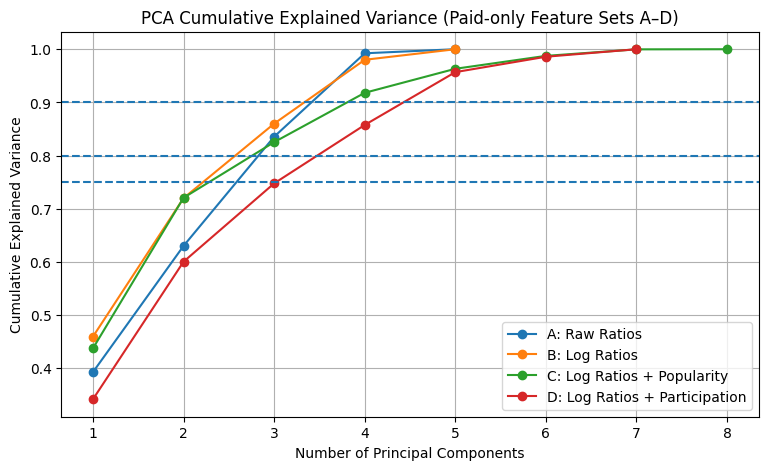

In [21]:
plt.figure(figsize=(9,5))

for r in results:
    plt.plot(range(1, len(r["cum_full"])+1), r["cum_full"], marker="o", label=r["name"])

plt.axhline(0.75, linestyle="--")
plt.axhline(0.80, linestyle="--")
plt.axhline(0.90, linestyle="--")

plt.title("PCA Cumulative Explained Variance (Paid-only Feature Sets A–D)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.show()

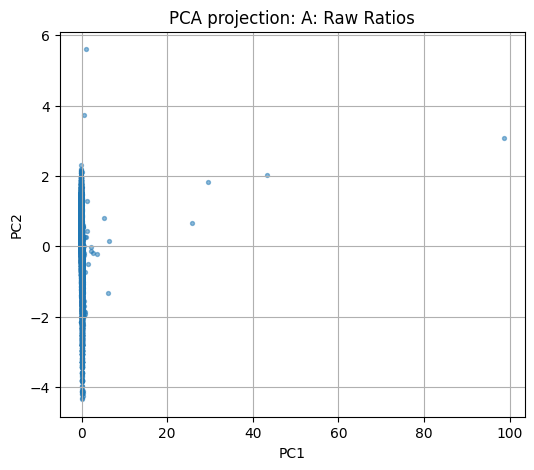

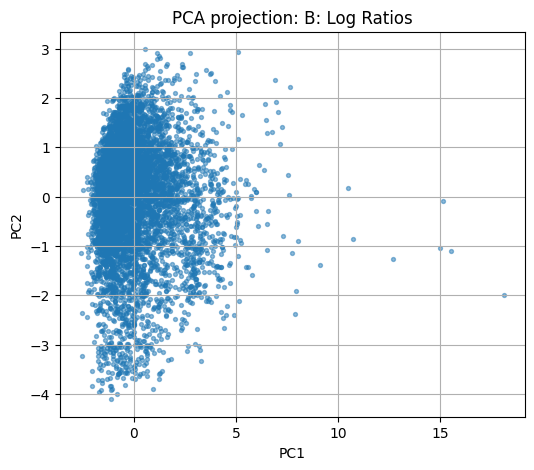

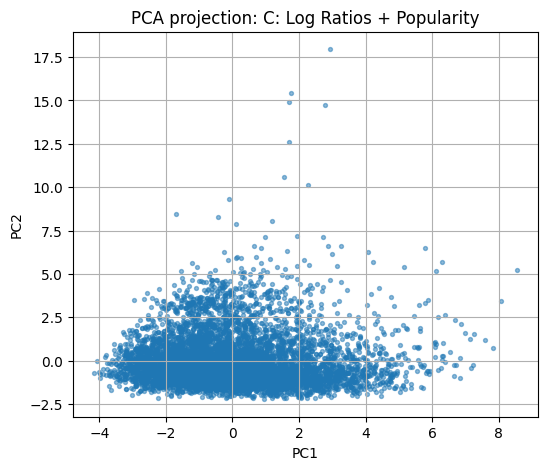

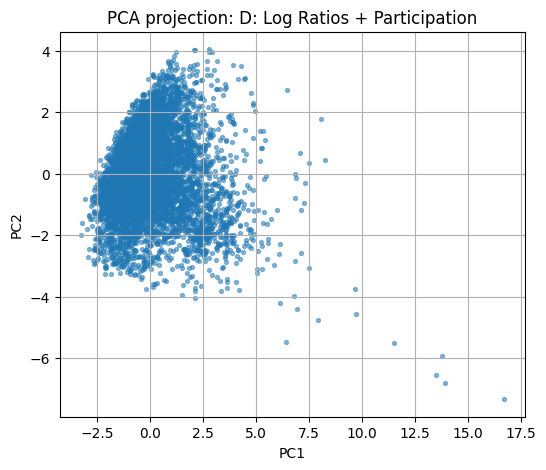

In [22]:
def plot_pca_2d(Z, title):
    plt.figure(figsize=(6,5))
    plt.scatter(Z[:,0], Z[:,1], s=8, alpha=0.5)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

for r in results:
    plot_pca_2d(r["Z"], f"PCA projection: {r['name']}")

In [23]:
for r in results:
    print("\n==============================")
    print("Feature Set:", r["name"])
    print("Explained variance (3 PCs):", r["evr_3_total"])
    print("\nLoadings:\n")
    display(r["loadings"])


Feature Set: A: Raw Ratios
Explained variance (3 PCs): 0.8354878927517062

Loadings:



PC1       PC2       PC3
hours_per_price_avg  0.705853  0.037856 -0.009158
hours_per_price_med  0.705629  0.037429 -0.025045
reviews_per_price    0.010292  0.098293  0.935504
pos_ratio_counts    -0.020157  0.719957  0.168448
log_price           -0.057860  0.684958 -0.309429


Feature Set: B: Log Ratios
Explained variance (3 PCs): 0.860073243382439

Loadings:



PC1       PC2       PC3
log_hpp_avg       0.613777  0.018449  0.336777
log_hpp_med       0.604874 -0.081559  0.377636
log_rpp           0.314426  0.552549 -0.498237
pos_ratio_counts  0.001690  0.754526  0.078372
log_price        -0.398169  0.344077  0.699707


Feature Set: C: Log Ratios + Popularity
Explained variance (3 PCs): 0.8253118919222256

Loadings:



PC1       PC2       PC3
log_hpp_avg       0.160790  0.585045 -0.039899
log_hpp_med       0.078601  0.603815  0.002193
log_rpp           0.459061  0.166307  0.002621
pos_ratio_counts  0.240582 -0.102666  0.949106
log_owners        0.449780 -0.009292 -0.116237
log_reviews       0.509425 -0.112579 -0.085540
log_peak_ccu      0.455440 -0.105957 -0.211732
log_price         0.173521 -0.480566 -0.178703


Feature Set: D: Log Ratios + Participation
Explained variance (3 PCs): 0.7477450913293958

Loadings:



PC1       PC2       PC3
log_hpp_avg        0.578664 -0.187876 -0.007218
log_hpp_med        0.540321 -0.289899 -0.036620
log_rpp            0.434530  0.408898  0.155892
pos_ratio_counts   0.102490  0.450228 -0.212725
reviews_per_owner -0.008235 -0.020096  0.961389
log_owners         0.301496  0.560382  0.017327
log_price         -0.287947  0.443087  0.066960

In [24]:
for r in results:
    print("\n==============================")
    print("Feature Set:", r["name"])
    L = r["loadings"]

    for pc in L.columns:
        print("\n", pc, "top positive")
        print(L[pc].sort_values(ascending=False).head(3))

        print(pc, "top negative")
        print(L[pc].sort_values(ascending=True).head(3))


Feature Set: A: Raw Ratios

 PC1 top positive
hours_per_price_avg    0.705853
hours_per_price_med    0.705629
reviews_per_price      0.010292
Name: PC1, dtype: float64
PC1 top negative
log_price           -0.057860
pos_ratio_counts    -0.020157
reviews_per_price    0.010292
Name: PC1, dtype: float64

 PC2 top positive
pos_ratio_counts     0.719957
log_price            0.684958
reviews_per_price    0.098293
Name: PC2, dtype: float64
PC2 top negative
hours_per_price_med    0.037429
hours_per_price_avg    0.037856
reviews_per_price      0.098293
Name: PC2, dtype: float64

 PC3 top positive
reviews_per_price      0.935504
pos_ratio_counts       0.168448
hours_per_price_avg   -0.009158
Name: PC3, dtype: float64
PC3 top negative
log_price             -0.309429
hours_per_price_med   -0.025045
hours_per_price_avg   -0.009158
Name: PC3, dtype: float64

Feature Set: B: Log Ratios

 PC1 top positive
log_hpp_avg    0.613777
log_hpp_med    0.604874
log_rpp        0.314426
Name: PC1, dtype: float64

#K-Means Clustering and Optimal k

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def build_pca_space(X, n_components=3):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(X_scaled)

    return Z, pca

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

def kmeans_sweep(Z, k_min=2, k_max=8):
    rows = []

    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        labels = km.fit_predict(Z)

        rows.append({
            "k": k,
            "silhouette": silhouette_score(Z, labels),
            "davies_bouldin": davies_bouldin_score(Z, labels),
            "calinski_harabasz": calinski_harabasz_score(Z, labels),
            "inertia": km.inertia_
        })

    return pd.DataFrame(rows)

In [28]:
Z_B, pca_B = build_pca_space(X_B, n_components=3)

print("Feature Set B explained variance:", pca_B.explained_variance_ratio_)
print("Feature Set B total:", pca_B.explained_variance_ratio_.sum())

kmeans_eval_B = kmeans_sweep(Z_B, 2, 8)
kmeans_eval_B

Feature Set B explained variance: [0.45969245 0.26033528 0.14004551]
Feature Set B total: 0.860073243382439


k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.421796        1.090529        3432.237328  19378.301911
1  3    0.309505        1.114703        3262.828011  14873.398140
2  4    0.291201        1.090195        3176.456004  12133.677694
3  5    0.286205        1.065256        2903.055384  10758.716673
4  6    0.289979        1.100374        2696.644329   9764.400931
5  7    0.274721        1.050314        2713.258988   8579.352146
6  8    0.270075        1.061211        2549.971429   8031.629055

In [27]:
Z_C, pca_C = build_pca_space(X_C, n_components=3)

print("Feature Set C explained variance:", pca_C.explained_variance_ratio_)
print("Feature Set C total:", pca_C.explained_variance_ratio_.sum())

kmeans_eval_C = kmeans_sweep(Z_C, 2, 8)
kmeans_eval_C

Feature Set C explained variance: [0.4376656  0.28302991 0.10461638]
Feature Set C total: 0.8253118919222256


k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.342665        1.145270        3597.675710  29279.543786
1  3    0.371012        0.945750        3841.117874  21009.742366
2  4    0.303476        1.035203        3671.943720  17073.417478
3  5    0.309059        1.006518        3537.184745  14516.367154
4  6    0.272107        1.069426        3270.167060  13132.990335
5  7    0.275056        1.055323        3233.620427  11601.476776
6  8    0.281132        1.018080        3136.844498  10568.209689

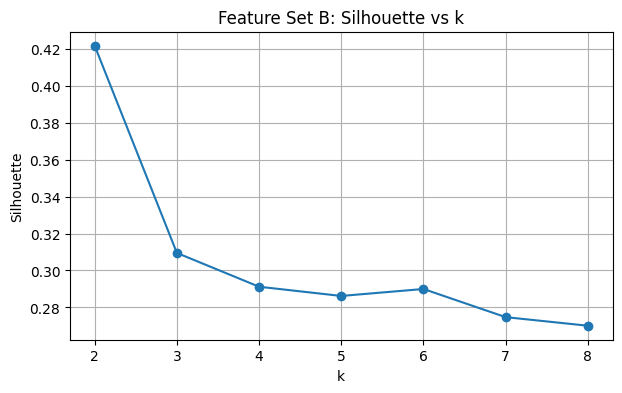

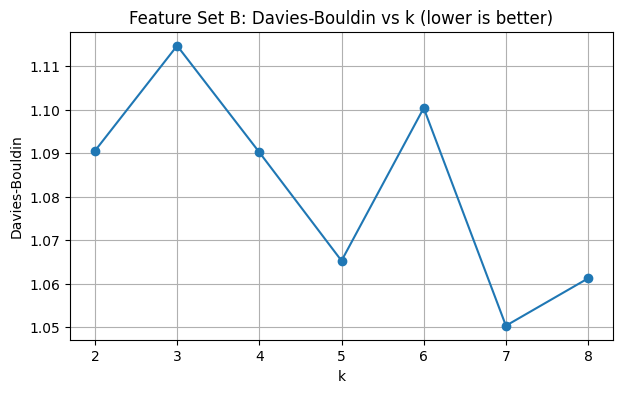

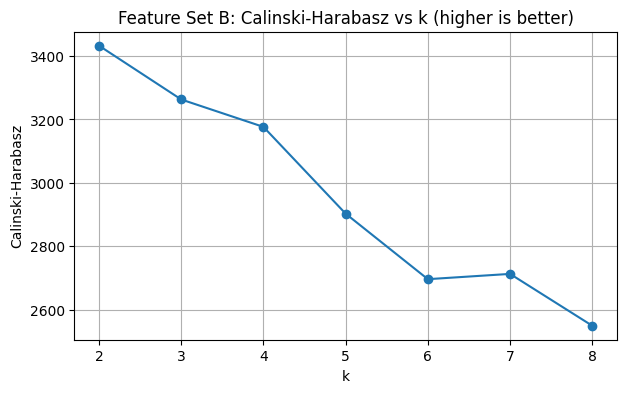

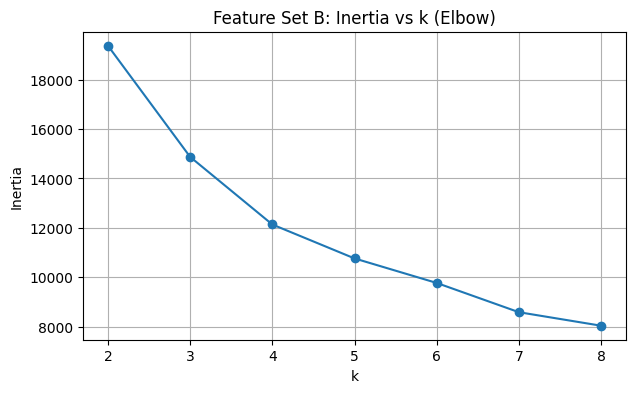

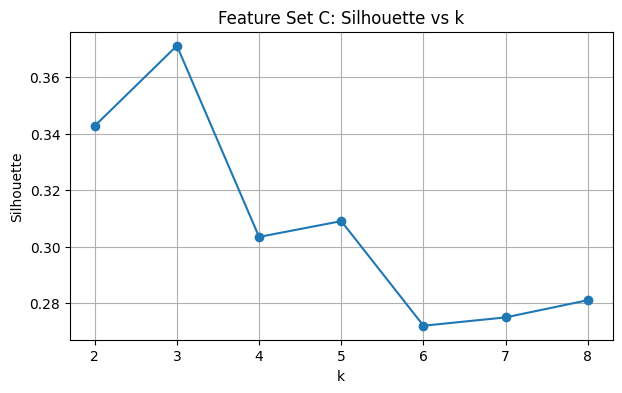

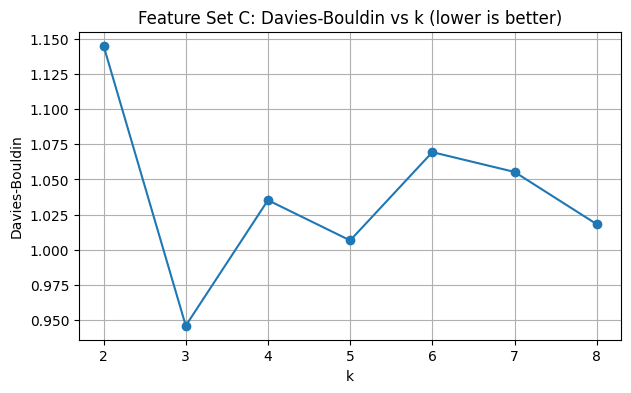

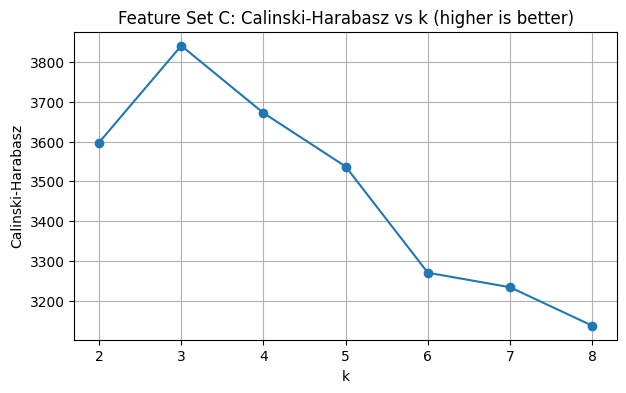

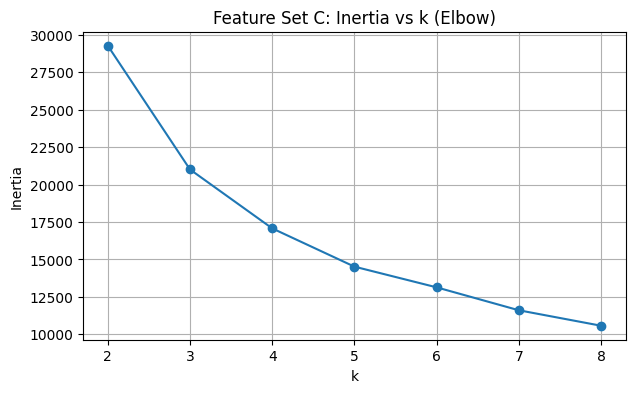

In [29]:
import matplotlib.pyplot as plt

def plot_kmeans_curves(eval_df, title_prefix=""):
    # silhouette
    plt.figure(figsize=(7,4))
    plt.plot(eval_df["k"], eval_df["silhouette"], marker="o")
    plt.title(f"{title_prefix} Silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("Silhouette")
    plt.grid(True)
    plt.show()

    # davies-bouldin
    plt.figure(figsize=(7,4))
    plt.plot(eval_df["k"], eval_df["davies_bouldin"], marker="o")
    plt.title(f"{title_prefix} Davies-Bouldin vs k (lower is better)")
    plt.xlabel("k")
    plt.ylabel("Davies-Bouldin")
    plt.grid(True)
    plt.show()

    # calinski-harabasz
    plt.figure(figsize=(7,4))
    plt.plot(eval_df["k"], eval_df["calinski_harabasz"], marker="o")
    plt.title(f"{title_prefix} Calinski-Harabasz vs k (higher is better)")
    plt.xlabel("k")
    plt.ylabel("Calinski-Harabasz")
    plt.grid(True)
    plt.show()

    # inertia
    plt.figure(figsize=(7,4))
    plt.plot(eval_df["k"], eval_df["inertia"], marker="o")
    plt.title(f"{title_prefix} Inertia vs k (Elbow)")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

plot_kmeans_curves(kmeans_eval_B, "Feature Set B:")
plot_kmeans_curves(kmeans_eval_C, "Feature Set C:")

#Initial Clustering

In [30]:
from sklearn.cluster import KMeans

best_k_B = 2

km_B = KMeans(n_clusters=best_k_B, random_state=42, n_init="auto")
labels_B = km_B.fit_predict(Z_B)

df_B = df_v.copy()
df_B["cluster_B"] = labels_B

print("Cluster counts (B):")
display(df_B["cluster_B"].value_counts().sort_index())

Cluster counts (B):


cluster_B
0    1404
1    5382
Name: count, dtype: int64

In [31]:
best_k_C = 3

km_C = KMeans(n_clusters=best_k_C, random_state=42, n_init="auto")
labels_C = km_C.fit_predict(Z_C)

df_C = df_v.copy()
df_C["cluster_C"] = labels_C

print("Cluster counts (C):")
display(df_C["cluster_C"].value_counts().sort_index())

Cluster counts (C):


cluster_C
0     990
1    3582
2    2214
Name: count, dtype: int64

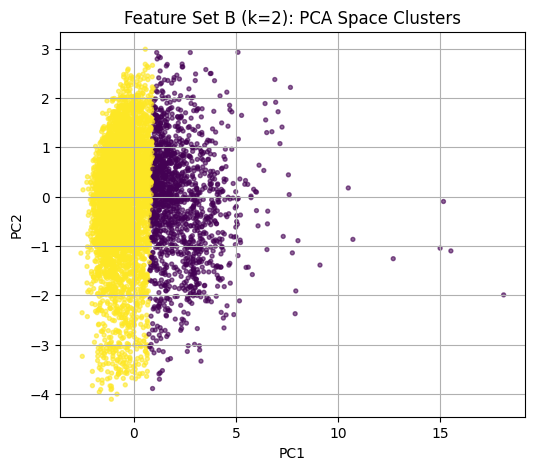

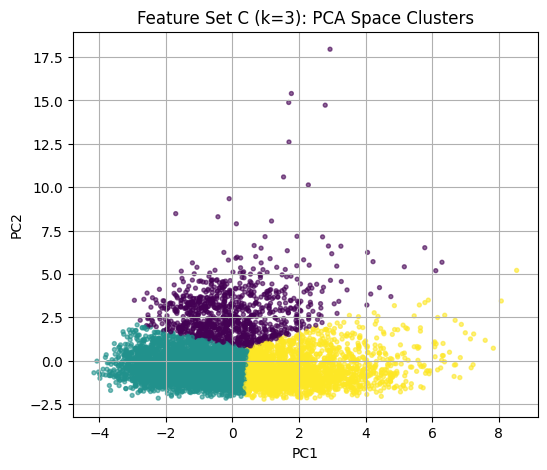

In [32]:
import matplotlib.pyplot as plt

# B plot
plt.figure(figsize=(6,5))
plt.scatter(Z_B[:,0], Z_B[:,1], c=labels_B, s=8, alpha=0.6)
plt.title("Feature Set B (k=2): PCA Space Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# C plot
plt.figure(figsize=(6,5))
plt.scatter(Z_C[:,0], Z_C[:,1], c=labels_C, s=8, alpha=0.6)
plt.title("Feature Set C (k=3): PCA Space Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [33]:
profile_cols = [
    "price",
    "avg_hours", "med_hours",
    "log_hpp_avg", "log_hpp_med",
    "log_rpp",
    "pos_ratio_counts",
    "owners_mid", "log_owners",
    "reviews_total", "log_reviews",
    "peak_ccu", "log_peak_ccu"
]

profile_cols = [c for c in profile_cols if c in df_B.columns]

cluster_profile_B_mean = df_B.groupby("cluster_B")[profile_cols].mean()
cluster_profile_B_median = df_B.groupby("cluster_B")[profile_cols].median()

print("Feature Set B: Cluster Means")
display(cluster_profile_B_mean)

print("Feature Set B: Cluster Medians")
display(cluster_profile_B_median)

Feature Set B: Cluster Means


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med  \
cluster_B                                                              
0           5.182764  79.623469  89.600546     1.496857     1.423439   
1          15.906962   7.477741   6.334296     0.322863     0.308551   

            log_rpp  pos_ratio_counts     owners_mid  log_owners  \
cluster_B                                                          
0          5.711351          0.756143  834170.227920   11.927015   
1          4.206210          0.771026  389392.419175   11.466185   

           reviews_total  log_reviews    peak_ccu  log_peak_ccu  
cluster_B                                                        
0           14174.566952     6.738786  932.125356      2.242258  
1            5331.426421     6.619563  354.691193      2.092810

Feature Set B: Cluster Medians


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med   log_rpp  \
cluster_B                                                                    
0           2.17   5.766667   5.550000     1.320352     1.276771  5.553881   
1          13.99   3.433333   3.466667     0.262278     0.244433  4.126655   

           pos_ratio_counts  owners_mid  log_owners  reviews_total  \
cluster_B                                                            
0                  0.800953    150000.0   11.918397          651.0   
1                  0.823512     75000.0   11.225257          681.0   

           log_reviews  peak_ccu  log_peak_ccu  
cluster_B                                       
0             6.480040       3.0      1.386294  
1             6.525029       3.0      1.386294

In [34]:
cluster_profile_C_mean = df_C.groupby("cluster_C")[profile_cols].mean()
cluster_profile_C_median = df_C.groupby("cluster_C")[profile_cols].median()

print("Feature Set C: Cluster Means")
display(cluster_profile_C_mean)

print("Feature Set C: Cluster Medians")
display(cluster_profile_C_median)

Feature Set C: Cluster Means


price  avg_hours   med_hours  log_hpp_avg  log_hpp_med  \
cluster_C                                                               
0           3.384121  97.300219  118.550337     1.611304     1.618773   
1          12.068297   3.906286    4.323278     0.284463     0.304426   
2          20.916418  18.842374   12.212978     0.553341     0.436354   

            log_rpp  pos_ratio_counts    owners_mid  log_owners  \
cluster_C                                                         
0          5.322852          0.732943  2.149697e+05   11.506456   
1          3.381086          0.722751  7.718314e+04   10.613036   
2          5.996334          0.856719  1.254560e+06   13.120710   

           reviews_total  log_reviews     peak_ccu  log_peak_ccu  
cluster_C                                                         
0            1342.626263     6.010157    54.084848      1.306612  
1             454.507538     5.497612     6.062256      0.927632  
2           20613.181120     8.782856  1419.328365      4.424259

Feature Set C: Cluster Medians


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med   log_rpp  \
cluster_C                                                                    
0           1.99   4.791667   4.958333     1.432407     1.525967  5.234806   
1           9.99   2.150000   2.300000     0.205326     0.219808  3.401681   
2          19.99   8.633333   6.466667     0.424275     0.346083  5.792939   

           pos_ratio_counts  owners_mid  log_owners  reviews_total  \
cluster_C                                                            
0                  0.774319     75000.0   11.225257          401.0   
1                  0.777085     35000.0   10.463132          287.0   
2                  0.883472    350000.0   12.765691         4892.5   

           log_reviews  peak_ccu  log_peak_ccu  
cluster_C                                       
0             5.996452       1.0      0.693147  
1             5.662960       1.0      0.693147  
2             8.495663      61.5      4.135135

In [38]:
def show_representatives(df, cluster_col, top_n=8):
    for c in sorted(df[cluster_col].unique()):
        print("\n==============================")
        print(f"Cluster {c} — Top {top_n} by log_hpp_avg")
        sub = df[df[cluster_col] == c].copy()
        sub = sub.sort_values("log_hpp_avg", ascending=False)

        display(sub[[
            "name", "price", "avg_hours", "med_hours",
            "log_hpp_avg", "log_rpp",
            "pos_ratio_counts", "owners_mid", "reviews_total"
        ]].head(top_n))

show_representatives(df_B, "cluster_B", top_n=8)
print("======================================================================================================================================================================================")
show_representatives(df_C, "cluster_C", top_n=8)


Cluster 0 — Top 8 by log_hpp_avg


name  price     avg_hours     med_hours  \
8582              Darkness Assault   0.99   8890.700000  17777.850000   
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
2937                NEKOPARA Extra   1.99   2444.483333      1.583333   
1912                Yokai's Secret   1.99   1376.466667      1.333333   
8280               Hatsune Miku VR  24.99  16530.616667  16530.616667   
10162                Masked Forces   0.99    543.966667   1086.816667   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
8582      9.102923  6.329000          0.525994    350000.0          554.0  
15124     8.588912  3.726383          0.826291     35000.0          184.0  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0  
2937      7.114268  7.448088          0.974002    350000.0         3414.0  
1912      6.540585  8.091729          0.899462    350000.0         6500.0  
8280      6.496004  3.206377          0.717868     75000.0          592.0  
10162     6.310757  6.006478          0.666667     75000.0          401.0


Cluster 1 — Top 8 by log_hpp_avg


name  price   avg_hours  \
5941  Mega Man Battle Network Legacy Collection Vol. 1  39.99  335.616667   
4450                                        Niffelheim  19.99  129.833333   
879                                Company of Heroes 3  59.99  291.833333   
66                                   Battlefield™ 2042  59.99  289.150000   
235                            DARK SOULS™: REMASTERED  39.99  178.866667   
166                                     NieR:Automata™  39.99  172.100000   
55                                     DARK SOULS™ III  59.99  236.633333   
37                                                DayZ  49.99  193.916667   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
5941  41.783333     2.239913  3.341335          0.869699    150000.0   
4450   4.650000     2.014225  4.496965          0.712593    150000.0   
879   21.883333     1.768951  5.724296          0.561880    750000.0   
66    14.416667     1.761295  8.249354          0.464837  15000000.0   
235   23.150000     1.699788  7.598612          0.920507   3500000.0   
166   10.616667     1.668381  7.842617          0.869510   3500000.0   
55    29.383333     1.598285  8.368067          0.943118   7500000.0   
37    29.633333     1.584963  8.853785          0.764954   7500000.0   

      reviews_total  
5941         1090.0  
4450         1774.0  
879         18310.0  
66         229411.0  
235         79757.0  
166        101809.0  
55         258335.0  
37         349922.0


Cluster 0 — Top 8 by log_hpp_avg


name  price     avg_hours     med_hours  \
8582              Darkness Assault   0.99   8890.700000  17777.850000   
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
2937                NEKOPARA Extra   1.99   2444.483333      1.583333   
1912                Yokai's Secret   1.99   1376.466667      1.333333   
8280               Hatsune Miku VR  24.99  16530.616667  16530.616667   
10162                Masked Forces   0.99    543.966667   1086.816667   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
8582      9.102923  6.329000          0.525994    350000.0          554.0  
15124     8.588912  3.726383          0.826291     35000.0          184.0  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0  
2937      7.114268  7.448088          0.974002    350000.0         3414.0  
1912      6.540585  8.091729          0.899462    350000.0         6500.0  
8280      6.496004  3.206377          0.717868     75000.0          592.0  
10162     6.310757  6.006478          0.666667     75000.0          401.0


Cluster 1 — Top 8 by log_hpp_avg


name  price   avg_hours  \
5968                                Onee Chanbara ORIGIN  59.99  211.650000   
35904                Planet Stronghold: Colonial Defense  19.99   64.350000   
12394       Atelier Meruru ~The Apprentice of Arland~ DX  39.99  126.633333   
7654                                 Disgaea 4 Complete+  39.99  116.100000   
7853               Livestream: Escape from Hotel Izanami  19.99   52.300000   
9222   Romance of the Three Kingdoms IX with Power Up...  29.99   77.283333   
8606                                            JUNKPUNK  15.99   40.250000   
7606                No More Heroes 2: Desperate Struggle  19.99   50.033333   

        med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
5968   211.650000     1.510300  2.944597          0.752874     75000.0   
35904   64.350000     1.439624  0.854703          0.756757     10000.0   
12394  126.633333     1.427106  2.063911          0.954386     10000.0   
7654   116.100000     1.361803  2.890608          0.880099     75000.0   
7853    52.300000     1.285454  3.510537          0.793153     35000.0   
9222    77.283333     1.274516  2.839392          0.849903     35000.0   
8606    40.250000     1.257665  3.570140          0.733558     35000.0   
7606    50.033333     1.253596  3.567198          0.709893     75000.0   

       reviews_total  
5968          1080.0  
35904           27.0  
12394          275.0  
7654           680.0  
7853           649.0  
9222           483.0  
8606           552.0  
7606           688.0


Cluster 2 — Top 8 by log_hpp_avg


name  price   avg_hours   med_hours  \
424          NEEDY STREAMER OVERLOAD   6.39  471.733333    2.533333   
4    Tom Clancy's Rainbow Six® Siege   3.99  236.733333   40.566667   
582                    Bright Memory   7.99  346.716667    1.133333   
282              Company of Heroes 2   4.99  215.783333    5.050000   
256         FINAL FANTASY XIV Online  19.99  837.650000  120.983333   
8                        Garry's Mod   5.99  183.116667   19.550000   
26             ARK: Survival Evolved  14.99  217.766667   13.683333   
200                          Brotato   2.99   39.800000   13.400000   

     log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
424     4.315134   8.803240          0.948807   1500000.0        42524.0  
4       4.099857  12.587033          0.840690  35000000.0      1168020.0  
582     3.793100   8.223435          0.905897   1500000.0        29773.0  
282     3.789701   9.486711          0.789523   7500000.0        65780.0  
256     3.758952   8.197268          0.879749   3500000.0        72564.0  
8       3.452220  12.010322          0.967879  35000000.0       985010.0  
26      2.742610  10.495706          0.837360  35000000.0       542022.0  
200     2.661031  10.304338          0.967345   3500000.0        89284.0

#Analysis and morr Experiments
may checheck lng

In [39]:
features_E = [
    "log_hpp_avg",
    "log_hpp_med",
    "log_rpp",
    "pos_ratio_counts",
    "reviews_per_owner",
    "log_owners",
    "log_reviews",
    "log_peak_ccu",
    "log_price"
]

X_E = df_v[features_E].copy()
print("X_E shape:", X_E.shape)
X_E.describe().T

X_E shape: (6786, 9)


count       mean       std       min        25%  \
log_hpp_avg        6786.0   0.565758  0.655665  0.000476   0.138494   
log_hpp_med        6786.0   0.539217  0.619251  0.000476   0.132800   
log_rpp            6786.0   4.517619  1.766554  0.231153   3.262361   
pos_ratio_counts   6786.0   0.767946  0.194714  0.000000   0.700000   
reviews_per_owner  6786.0   0.019203  0.178053  0.000010   0.003626   
log_owners         6786.0  11.561529  1.630137  9.210440  10.463132   
log_reviews        6786.0   6.644230  1.975572  2.397895   5.247024   
log_peak_ccu       6786.0   2.123730  2.230363  0.000000   0.000000   
log_price          6786.0   2.338218  0.886897  0.398776   1.790091   

                         50%        75%        max  
log_hpp_avg         0.361493   0.761750   9.102923  
log_hpp_med         0.343527   0.723737   9.795815  
log_rpp             4.393149   5.649221  12.587033  
pos_ratio_counts    0.818914   0.901437   0.995868  
reviews_per_owner   0.008799   0.016724  10.291271  
log_owners         11.225257  12.765691  18.132999  
log_reviews         6.519147   7.888710  13.970821  
log_peak_ccu        1.386294   3.401197  13.463449  
log_price           2.396986   3.044046   4.262539

In [40]:
Z_A, pca_A = build_pca_space(X_A, 3)
Z_D, pca_D = build_pca_space(X_D, 3)
Z_E, pca_E = build_pca_space(X_E, 3)

print("A total EVR:", pca_A.explained_variance_ratio_.sum())
print("D total EVR:", pca_D.explained_variance_ratio_.sum())
print("E total EVR:", pca_E.explained_variance_ratio_.sum())

A total EVR: 0.8354878927517062
D total EVR: 0.7477450913293958
E total EVR: 0.7597245655261918


In [41]:
kmeans_eval_A = kmeans_sweep(Z_A, 2, 8)
kmeans_eval_D = kmeans_sweep(Z_D, 2, 8)
kmeans_eval_E = kmeans_sweep(Z_E, 2, 8)

display(kmeans_eval_A)
display(kmeans_eval_D)
display(kmeans_eval_E)

k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.515448        0.816600        1595.280877  22951.295709
1  3    0.518231        0.665359        1631.497873  19140.679160
2  4    0.519403        0.519363        4540.761593   9422.593485
3  5    0.520568        0.496540        6102.701261   6162.922819
4  6    0.449299        0.568671        6779.965701   4724.828314
5  7    0.373769        0.659158        6594.851290   4146.321954
6  8    0.391640        0.553022        7752.050439   3147.726941

k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.385418        1.176263        2628.471870  25600.591504
1  3    0.389004        0.806894        2716.951319  19721.046524
2  4    0.381319        0.681951        4064.925202  12694.151642
3  5    0.325551        0.790310        4035.326612  10507.688743
4  6    0.333564        0.762561        4122.214920   8792.063343
5  7    0.322681        0.819986        4032.655352   7773.648200
6  8    0.324933        0.815024        3969.633779   6965.199616

k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.379637        1.070358        3410.878461  30875.898002
1  3    0.411530        0.842056        3565.593314  22619.260029
2  4    0.348400        0.898180        3306.228525  18842.466113
3  5    0.335191        0.962552        2878.088967  17199.626856
4  6    0.338406        0.809800        3952.049739  11853.490937
5  7    0.311072        0.855438        3946.061887  10328.176089
6  8    0.300344        0.932464        3729.336546   9564.558451

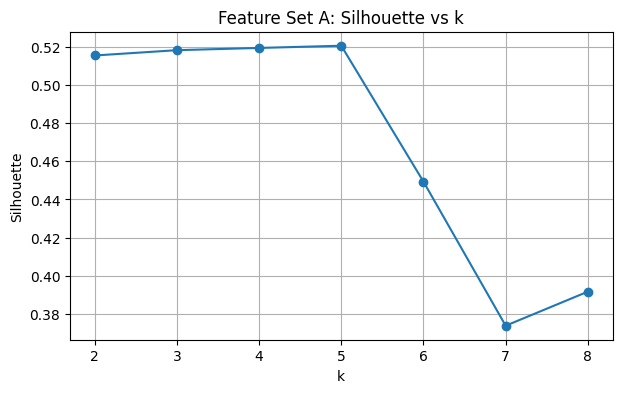

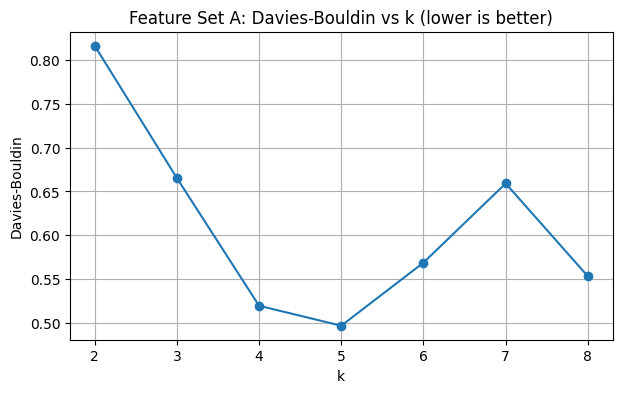

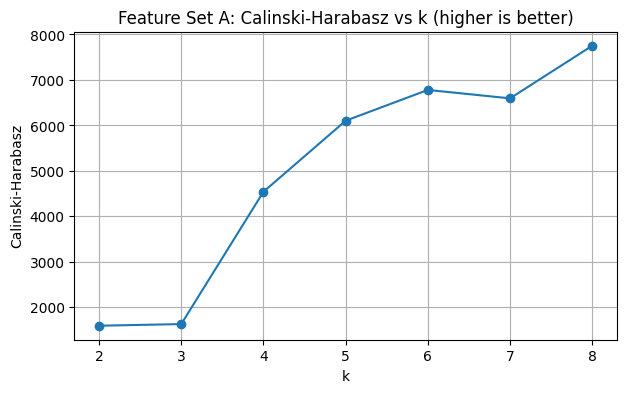

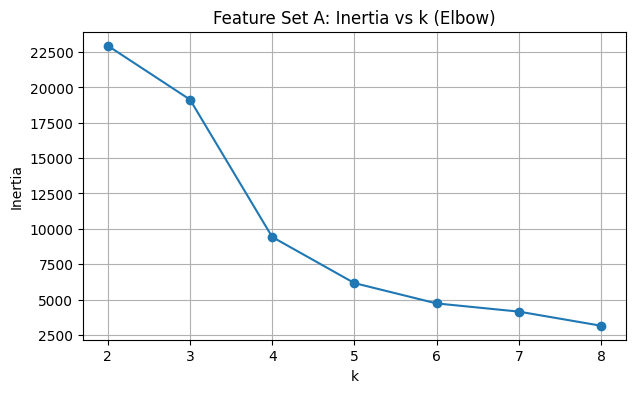

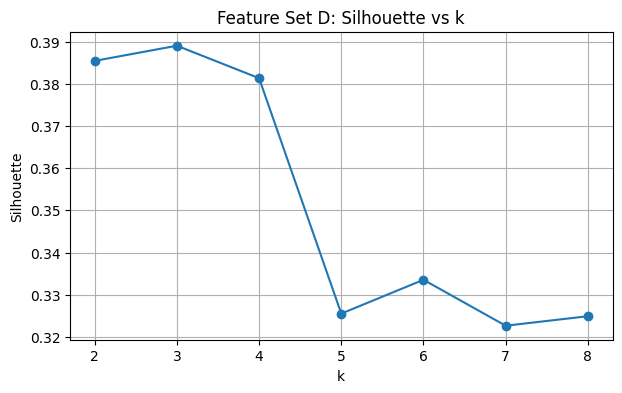

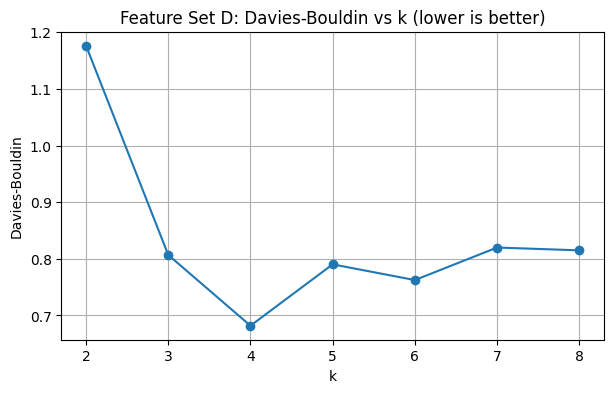

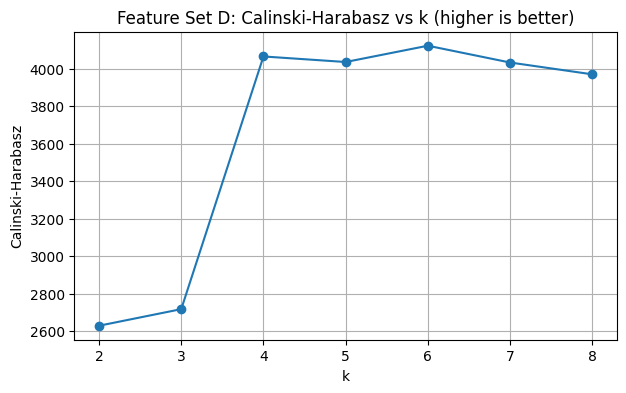

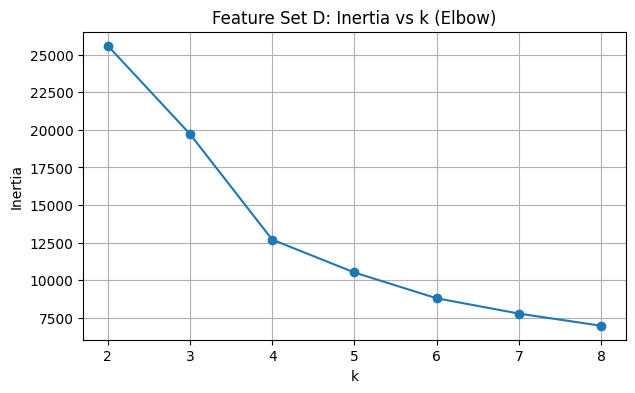

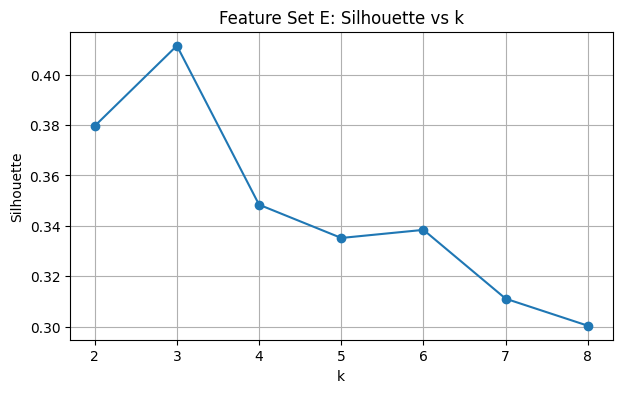

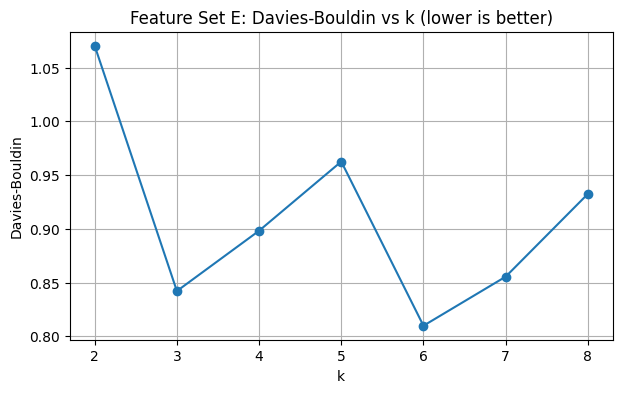

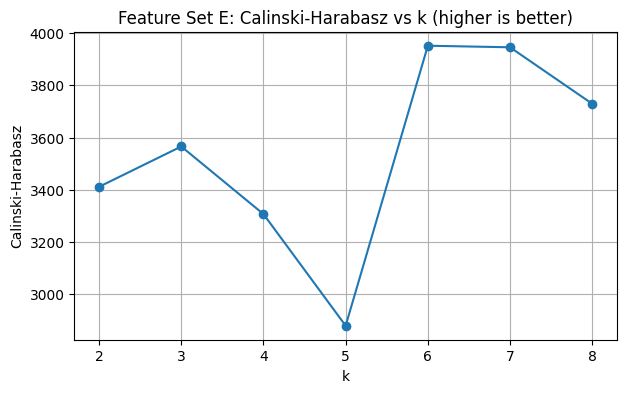

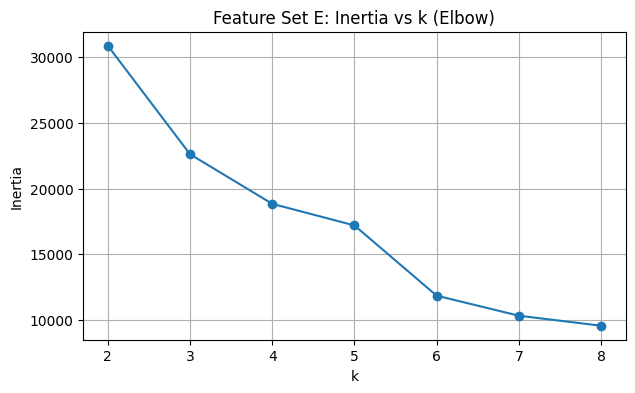

In [42]:
plot_kmeans_curves(kmeans_eval_A, "Feature Set A:")
plot_kmeans_curves(kmeans_eval_D, "Feature Set D:")
plot_kmeans_curves(kmeans_eval_E, "Feature Set E:")

In [43]:
def best_k_by_silhouette(eval_df):
    return int(eval_df.sort_values("silhouette", ascending=False).iloc[0]["k"])

best_k_A = best_k_by_silhouette(kmeans_eval_A)
best_k_D = best_k_by_silhouette(kmeans_eval_D)
best_k_E = best_k_by_silhouette(kmeans_eval_E)

print("Best k (A):", best_k_A)
print("Best k (D):", best_k_D)
print("Best k (E):", best_k_E)

Best k (A): 5
Best k (D): 3
Best k (E): 3


In [44]:
def fit_kmeans_labels(Z, k):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Z)
    return labels

labels_A = fit_kmeans_labels(Z_A, best_k_A)
labels_D = fit_kmeans_labels(Z_D, best_k_D)
labels_E = fit_kmeans_labels(Z_E, best_k_E)

print("Cluster counts A:")
display(pd.Series(labels_A).value_counts().sort_index())

print("Cluster counts D:")
display(pd.Series(labels_D).value_counts().sort_index())

print("Cluster counts E:")
display(pd.Series(labels_E).value_counts().sort_index())

Cluster counts A:


0    2238
1    4541
2       3
3       1
4       3
Name: count, dtype: int64

Cluster counts D:


0    1929
1    4855
2       2
Name: count, dtype: int64

Cluster counts E:


0     986
1    3585
2    2215
Name: count, dtype: int64

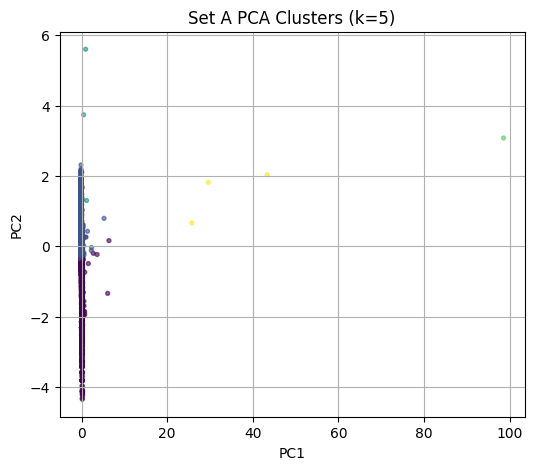

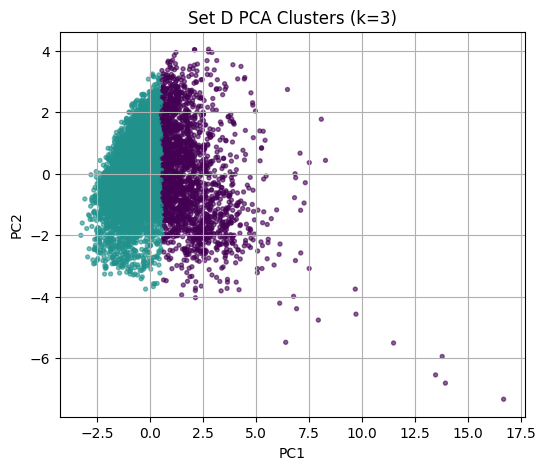

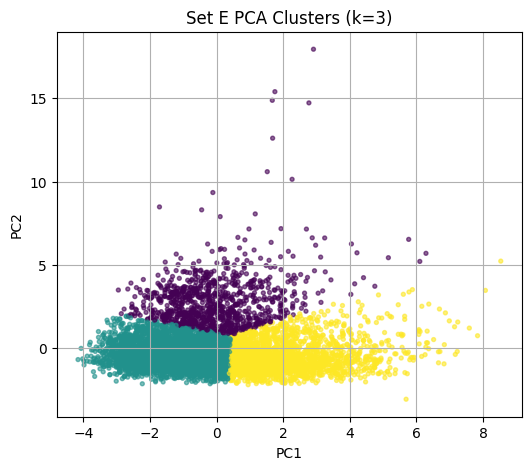

In [45]:
plt.figure(figsize=(6,5))
plt.scatter(Z_A[:,0], Z_A[:,1], c=labels_A, s=8, alpha=0.6)
plt.title(f"Set A PCA Clusters (k={best_k_A})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(Z_D[:,0], Z_D[:,1], c=labels_D, s=8, alpha=0.6)
plt.title(f"Set D PCA Clusters (k={best_k_D})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(Z_E[:,0], Z_E[:,1], c=labels_E, s=8, alpha=0.6)
plt.title(f"Set E PCA Clusters (k={best_k_E})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [47]:
df_A = df_v.copy()
df_A["cluster_A"] = labels_A

df_D = df_v.copy()
df_D["cluster_D"] = labels_D

df_E = df_v.copy()
df_E["cluster_E"] = labels_E

def show_cluster_reps(df, cluster_col, top_n=8):
    for c in sorted(df[cluster_col].unique()):
        sub = df[df[cluster_col] == c].copy()
        print("\n==============================")
        print(f"{cluster_col} = {c} | size = {len(sub)}")

        # Top by log_hpp_avg
        print(f"\nTop {top_n} by log_hpp_avg (time-per-price value)")
        display(sub.sort_values("log_hpp_avg", ascending=False)[[
            "name", "price", "avg_hours", "med_hours",
            "log_hpp_avg", "log_rpp",
            "pos_ratio_counts", "owners_mid", "reviews_total"
        ]].head(top_n))

        # Top by log_rpp
        print(f"\nTop {top_n} by log_rpp (review-per-price value)")
        display(sub.sort_values("log_rpp", ascending=False)[[
            "name", "price", "avg_hours", "med_hours",
            "log_hpp_avg", "log_rpp",
            "pos_ratio_counts", "owners_mid", "reviews_total"
        ]].head(top_n))

In [49]:
show_cluster_reps(df_A, "cluster_A", top_n=8)


cluster_A = 0 | size = 2238

Top 8 by log_hpp_avg (time-per-price value)


name  price    avg_hours    med_hours  log_hpp_avg  \
2937           NEKOPARA Extra   1.99  2444.483333     1.583333     7.114268   
1912           Yokai's Secret   1.99  1376.466667     1.333333     6.540585   
10162           Masked Forces   0.99   543.966667  1086.816667     6.310757   
1064          NEKOPARA Vol. 0   1.19   610.800000     1.266667     6.242763   
221           Killing Floor 2   2.99   546.233333     6.783333     5.213232   
21008          BuildMoreCubes   4.99   721.383333  1437.633333     4.980628   
12565  Zoop! - Hunter's Grimm   1.99   182.750000     4.550000     4.530815   
12533    3D Custom Lady Maker   4.99   457.500000   457.500000     4.529189   

         log_rpp  pos_ratio_counts  owners_mid  reviews_total  
2937    7.448088          0.974002    350000.0         3414.0  
1912    8.091729          0.899462    350000.0         6500.0  
10162   6.006478          0.666667     75000.0          401.0  
1064    9.402847          0.938740    750000.0        14425.0  
221    10.235074          0.877430   3500000.0        83309.0  
21008   2.977430          0.731707     35000.0           93.0  
12565   4.910250          0.603125    350000.0          268.0  
12533   4.005656          0.677083     35000.0          269.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  \
651                                  Blood and Bacon   0.49    4.116667   
662                              Tricolour Lovestory   0.59   27.516667   
646   Milk inside a bag of milk inside a bag of milk   0.74    0.833333   
501                                            LIMBO   0.99    2.983333   
221                                  Killing Floor 2   2.99  546.233333   
231                                 Metro 2033 Redux   2.99    9.350000   
1241                DR LIVESEY ROM AND DEATH EDITION   0.49    6.533333   
183                                       FOR HONOR™   4.49   48.850000   

      med_hours  log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  \
651    2.150000     2.240854  10.891795          0.952319   1500000.0   
662    4.016667     3.863640  10.688418          0.820340   1500000.0   
646    0.466667     0.754302  10.484296          0.967348    750000.0   
501    2.083333     1.389656  10.476662          0.926708   3500000.0   
221    6.783333     5.213232  10.235074          0.877430   3500000.0   
231    6.166667     1.417573  10.206993          0.905692   3500000.0   
1241   0.433333     2.662588  10.097853          0.946156    750000.0   
183    9.583333     2.474834   9.953364          0.695129   7500000.0   

      reviews_total  
651         26329.0  
662         25868.0  
646         26454.0  
501         35122.0  
221         83309.0  
231         81002.0  
1241        11902.0  
183         94388.0


cluster_A = 1 | size = 4541

Top 8 by log_hpp_avg (time-per-price value)


name  price     avg_hours     med_hours  log_hpp_avg  \
8280          Hatsune Miku VR  24.99  16530.616667  16530.616667     6.496004   
2637    If My Heart Had Wings   2.99   1324.016667     12.400000     6.095408   
5663       Hiveswap Friendsim   2.59    726.700000    726.700000     5.640414   
1661          NEKOPARA Vol. 4   4.99   1346.666667      2.033333     5.601650   
1314          NEKOPARA Vol. 3   3.99    550.416667      1.450000     4.934107   
424   NEEDY STREAMER OVERLOAD   6.39    471.733333      2.533333     4.315134   
420         Age of History II   4.99    349.933333     57.233333     4.264466   
5928              Increlution   3.99    249.833333    305.916667     4.152847   

       log_rpp  pos_ratio_counts  owners_mid  reviews_total  
8280  3.206377          0.717868     75000.0          592.0  
2637  7.193761          0.922364    350000.0         3977.0  
5663  6.125494          0.926537     75000.0         1182.0  
1661  7.382506          0.973626    350000.0         8017.0  
1314  7.926303          0.969991    750000.0        11045.0  
424   8.803240          0.948807   1500000.0        42524.0  
420   9.065465          0.897798   1500000.0        43165.0  
5928  5.617445          0.866606    150000.0         1094.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  log_hpp_avg  \
35           Geometry Dash   4.99   48.416667  11.133333     2.370500   
13          Stardew Valley  14.99   81.183333  34.216667     1.858769   
63       Vampire Survivors   4.99   38.150000  17.350000     2.157015   
29                PAYDAY 2   9.99  115.550000   9.333333     2.531040   
26   ARK: Survival Evolved  14.99  217.766667  13.683333     2.742610   
20            Phasmophobia  19.99   38.600000  15.450000     1.075332   
200                Brotato   2.99   39.800000  13.400000     2.661031   
24        Dead by Daylight  19.99  224.516667  21.400000     2.504010   

       log_rpp  pos_ratio_counts  owners_mid  reviews_total  
35   11.215699          0.934554   7500000.0       370690.0  
13   10.798392          0.984277  35000000.0       733626.0  
63   10.758887          0.984867   7500000.0       234756.0  
29   10.681278          0.896194  35000000.0       434886.0  
26   10.495706          0.837360  35000000.0       542022.0  
20   10.336622          0.958487  15000000.0       616505.0  
200  10.304338          0.967345   3500000.0        89284.0  
24   10.256729          0.790263  35000000.0       569165.0


cluster_A = 2 | size = 3

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  med_hours  \
248                           Mirror   0.79  138.900000   4.500000   
4    Tom Clancy's Rainbow Six® Siege   3.99  236.733333  40.566667   
8                        Garry's Mod   5.99  183.116667  19.550000   

     log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
248     5.175148  11.444061          0.969207   3500000.0        73742.0  
4       4.099857  12.587033          0.840690  35000000.0      1168020.0  
8       3.452220  12.010322          0.967879  35000000.0       985010.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  \
4    Tom Clancy's Rainbow Six® Siege   3.99  236.733333  40.566667   
8                        Garry's Mod   5.99  183.116667  19.550000   
248                           Mirror   0.79  138.900000   4.500000   

     log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
4       4.099857  12.587033          0.840690  35000000.0      1168020.0  
8       3.452220  12.010322          0.967879  35000000.0       985010.0  
248     5.175148  11.444061          0.969207   3500000.0        73742.0


cluster_A = 3 | size = 1

Top 8 by log_hpp_avg (time-per-price value)


name  price  avg_hours  med_hours  log_hpp_avg  log_rpp  \
8582  Darkness Assault   0.99     8890.7   17777.85     9.102923    6.329   

      pos_ratio_counts  owners_mid  reviews_total  
8582          0.525994    350000.0          554.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  med_hours  log_hpp_avg  log_rpp  \
8582  Darkness Assault   0.99     8890.7   17777.85     9.102923    6.329   

      pos_ratio_counts  owners_mid  reviews_total  
8582          0.525994    350000.0          554.0


cluster_A = 4 | size = 3

Top 8 by log_hpp_avg (time-per-price value)


name  price     avg_hours     med_hours  \
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
15124     8.588912  3.726383          0.826291     35000.0          184.0  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0


Top 8 by log_rpp (review-per-price value)


name  price     avg_hours     med_hours  \
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0  
15124     8.588912  3.726383          0.826291     35000.0          184.0

In [50]:
show_cluster_reps(df_D, "cluster_D", top_n=8)


cluster_D = 0 | size = 1929

Top 8 by log_hpp_avg (time-per-price value)


name  price     avg_hours     med_hours  \
8582              Darkness Assault   0.99   8890.700000  17777.850000   
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
2937                NEKOPARA Extra   1.99   2444.483333      1.583333   
1912                Yokai's Secret   1.99   1376.466667      1.333333   
8280               Hatsune Miku VR  24.99  16530.616667  16530.616667   
10162                Masked Forces   0.99    543.966667   1086.816667   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
8582      9.102923  6.329000          0.525994    350000.0          554.0  
15124     8.588912  3.726383          0.826291     35000.0          184.0  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0  
2937      7.114268  7.448088          0.974002    350000.0         3414.0  
1912      6.540585  8.091729          0.899462    350000.0         6500.0  
8280      6.496004  3.206377          0.717868     75000.0          592.0  
10162     6.310757  6.006478          0.666667     75000.0          401.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  \
4    Tom Clancy's Rainbow Six® Siege   3.99  236.733333  40.566667   
8                        Garry's Mod   5.99  183.116667  19.550000   
248                           Mirror   0.79  138.900000   4.500000   
35                     Geometry Dash   4.99   48.416667  11.133333   
651                  Blood and Bacon   0.49    4.116667   2.150000   
13                    Stardew Valley  14.99   81.183333  34.216667   
63                 Vampire Survivors   4.99   38.150000  17.350000   
662              Tricolour Lovestory   0.59   27.516667   4.016667   

     log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
4       4.099857  12.587033          0.840690  35000000.0      1168020.0  
8       3.452220  12.010322          0.967879  35000000.0       985010.0  
248     5.175148  11.444061          0.969207   3500000.0        73742.0  
35      2.370500  11.215699          0.934554   7500000.0       370690.0  
651     2.240854  10.891795          0.952319   1500000.0        26329.0  
13      1.858769  10.798392          0.984277  35000000.0       733626.0  
63      2.157015  10.758887          0.984867   7500000.0       234756.0  
662     3.863640  10.688418          0.820340   1500000.0        25868.0


cluster_D = 1 | size = 4855

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  \
35904                Planet Stronghold: Colonial Defense  19.99   64.350000   
12394       Atelier Meruru ~The Apprentice of Arland~ DX  39.99  126.633333   
7654                                 Disgaea 4 Complete+  39.99  116.100000   
9222   Romance of the Three Kingdoms IX with Power Up...  29.99   77.283333   
18806                                        Polimines 2   9.99   24.350000   
36607                                    Escape The Past   4.99   12.000000   
25022                                    Boons & Burdens   5.99   13.983333   
26257                                     Exile to Death   4.99   11.633333   

        med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
35904   64.350000     1.439624  0.854703          0.756757     10000.0   
12394  126.633333     1.427106  2.063911          0.954386     10000.0   
7654   116.100000     1.361803  2.890608          0.880099     75000.0   
9222    77.283333     1.274516  2.839392          0.849903     35000.0   
18806   24.350000     1.234726  2.550368          0.870229     10000.0   
36607   12.000000     1.225189  1.826229          0.694444     35000.0   
25022   13.983333     1.204307  2.443870          0.769231     10000.0   
26257   13.116667     1.203371  2.503274          0.430556     35000.0   

       reviews_total  
35904           27.0  
12394          275.0  
7654           680.0  
9222           483.0  
18806          118.0  
36607           26.0  
25022           63.0  
26257           56.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  \
298                       Hellblade: Senua's Sacrifice  29.99   4.466667   
454                        What Remains of Edith Finch  19.99   2.416667   
1446                       A Game About Digging A Hole   4.99   2.383333   
972                              FreshWomen - Season 1   8.39   3.866667   
349                                          A Way Out  29.99   6.183333   
886                               The Beginner's Guide   9.99   1.900000   
976   Milk outside a bag of milk outside a bag of milk   8.99   1.333333   
504                            Bright Memory: Infinite  19.99   6.016667   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
298    3.400000     0.138839  7.658057          0.901638   3500000.0   
454    2.266667     0.114126  7.581455          0.957618    750000.0   
1446   1.816667     0.390434  7.579839          0.905459     10000.0   
972    3.633333     0.379029  7.565318          0.000000     10000.0   
349    5.733333     0.187458  7.539786          0.876222   3500000.0   
886    1.866667     0.174113  7.510445          0.880287    750000.0   
976    0.983333     0.138294  7.493810          0.971642    350000.0   
504    2.266667     0.263121  7.467471          0.920497   1500000.0   

      reviews_total  
298         63478.0  
454         39190.0  
1446         9767.0  
972         16185.0  
349         56394.0  
886         18242.0  
976         16145.0  
504         34966.0


cluster_D = 2 | size = 2

Top 8 by log_hpp_avg (time-per-price value)


name  price  avg_hours  med_hours  log_hpp_avg   log_rpp  \
163          Metro Exodus   7.49  10.916667   1.783333     0.899144  9.528240   
182  Monster Hunter Wilds  69.99  29.416667  27.133333     0.350867  7.211183   

     pos_ratio_counts  owners_mid  reviews_total  
163          0.000000     10000.0       102923.0  
182          0.562532     10000.0        94731.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  med_hours  log_hpp_avg   log_rpp  \
163          Metro Exodus   7.49  10.916667   1.783333     0.899144  9.528240   
182  Monster Hunter Wilds  69.99  29.416667  27.133333     0.350867  7.211183   

     pos_ratio_counts  owners_mid  reviews_total  
163          0.000000     10000.0       102923.0  
182          0.562532     10000.0        94731.0

In [52]:
show_cluster_reps(df_E, "cluster_E", top_n=8)


cluster_E = 0 | size = 986

Top 8 by log_hpp_avg (time-per-price value)


name  price     avg_hours     med_hours  \
8582              Darkness Assault   0.99   8890.700000  17777.850000   
15124     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
6811   A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
11851   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
2937                NEKOPARA Extra   1.99   2444.483333      1.583333   
1912                Yokai's Secret   1.99   1376.466667      1.333333   
8280               Hatsune Miku VR  24.99  16530.616667  16530.616667   
10162                Masked Forces   0.99    543.966667   1086.816667   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
8582      9.102923  6.329000          0.525994    350000.0          554.0  
15124     8.588912  3.726383          0.826291     35000.0          184.0  
6811      7.902148  5.242783          0.968444     35000.0          845.0  
11851     7.761451  4.767309          0.801435     35000.0          302.0  
2937      7.114268  7.448088          0.974002    350000.0         3414.0  
1912      6.540585  8.091729          0.899462    350000.0         6500.0  
8280      6.496004  3.206377          0.717868     75000.0          592.0  
10162     6.310757  6.006478          0.666667     75000.0          401.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours   med_hours  \
248                             Mirror   0.79  138.900000    4.500000   
651                    Blood and Bacon   0.49    4.116667    2.150000   
662                Tricolour Lovestory   0.59   27.516667    4.016667   
221                    Killing Floor 2   2.99  546.233333    6.783333   
1241  DR LIVESEY ROM AND DEATH EDITION   0.49    6.533333    0.433333   
1610                House of Detention   0.49    1.650000    0.916667   
447            Rising Storm 2: Vietnam   2.49   24.650000   17.316667   
257                     Cookie Clicker   4.99  308.700000  100.066667   

      log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
248      5.175148  11.444061          0.969207   3500000.0        73742.0  
651      2.240854  10.891795          0.952319   1500000.0        26329.0  
662      3.863640  10.688418          0.820340   1500000.0        25868.0  
221      5.213232  10.235074          0.877430   3500000.0        83309.0  
1241     2.662588  10.097853          0.946156    750000.0        11902.0  
1610     1.474156   9.738985          0.919101    350000.0         8313.0  
447      2.388726   9.682037          0.867649   3500000.0        39905.0  
257      4.140969   9.583878          0.966968   3500000.0        72493.0


cluster_E = 1 | size = 3585

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  \
5968                                Onee Chanbara ORIGIN  59.99  211.650000   
35904                Planet Stronghold: Colonial Defense  19.99   64.350000   
12394       Atelier Meruru ~The Apprentice of Arland~ DX  39.99  126.633333   
7654                                 Disgaea 4 Complete+  39.99  116.100000   
7853               Livestream: Escape from Hotel Izanami  19.99   52.300000   
9222   Romance of the Three Kingdoms IX with Power Up...  29.99   77.283333   
8606                                            JUNKPUNK  15.99   40.250000   
7606                No More Heroes 2: Desperate Struggle  19.99   50.033333   

        med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
5968   211.650000     1.510300  2.944597          0.752874     75000.0   
35904   64.350000     1.439624  0.854703          0.756757     10000.0   
12394  126.633333     1.427106  2.063911          0.954386     10000.0   
7654   116.100000     1.361803  2.890608          0.880099     75000.0   
7853    52.300000     1.285454  3.510537          0.793153     35000.0   
9222    77.283333     1.274516  2.839392          0.849903     35000.0   
8606    40.250000     1.257665  3.570140          0.733558     35000.0   
7606    50.033333     1.253596  3.567198          0.709893     75000.0   

       reviews_total  
5968          1080.0  
35904           27.0  
12394          275.0  
7654           680.0  
7853           649.0  
9222           483.0  
8606           552.0  
7606           688.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  med_hours  \
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
5667                               Montaro RE   0.99   0.266667   0.266667   
4070                             Fantasy Girl   1.99   0.183333   0.200000   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
6585                              Seek Girl V   0.99   0.283333   0.366667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
6320     0.107054  7.408623          0.777480     35000.0          973.0  
4795     0.197912  7.367600          0.867655     75000.0         1567.0  
5291     0.225162  7.214935          0.824368     75000.0         1345.0  
8020     0.185717  7.150285          0.883721     10000.0          624.0  
5667     0.238513  7.085005          0.951331     75000.0         1181.0  
4070     0.088127  6.930112          0.953949    150000.0         2033.0  
7635     0.291299  6.900030          0.925620     10000.0          684.0  
6585     0.251688  6.810209          0.724211     75000.0          897.0


cluster_E = 2 | size = 2215

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours   med_hours  \
424          NEEDY STREAMER OVERLOAD   6.39  471.733333    2.533333   
4    Tom Clancy's Rainbow Six® Siege   3.99  236.733333   40.566667   
582                    Bright Memory   7.99  346.716667    1.133333   
282              Company of Heroes 2   4.99  215.783333    5.050000   
256         FINAL FANTASY XIV Online  19.99  837.650000  120.983333   
8                        Garry's Mod   5.99  183.116667   19.550000   
26             ARK: Survival Evolved  14.99  217.766667   13.683333   
200                          Brotato   2.99   39.800000   13.400000   

     log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  reviews_total  
424     4.315134   8.803240          0.948807   1500000.0        42524.0  
4       4.099857  12.587033          0.840690  35000000.0      1168020.0  
582     3.793100   8.223435          0.905897   1500000.0        29773.0  
282     3.789701   9.486711          0.789523   7500000.0        65780.0  
256     3.758952   8.197268          0.879749   3500000.0        72564.0  
8       3.452220  12.010322          0.967879  35000000.0       985010.0  
26      2.742610  10.495706          0.837360  35000000.0       542022.0  
200     2.661031  10.304338          0.967345   3500000.0        89284.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  \
4                   Tom Clancy's Rainbow Six® Siege   3.99  236.733333   
8                                       Garry's Mod   5.99  183.116667   
35                                    Geometry Dash   4.99   48.416667   
13                                   Stardew Valley  14.99   81.183333   
63                                Vampire Survivors   4.99   38.150000   
29                                         PAYDAY 2   9.99  115.550000   
26                            ARK: Survival Evolved  14.99  217.766667   
646  Milk inside a bag of milk inside a bag of milk   0.74    0.833333   

     med_hours  log_hpp_avg    log_rpp  pos_ratio_counts  owners_mid  \
4    40.566667     4.099857  12.587033          0.840690  35000000.0   
8    19.550000     3.452220  12.010322          0.967879  35000000.0   
35   11.133333     2.370500  11.215699          0.934554   7500000.0   
13   34.216667     1.858769  10.798392          0.984277  35000000.0   
63   17.350000     2.157015  10.758887          0.984867   7500000.0   
29    9.333333     2.531040  10.681278          0.896194  35000000.0   
26   13.683333     2.742610  10.495706          0.837360  35000000.0   
646   0.466667     0.754302  10.484296          0.967348    750000.0   

     reviews_total  
4        1168020.0  
8         985010.0  
35        370690.0  
13        733626.0  
63        234756.0  
29        434886.0  
26        542022.0  
646        26454.0

#Outlier Handling

In [53]:
outlier_cols = [
    "avg_hours", "med_hours",
    "hours_per_price_avg", "hours_per_price_med",
    "reviews_per_price",
    "reviews_per_owner"
]

outlier_cols = [c for c in outlier_cols if c in df_v.columns]

percentiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.995, 0.999]

df_v[outlier_cols].quantile(percentiles).T

0.500       0.750       0.900        0.950  \
avg_hours             3.966667    9.100000   23.875000    41.150000   
med_hours             3.983333    8.145833   19.616667    32.666667   
hours_per_price_avg   0.435471    1.142020    2.946916     4.865165   
hours_per_price_med   0.409912    1.062124    2.765838     4.727101   
reviews_per_price    79.894721  283.070204  967.350512  2006.543115   
reviews_per_owner     0.008799    0.016724    0.029416     0.041994   

                           0.990         0.995         0.999  
avg_hours             152.177500    239.661667   1353.073667  
med_hours              98.169167    157.734167    804.125083  
hours_per_price_avg    16.303297     43.254453    573.547296  
hours_per_price_med    11.709837     19.599126    282.196751  
reviews_per_price    8949.576962  14626.015074  44532.330695  
reviews_per_owner       0.106449      0.264976      1.004401

In [54]:
df_cap = df_v.copy()

cap_info = {}

for c in outlier_cols:
    cap_val = df_cap[c].quantile(0.99)
    cap_info[c] = cap_val
    df_cap[c] = np.clip(df_cap[c], None, cap_val)

cap_info

{'avg_hours': np.float64(152.17749999999933),
 'med_hours': np.float64(98.16916666666606),
 'hours_per_price_avg': np.float64(16.303297215324594),
 'hours_per_price_med': np.float64(11.709837064108417),
 'reviews_per_price': np.float64(8949.576961895516),
 'reviews_per_owner': np.float64(0.1064493550644934)}

In [55]:
df_cap["log_hpp_avg"] = np.log1p(df_cap["hours_per_price_avg"])
df_cap["log_hpp_med"] = np.log1p(df_cap["hours_per_price_med"])
df_cap["log_rpp"] = np.log1p(df_cap["reviews_per_price"])

# logs for popularity stay the same (already stable)
df_cap["log_price"] = np.log1p(df_cap["price"])
df_cap["log_owners"] = np.log1p(df_cap["owners_mid"])
df_cap["log_reviews"] = np.log1p(df_cap["reviews_total"])
df_cap["log_peak_ccu"] = np.log1p(df_cap["peak_ccu"])

In [56]:
X_B_cap = df_cap[features_B].copy()
X_C_cap = df_cap[features_C].copy()

print("X_B_cap:", X_B_cap.shape)
print("X_C_cap:", X_C_cap.shape)

X_B_cap: (6786, 5)
X_C_cap: (6786, 8)


In [57]:
Z_B_cap, pca_B_cap = build_pca_space(X_B_cap, 3)
Z_C_cap, pca_C_cap = build_pca_space(X_C_cap, 3)

print("B capped EVR total:", pca_B_cap.explained_variance_ratio_.sum())
print("C capped EVR total:", pca_C_cap.explained_variance_ratio_.sum())

B capped EVR total: 0.8651098883571621
C capped EVR total: 0.8337152635703127


k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.425931        1.053028        4068.171014  18349.628515
1  3    0.305541        1.129132        3772.983346  13895.146644
2  4    0.292600        1.101638        3674.999374  11179.616109
3  5    0.264372        1.176815        3344.641663   9873.431186
4  6    0.264929        1.130802        3203.685717   8729.382788
5  7    0.241393        1.189250        2988.397981   8053.120691
6  8    0.257994        1.099850        2932.525076   7286.329720

k  silhouette  davies_bouldin  calinski_harabasz       inertia
0  2    0.332705        1.174846        3558.580861  29688.162839
1  3    0.371632        0.927461        4101.821030  20485.223828
2  4    0.305587        1.035492        3930.872404  16525.779749
3  5    0.310692        1.014219        3789.987960  13988.451228
4  6    0.303087        1.013710        3621.229733  12330.971021
5  7    0.277400        1.044842        3497.098605  11052.141014
6  8    0.286066        0.963819        3441.663435   9937.846103

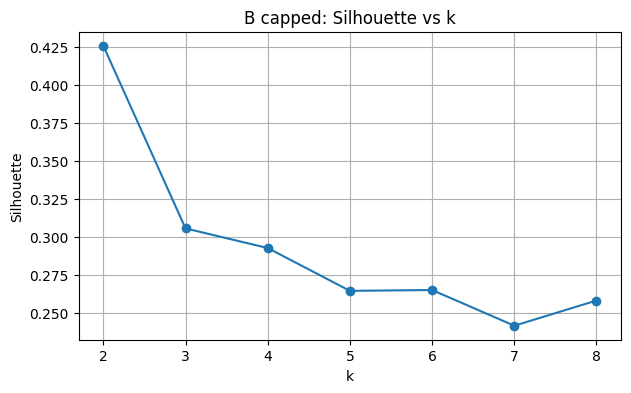

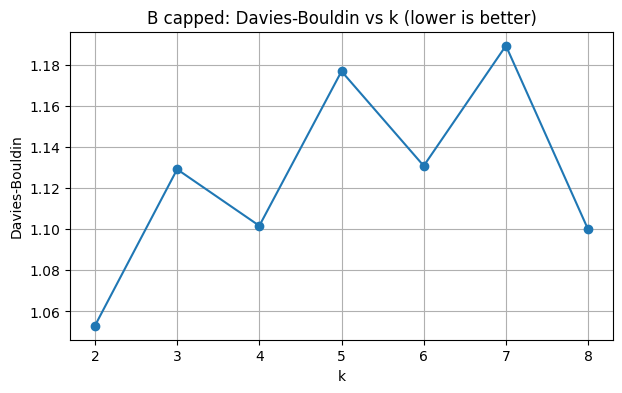

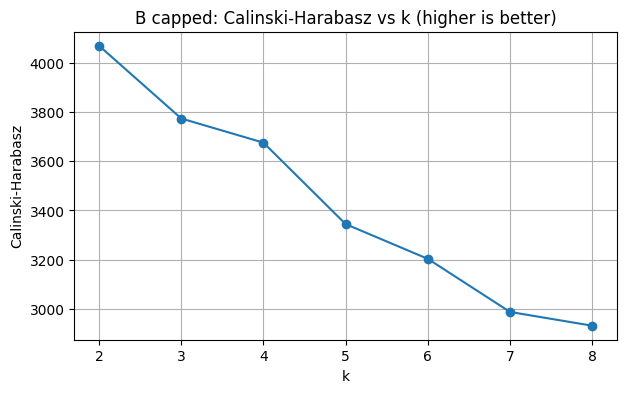

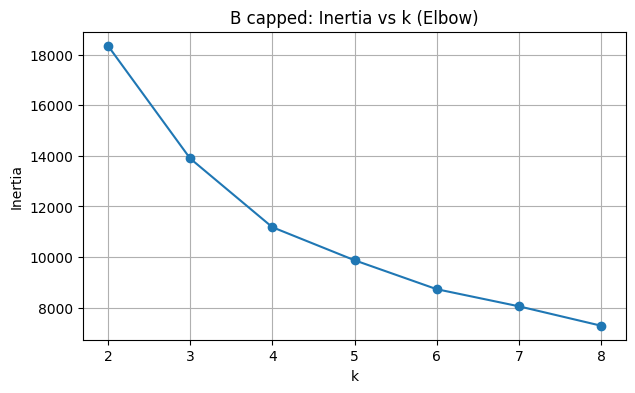

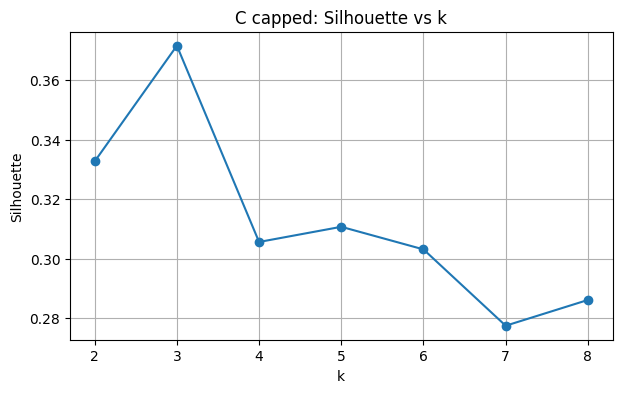

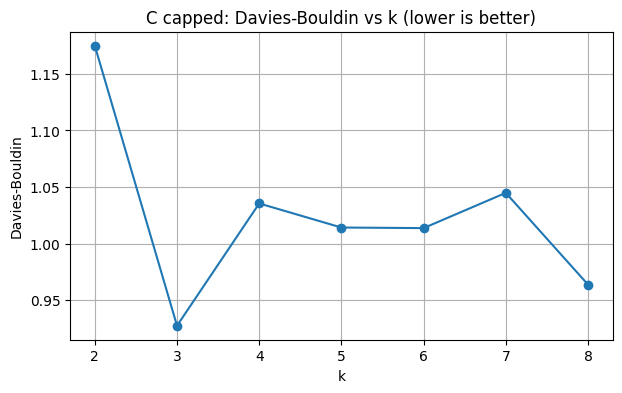

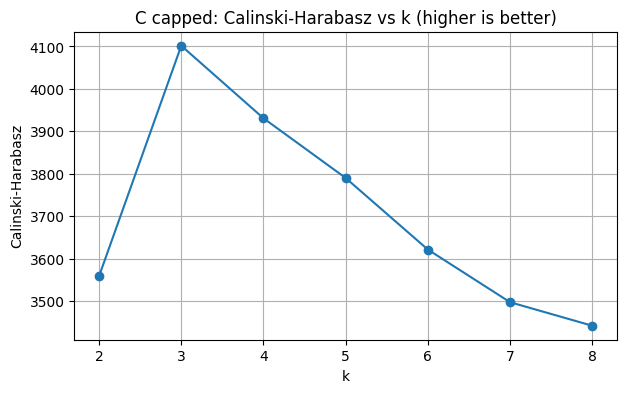

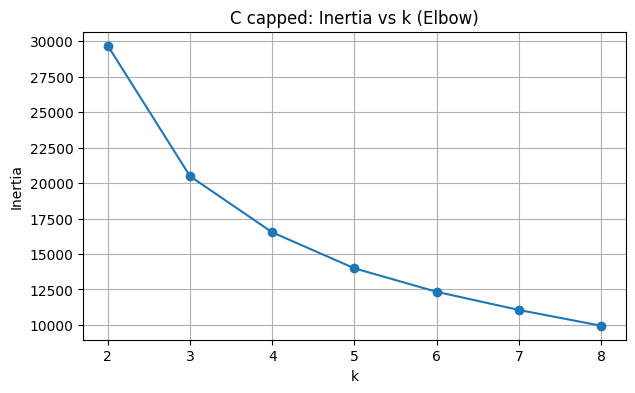

In [58]:
kmeans_eval_B_cap = kmeans_sweep(Z_B_cap, 2, 8)
kmeans_eval_C_cap = kmeans_sweep(Z_C_cap, 2, 8)

display(kmeans_eval_B_cap)
display(kmeans_eval_C_cap)

plot_kmeans_curves(kmeans_eval_B_cap, "B capped:")
plot_kmeans_curves(kmeans_eval_C_cap, "C capped:")

In [59]:
km_B_cap = KMeans(n_clusters=2, random_state=42, n_init="auto")
labels_B_cap = km_B_cap.fit_predict(Z_B_cap)

km_C_cap = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels_C_cap = km_C_cap.fit_predict(Z_C_cap)

print("Cluster counts B capped:")
display(pd.Series(labels_B_cap).value_counts().sort_index())

print("Cluster counts C capped:")
display(pd.Series(labels_C_cap).value_counts().sort_index())

Cluster counts B capped:


0    1509
1    5277
Name: count, dtype: int64

Cluster counts C capped:


0    1075
1    3529
2    2182
Name: count, dtype: int64

In [60]:
df_B_cap = df_cap.copy()
df_B_cap["cluster_B"] = labels_B_cap

df_C_cap = df_cap.copy()
df_C_cap["cluster_C"] = labels_C_cap

show_cluster_reps(df_B_cap, "cluster_B", top_n=8)
show_cluster_reps(df_C_cap, "cluster_C", top_n=8)


cluster_B = 0 | size = 1509

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  med_hours  log_hpp_avg  \
4304               Sheltered 2   3.99   67.866667  69.100000     2.850897   
4710               Greyfox RPG   1.99   71.900000   3.633333     2.850897   
256   FINAL FANTASY XIV Online  19.99  152.177500  98.169167     2.850897   
257             Cookie Clicker   4.99  152.177500  98.169167     2.850897   
5275         SKIBIDI BACKROOMS   0.55   11.083333  15.900000     2.850897   
5724                   Tametsi   2.99  140.066667  98.169167     2.850897   
5732                     懒人修仙传   3.99   67.650000  67.650000     2.850897   
221            Killing Floor 2   2.99  152.177500   6.783333     2.850897   

       log_rpp  pos_ratio_counts  owners_mid  reviews_total  
4304  6.150966          0.464775    150000.0         1868.0  
4710  6.703891          0.748904    750000.0         1621.0  
256   8.197268          0.879749   3500000.0        72564.0  
257   9.099473          0.966968   3500000.0        72493.0  
5275  7.808323          0.695960    150000.0         1353.0  
5724  5.967766          0.968569     35000.0         1165.0  
5732  5.677535          0.601251    350000.0         1162.0  
221   9.099473          0.877430   3500000.0        83309.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  \
4    Tom Clancy's Rainbow Six® Siege   3.99  152.177500  40.566667   
7                               Rust  39.99  152.177500  61.250000   
107                   Slay the Spire   8.49  110.216667  33.500000   
257                   Cookie Clicker   4.99  152.177500  98.169167   
163                     Metro Exodus   7.49   10.916667   1.783333   
141        Kingdom Come: Deliverance   7.49   44.733333  21.216667   
115                       Dead Cells  12.49   42.000000  18.966667   
131           Counter-Strike: Source   9.99   84.066667   4.250000   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
4       2.850897  9.099473          0.840690  35000000.0      1168020.0  
7       2.285791  9.099473          0.872679  35000000.0       993856.0  
107     2.637766  9.099473          0.978232   7500000.0       152746.0  
257     2.850897  9.099473          0.966968   3500000.0        72493.0  
163     0.899144  9.099473          0.000000     10000.0       102923.0  
141     1.941961  9.099473          0.838864   3500000.0       118635.0  
115     1.473089  9.099473          0.971044   7500000.0       140784.0  
131     2.242313  9.099473          0.962685  15000000.0       124438.0


cluster_B = 1 | size = 5277

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  \
879                           Company of Heroes 3  59.99  152.177500   
66                              Battlefield™ 2042  59.99  152.177500   
166                                NieR:Automata™  39.99  152.177500   
55                                DARK SOULS™ III  59.99  152.177500   
692                             Total War: ATTILA  44.99  130.766667   
523                   Men of War: Assault Squad 2  29.99   85.566667   
1725                        GUILTY GEAR Xrd REV 2  29.99   85.366667   
88    The Elder Scrolls V: Skyrim Special Edition  39.99  107.766667   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
879   21.883333     1.768951  5.724296          0.561880    750000.0   
66    14.416667     1.761295  8.249354          0.464837  15000000.0   
166   10.616667     1.668381  7.842617          0.869510   3500000.0   
55    29.383333     1.598285  8.368067          0.943118   7500000.0   
692   44.433333     1.362660  6.304549          0.820351   3500000.0   
523   12.033333     1.348897  7.022607          0.912729   3500000.0   
1725  26.216667     1.347165  5.530026          0.943098    350000.0   
88    23.366667     1.306937  8.431095          0.918720   7500000.0   

      reviews_total  
879         18310.0  
66         229411.0  
166        101809.0  
55         258335.0  
692         24567.0  
523         33610.0  
1725         7532.0  
88         183415.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  med_hours  \
14                       Cyberpunk 2077  59.99  83.216667  54.983333   
11             The Witcher 3: Wild Hunt  39.99  73.516667  15.450000   
49                           Subnautica  29.99  38.466667  26.083333   
400             Five Nights at Freddy's   4.99   3.516667   1.883333   
52                   Deep Rock Galactic  29.99  51.550000  13.466667   
204                       Hotline Miami   9.99   5.916667   4.983333   
275  Getting Over It with Bennett Foddy   7.99   6.783333   2.183333   
135                BattleBit Remastered  14.99  23.183333   8.233333   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
14      0.870111  9.099473          0.839452  35000000.0       729016.0  
11      1.043232  9.099473          0.961148  15000000.0       751939.0  
49      0.825337  9.099473          0.970143   3500000.0       276935.0  
400     0.533414  9.099473          0.934281   3500000.0        46210.0  
52      1.000230  9.096702          0.972617   7500000.0       267655.0  
204     0.465154  9.078997          0.971834   3500000.0        87594.0  
275     0.614633  9.061727          0.823904   3500000.0        68858.0  
135     0.934754  9.010725          0.859627   3500000.0       122760.0


cluster_C = 0 | size = 1075

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  \
30071                                 Time of Fury   0.99   78.283333   
2067                                    《蜀山：初章》买断版  24.99  152.177500   
1912                                Yokai's Secret   1.99  152.177500   
1886                  Mordheim: City of the Damned   1.99   33.216667   
1661                               NEKOPARA Vol. 4   4.99  152.177500   
1649                      Might & Magic: Heroes VI   2.49   61.216667   
29645  Tyd wag vir Niemand (Time waits for Nobody)   0.99   17.516667   
25338                                       Monsti   0.99   78.883333   

       med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
30071  78.283333     2.850897  3.747482          0.605263     75000.0   
2067   98.169167     2.850897  5.449030          0.743449    350000.0   
1912    1.333333     2.850897  8.091729          0.899462    350000.0   
1886   47.150000     2.850897  8.116039          0.702381    750000.0   
1661    2.033333     2.850897  7.382506          0.973626    350000.0   
1649   16.400000     2.850897  8.086285          0.475583    750000.0   
29645  17.983333     2.850897  3.771018          0.513514     35000.0   
25338   5.800000     2.850897  4.137023          0.614568    750000.0   

       reviews_total  
30071           41.0  
2067          5786.0  
1912          6500.0  
1886          6660.0  
1661          8017.0  
1649          8089.0  
29645           42.0  
25338           61.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  \
2037        LEWDAPOCALYPSE Hentai Evil   0.49    2.650000   2.816667   
1610                House of Detention   0.49    1.650000   0.916667   
447            Rising Storm 2: Vietnam   2.49   24.650000  17.316667   
651                    Blood and Bacon   0.49    4.116667   2.150000   
662                Tricolour Lovestory   0.59   27.516667   4.016667   
1064                   NEKOPARA Vol. 0   1.19  152.177500   1.266667   
1241  DR LIVESEY ROM AND DEATH EDITION   0.49    6.533333   0.433333   
1491                           Deponia   0.99    5.816667   4.600000   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
2037     1.857573  9.099473          0.000000     10000.0         5932.0  
1610     1.474156  9.099473          0.919101    350000.0         8313.0  
447      2.388726  9.099473          0.867649   3500000.0        39905.0  
651      2.240854  9.099473          0.952319   1500000.0        26329.0  
662      2.850897  9.099473          0.820340   1500000.0        25868.0  
1064     2.850897  9.099473          0.938740    750000.0        14425.0  
1241     2.662588  9.099473          0.946156    750000.0        11902.0  
1491     1.927953  9.099473          0.870262   1500000.0         9328.0


cluster_C = 1 | size = 3529

Top 8 by log_hpp_avg (time-per-price value)


name  price   avg_hours  \
35904                Planet Stronghold: Colonial Defense  19.99   64.350000   
12394       Atelier Meruru ~The Apprentice of Arland~ DX  39.99  126.633333   
18806                                        Polimines 2   9.99   24.350000   
16515                               Coloring Game: Girls  12.99   28.450000   
6826   RESONANCE OF FATE™/END OF ETERNITY™ 4K/HD EDITION  34.99   76.333333   
9184                                TransOcean 2: Rivals  19.99   43.200000   
12989                         Age of Gladiators II: Rome  19.99   41.250000   
14797                        Franchise Hockey Manager 10  19.99   40.766667   

       med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
35904  64.350000     1.439624  0.854703          0.756757     10000.0   
12394  98.169167     1.427106  2.063911          0.954386     10000.0   
18806  24.350000     1.234726  2.550368          0.870229     10000.0   
16515  28.450000     1.160067  2.547748          0.000000     10000.0   
6826   76.466667     1.157377  3.220292          0.802442     75000.0   
9184   43.200000     1.150914  3.233259          0.550225    150000.0   
12989  41.250000     1.119568  2.603153          0.677043     75000.0   
14797  40.766667     1.111645  2.361307          0.790000     10000.0   

       reviews_total  
35904           27.0  
12394          275.0  
18806          118.0  
16515          153.0  
6826           841.0  
9184           487.0  
12989          250.0  
14797          192.0


Top 8 by log_rpp (review-per-price value)


name  price  avg_hours  med_hours  \
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
5667                               Montaro RE   0.99   0.266667   0.266667   
4070                             Fantasy Girl   1.99   0.183333   0.200000   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
6585                              Seek Girl V   0.99   0.283333   0.366667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
6320     0.107054  7.408623          0.777480     35000.0          973.0  
4795     0.197912  7.367600          0.867655     75000.0         1567.0  
5291     0.225162  7.214935          0.824368     75000.0         1345.0  
8020     0.185717  7.150285          0.883721     10000.0          624.0  
5667     0.238513  7.085005          0.951331     75000.0         1181.0  
4070     0.088127  6.930112          0.953949    150000.0         2033.0  
7635     0.291299  6.900030          0.925620     10000.0          684.0  
6585     0.251688  6.810209          0.724211     75000.0          897.0


cluster_C = 2 | size = 2182

Top 8 by log_hpp_avg (time-per-price value)


name  price  avg_hours  med_hours  \
582                    Bright Memory   7.99   152.1775   1.133333   
424          NEEDY STREAMER OVERLOAD   6.39   152.1775   2.533333   
256         FINAL FANTASY XIV Online  19.99   152.1775  98.169167   
282              Company of Heroes 2   4.99   152.1775   5.050000   
221                  Killing Floor 2   2.99   152.1775   6.783333   
4    Tom Clancy's Rainbow Six® Siege   3.99   152.1775  40.566667   
8                        Garry's Mod   5.99   152.1775  19.550000   
26             ARK: Survival Evolved  14.99   152.1775  13.683333   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  
582     2.850897  8.223435          0.905897   1500000.0        29773.0  
424     2.850897  8.803240          0.948807   1500000.0        42524.0  
256     2.850897  8.197268          0.879749   3500000.0        72564.0  
282     2.850897  9.099473          0.789523   7500000.0        65780.0  
221     2.850897  9.099473          0.877430   3500000.0        83309.0  
4       2.850897  9.099473          0.840690  35000000.0      1168020.0  
8       2.850897  9.099473          0.967879  35000000.0       985010.0  
26      2.742610  9.099473          0.837360  35000000.0       542022.0


Top 8 by log_rpp (review-per-price value)


name  price   avg_hours  med_hours  log_hpp_avg  \
36          Hollow Knight  14.99   36.500000  17.266667     1.234004   
35          Geometry Dash   4.99   48.416667  11.133333     2.370500   
29               PAYDAY 2   9.99  115.550000   9.333333     2.531040   
27             The Forest  19.99   40.516667  12.666667     1.107521   
24       Dead by Daylight  19.99  152.177500  21.400000     2.504010   
26  ARK: Survival Evolved  14.99  152.177500  13.683333     2.742610   
20           Phasmophobia  19.99   38.600000  15.450000     1.075332   
16        Baldur's Gate 3  59.99  152.177500  95.200000     1.283135   

     log_rpp  pos_ratio_counts  owners_mid  reviews_total  
36  9.099473          0.970522  15000000.0       357036.0  
35  9.099473          0.934554   7500000.0       370690.0  
29  9.099473          0.896194  35000000.0       434886.0  
27  9.099473          0.955396  35000000.0       523900.0  
24  9.099473          0.790263  35000000.0       569165.0  
26  9.099473          0.837360  35000000.0       542022.0  
20  9.099473          0.958487  15000000.0       616505.0  
16  9.099473          0.968254  35000000.0       648637.0

In [61]:
def show_reps_by_score(df, cluster_col, top_n=8):
    df = df.copy()

    # simple interpretability score (not for modeling, just for reporting)
    df["rep_score"] = (
        0.5 * df["log_hpp_avg"] +
        0.3 * df["log_rpp"] +
        0.2 * df["pos_ratio_counts"]
    )

    for c in sorted(df[cluster_col].unique()):
        sub = df[df[cluster_col] == c].copy().sort_values("rep_score", ascending=False)
        print("\n==============================")
        print(f"{cluster_col} = {c} | size = {len(sub)}")
        print(f"Top {top_n} by rep_score (balanced value + review value + sentiment)")
        display(sub[[
            "name", "price", "avg_hours", "med_hours",
            "log_hpp_avg", "log_rpp", "pos_ratio_counts",
            "owners_mid", "reviews_total", "rep_score"
        ]].head(top_n))

show_reps_by_score(df_B_cap, "cluster_B", top_n=8)
show_reps_by_score(df_C_cap, "cluster_C", top_n=8)


cluster_B = 0 | size = 1509
Top 8 by rep_score (balanced value + review value + sentiment)


name  price   avg_hours  med_hours  \
248                            Mirror   0.79  138.900000   4.500000   
8                         Garry's Mod   5.99  152.177500  19.550000   
257                    Cookie Clicker   4.99  152.177500  98.169167   
1064                  NEKOPARA Vol. 0   1.19  152.177500   1.266667   
221                   Killing Floor 2   2.99  152.177500   6.783333   
420                 Age of History II   4.99  152.177500  57.233333   
4     Tom Clancy's Rainbow Six® Siege   3.99  152.177500  40.566667   
662               Tricolour Lovestory   0.59   27.516667   4.016667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
248      2.850897  9.099473          0.969207   3500000.0        73742.0   
8        2.850897  9.099473          0.967879  35000000.0       985010.0   
257      2.850897  9.099473          0.966968   3500000.0        72493.0   
1064     2.850897  9.099473          0.938740    750000.0        14425.0   
221      2.850897  9.099473          0.877430   3500000.0        83309.0   
420      2.850897  9.065465          0.897798   1500000.0        43165.0   
4        2.850897  9.099473          0.840690  35000000.0      1168020.0   
662      2.850897  9.099473          0.820340   1500000.0        25868.0   

      rep_score  
248    4.349132  
8      4.348866  
257    4.348684  
1064   4.343039  
221    4.330776  
420    4.324648  
4      4.323429  
662    4.319359


cluster_B = 1 | size = 5277
Top 8 by rep_score (balanced value + review value + sentiment)


name  price   avg_hours  \
55                               DARK SOULS™ III  59.99  152.177500   
81                              Cities: Skylines  29.99   73.433333   
66                             Battlefield™ 2042  59.99  152.177500   
11                      The Witcher 3: Wild Hunt  39.99   73.516667   
52                            Deep Rock Galactic  29.99   51.550000   
88   The Elder Scrolls V: Skyrim Special Edition  39.99  107.766667   
166                               NieR:Automata™  39.99  152.177500   
135                         BattleBit Remastered  14.99   23.183333   

     med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
55   29.383333     1.598285  8.368067          0.943118   7500000.0   
81   11.100000     1.237967  8.815431          0.930648  15000000.0   
66   14.416667     1.761295  8.249354          0.464837  15000000.0   
11   15.450000     1.043232  9.099473          0.961148  15000000.0   
52   13.466667     1.000230  9.096702          0.972617   7500000.0   
88   23.366667     1.306937  8.431095          0.918720   7500000.0   
166  10.616667     1.668381  7.842617          0.869510   3500000.0   
135   8.233333     0.934754  9.010725          0.859627   3500000.0   

     reviews_total  rep_score  
55        258335.0   3.498186  
81        202025.0   3.449742  
66        229411.0   3.448421  
11        751939.0   3.443688  
52        267655.0   3.423649  
88        183415.0   3.366541  
166       101809.0   3.360878  
135       122760.0   3.342520


cluster_C = 0 | size = 1075
Top 8 by rep_score (balanced value + review value + sentiment)


name  price   avg_hours  \
248                                            Mirror   0.79  138.900000   
257                                    Cookie Clicker   4.99  152.177500   
1064                                  NEKOPARA Vol. 0   1.19  152.177500   
420                                 Age of History II   4.99  152.177500   
662                               Tricolour Lovestory   0.59   27.516667   
1241                 DR LIVESEY ROM AND DEATH EDITION   0.49    6.533333   
3357                                            Barro   0.49   27.900000   
1090  Rocksmith® 2014 Edition REMASTERED LEARN & PLAY   2.99   50.550000   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
248    4.500000     2.850897  9.099473          0.969207   3500000.0   
257   98.169167     2.850897  9.099473          0.966968   3500000.0   
1064   1.266667     2.850897  9.099473          0.938740    750000.0   
420   57.233333     2.850897  9.065465          0.897798   1500000.0   
662    4.016667     2.850897  9.099473          0.820340   1500000.0   
1241   0.433333     2.662588  9.099473          0.946156    750000.0   
3357   0.066667     2.850897  8.635063          0.786153    350000.0   
1090   7.600000     2.850897  8.455886          0.891619   1500000.0   

      reviews_total  rep_score  
248         73742.0   4.349132  
257         72493.0   4.348684  
1064        14425.0   4.343039  
420         43165.0   4.324648  
662         25868.0   4.319359  
1241        11902.0   4.250367  
3357         2756.0   4.173198  
1090        14058.0   4.140538


cluster_C = 1 | size = 3529
Top 8 by rep_score (balanced value + review value + sentiment)


name  price  avg_hours  med_hours  \
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
5667                               Montaro RE   0.99   0.266667   0.266667   
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
3963                        The Cabin Factory   2.99   2.066667   2.516667   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
9762                             Boreal Blade   0.71   0.633333   0.183333   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
4795     0.197912  7.367600          0.867655     75000.0         1567.0   
5291     0.225162  7.214935          0.824368     75000.0         1345.0   
5667     0.238513  7.085005          0.951331     75000.0         1181.0   
6320     0.107054  7.408623          0.777480     35000.0          973.0   
3963     0.525434  6.571412          0.913250     10000.0         2133.0   
8020     0.185717  7.150285          0.883721     10000.0          624.0   
7635     0.291299  6.900030          0.925620     10000.0          684.0   
9762     0.637644  6.410244          0.641538     75000.0          431.0   

      rep_score  
4795   2.482767  
5291   2.441935  
5667   2.435024  
6320   2.431610  
3963   2.416791  
8020   2.414688  
7635   2.400782  
9762   2.370203


cluster_C = 2 | size = 2182
Top 8 by rep_score (balanced value + review value + sentiment)


name  price   avg_hours  med_hours  \
8                        Garry's Mod   5.99  152.177500  19.550000   
221                  Killing Floor 2   2.99  152.177500   6.783333   
4    Tom Clancy's Rainbow Six® Siege   3.99  152.177500  40.566667   
282              Company of Heroes 2   4.99  152.177500   5.050000   
26             ARK: Survival Evolved  14.99  152.177500  13.683333   
424          NEEDY STREAMER OVERLOAD   6.39  152.177500   2.533333   
200                          Brotato   2.99   39.800000  13.400000   
107                   Slay the Spire   8.49  110.216667  33.500000   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
8       2.850897  9.099473          0.967879  35000000.0       985010.0   
221     2.850897  9.099473          0.877430   3500000.0        83309.0   
4       2.850897  9.099473          0.840690  35000000.0      1168020.0   
282     2.850897  9.099473          0.789523   7500000.0        65780.0   
26      2.742610  9.099473          0.837360  35000000.0       542022.0   
424     2.850897  8.803240          0.948807   1500000.0        42524.0   
200     2.661031  9.099473          0.967345   3500000.0        89284.0   
107     2.637766  9.099473          0.978232   7500000.0       152746.0   

     rep_score  
8     4.348866  
221   4.330776  
4     4.323429  
282   4.313195  
26    4.268619  
424   4.256182  
200   4.253827  
107   4.244372

#Capping vs Dropping Outlier

capping vs dropping outlier rows with abnormal avg_hours for set b and c

In [63]:
features_B = ["log_hpp_avg","log_hpp_med","log_rpp","pos_ratio_counts","log_price"]
features_C = ["log_hpp_avg","log_hpp_med","log_rpp","pos_ratio_counts","log_owners","log_reviews","log_peak_ccu","log_price"]

def recompute_logs(df):
    df = df.copy()

    df["log_hpp_avg"] = np.log1p(df["hours_per_price_avg"])
    df["log_hpp_med"] = np.log1p(df["hours_per_price_med"])
    df["log_rpp"] = np.log1p(df["reviews_per_price"])

    df["log_price"] = np.log1p(df["price"])
    df["log_owners"] = np.log1p(df["owners_mid"])
    df["log_reviews"] = np.log1p(df["reviews_total"])
    df["log_peak_ccu"] = np.log1p(df["peak_ccu"])

    return df

In [64]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def run_pca_kmeans(X, k, n_components=3):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    Z = pca.fit_transform(Xs)

    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Z)

    metrics = {
        "k": k,
        "evr_total_3pc": float(pca.explained_variance_ratio_.sum()),
        "silhouette": float(silhouette_score(Z, labels)),
        "davies_bouldin": float(davies_bouldin_score(Z, labels)),
        "calinski_harabasz": float(calinski_harabasz_score(Z, labels)),
        "inertia": float(km.inertia_),
    }
    return Z, labels, metrics

In [65]:
outlier_cols = [
    "avg_hours", "med_hours",
    "hours_per_price_avg", "hours_per_price_med",
    "reviews_per_price",
    "reviews_per_owner"
]
outlier_cols = [c for c in outlier_cols if c in df_v.columns]

cutoffs_99 = {c: df_v[c].quantile(0.99) for c in outlier_cols}
cutoffs_99

{'avg_hours': np.float64(152.17749999999933),
 'med_hours': np.float64(98.16916666666606),
 'hours_per_price_avg': np.float64(16.303297215324594),
 'hours_per_price_med': np.float64(11.709837064108417),
 'reviews_per_price': np.float64(8949.576961895516),
 'reviews_per_owner': np.float64(0.1064493550644934)}

In [67]:
df_cap2 = df_v.copy()

for c, cap_val in cutoffs_99.items():
    df_cap2[c] = np.clip(df_cap2[c], None, cap_val)

df_cap2 = recompute_logs(df_cap2)

X_B_cap2 = df_cap2[features_B].copy()
X_C_cap2 = df_cap2[features_C].copy()

print("Cap pipeline shapes:", X_B_cap2.shape, X_C_cap2.shape)

Cap pipeline shapes: (6786, 5) (6786, 8)


In [68]:
df_rem = df_v.copy()

mask_ok = np.ones(len(df_rem), dtype=bool)
for c, cap_val in cutoffs_99.items():
    mask_ok &= (df_rem[c] <= cap_val)

df_rem2 = df_rem[mask_ok].copy()

print("Rows before removal:", len(df_v))
print("Rows after removal:", len(df_rem2))
print("Removed rows:", len(df_v) - len(df_rem2))

df_rem2 = recompute_logs(df_rem2)

X_B_rem2 = df_rem2[features_B].copy()
X_C_rem2 = df_rem2[features_C].copy()

print("Removal pipeline shapes:", X_B_rem2.shape, X_C_rem2.shape)

Rows before removal: 6786
Rows after removal: 6514
Removed rows: 272
Removal pipeline shapes: (6514, 5) (6514, 8)


In [69]:
#capping
Z_B_cap2, labels_B_cap2, m_B_cap2 = run_pca_kmeans(X_B_cap2, k=2, n_components=3)
Z_C_cap2, labels_C_cap2, m_C_cap2 = run_pca_kmeans(X_C_cap2, k=3, n_components=3)

#dropping
Z_B_rem2, labels_B_rem2, m_B_rem2 = run_pca_kmeans(X_B_rem2, k=2, n_components=3)
Z_C_rem2, labels_C_rem2, m_C_rem2 = run_pca_kmeans(X_C_rem2, k=3, n_components=3)

comparison = pd.DataFrame([
    {"pipeline":"CAP", "set":"B", **m_B_cap2},
    {"pipeline":"CAP", "set":"C", **m_C_cap2},
    {"pipeline":"REMOVE", "set":"B", **m_B_rem2},
    {"pipeline":"REMOVE", "set":"C", **m_C_rem2},
])

comparison

pipeline set  k  evr_total_3pc  silhouette  davies_bouldin  \
0      CAP   B  2       0.865110    0.425931        1.053028   
1      CAP   C  3       0.833715    0.371632        0.927461   
2   REMOVE   B  2       0.874003    0.420010        1.050046   
3   REMOVE   C  3       0.839776    0.372624        0.927700   

   calinski_harabasz       inertia  
0        4068.171014  18349.628515  
1        4101.821030  20485.223828  
2        3895.834854  17810.847664  
3        4126.436873  19299.760211

In [70]:
print("CAP B counts:")
display(pd.Series(labels_B_cap2).value_counts().sort_index())

print("CAP C counts:")
display(pd.Series(labels_C_cap2).value_counts().sort_index())

print("REMOVE B counts:")
display(pd.Series(labels_B_rem2).value_counts().sort_index())

print("REMOVE C counts:")
display(pd.Series(labels_C_rem2).value_counts().sort_index())

CAP B counts:


0    1509
1    5277
Name: count, dtype: int64

CAP C counts:


0    1075
1    3529
2    2182
Name: count, dtype: int64

REMOVE B counts:


0    5048
1    1466
Name: count, dtype: int64

REMOVE C counts:


0    3298
1    1067
2    2149
Name: count, dtype: int64

In [71]:
def show_reps_by_score(df, labels, cluster_name, top_n=8):
    tmp = df.copy()
    tmp[cluster_name] = labels

    # balanced reporting score (not a model feature)
    tmp["rep_score"] = (
        0.5 * tmp["log_hpp_avg"] +
        0.3 * tmp["log_rpp"] +
        0.2 * tmp["pos_ratio_counts"]
    )

    for c in sorted(tmp[cluster_name].unique()):
        sub = tmp[tmp[cluster_name] == c].sort_values("rep_score", ascending=False)
        print("\n==============================")
        print(f"{cluster_name} = {c} | size = {len(sub)}")
        display(sub[[
            "name","price","avg_hours","med_hours",
            "log_hpp_avg","log_rpp","pos_ratio_counts",
            "owners_mid","reviews_total","rep_score"
        ]].head(top_n))

# CAP reps
print("\n### CAP reps: B")
show_reps_by_score(df_cap2, labels_B_cap2, "cluster_B", top_n=8)

print("\n### CAP reps: C")
show_reps_by_score(df_cap2, labels_C_cap2, "cluster_C", top_n=8)

# REMOVE reps
print("\n### REMOVE reps: B")
show_reps_by_score(df_rem2, labels_B_rem2, "cluster_B", top_n=8)

print("\n### REMOVE reps: C")
show_reps_by_score(df_rem2, labels_C_rem2, "cluster_C", top_n=8)


### CAP reps: B

cluster_B = 0 | size = 1509


name  price   avg_hours  med_hours  \
248                            Mirror   0.79  138.900000   4.500000   
8                         Garry's Mod   5.99  152.177500  19.550000   
257                    Cookie Clicker   4.99  152.177500  98.169167   
1064                  NEKOPARA Vol. 0   1.19  152.177500   1.266667   
221                   Killing Floor 2   2.99  152.177500   6.783333   
420                 Age of History II   4.99  152.177500  57.233333   
4     Tom Clancy's Rainbow Six® Siege   3.99  152.177500  40.566667   
662               Tricolour Lovestory   0.59   27.516667   4.016667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
248      2.850897  9.099473          0.969207   3500000.0        73742.0   
8        2.850897  9.099473          0.967879  35000000.0       985010.0   
257      2.850897  9.099473          0.966968   3500000.0        72493.0   
1064     2.850897  9.099473          0.938740    750000.0        14425.0   
221      2.850897  9.099473          0.877430   3500000.0        83309.0   
420      2.850897  9.065465          0.897798   1500000.0        43165.0   
4        2.850897  9.099473          0.840690  35000000.0      1168020.0   
662      2.850897  9.099473          0.820340   1500000.0        25868.0   

      rep_score  
248    4.349132  
8      4.348866  
257    4.348684  
1064   4.343039  
221    4.330776  
420    4.324648  
4      4.323429  
662    4.319359


cluster_B = 1 | size = 5277


name  price   avg_hours  \
55                               DARK SOULS™ III  59.99  152.177500   
81                              Cities: Skylines  29.99   73.433333   
66                             Battlefield™ 2042  59.99  152.177500   
11                      The Witcher 3: Wild Hunt  39.99   73.516667   
52                            Deep Rock Galactic  29.99   51.550000   
88   The Elder Scrolls V: Skyrim Special Edition  39.99  107.766667   
166                               NieR:Automata™  39.99  152.177500   
135                         BattleBit Remastered  14.99   23.183333   

     med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
55   29.383333     1.598285  8.368067          0.943118   7500000.0   
81   11.100000     1.237967  8.815431          0.930648  15000000.0   
66   14.416667     1.761295  8.249354          0.464837  15000000.0   
11   15.450000     1.043232  9.099473          0.961148  15000000.0   
52   13.466667     1.000230  9.096702          0.972617   7500000.0   
88   23.366667     1.306937  8.431095          0.918720   7500000.0   
166  10.616667     1.668381  7.842617          0.869510   3500000.0   
135   8.233333     0.934754  9.010725          0.859627   3500000.0   

     reviews_total  rep_score  
55        258335.0   3.498186  
81        202025.0   3.449742  
66        229411.0   3.448421  
11        751939.0   3.443688  
52        267655.0   3.423649  
88        183415.0   3.366541  
166       101809.0   3.360878  
135       122760.0   3.342520


### CAP reps: C

cluster_C = 0 | size = 1075


name  price   avg_hours  \
248                                            Mirror   0.79  138.900000   
257                                    Cookie Clicker   4.99  152.177500   
1064                                  NEKOPARA Vol. 0   1.19  152.177500   
420                                 Age of History II   4.99  152.177500   
662                               Tricolour Lovestory   0.59   27.516667   
1241                 DR LIVESEY ROM AND DEATH EDITION   0.49    6.533333   
3357                                            Barro   0.49   27.900000   
1090  Rocksmith® 2014 Edition REMASTERED LEARN & PLAY   2.99   50.550000   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
248    4.500000     2.850897  9.099473          0.969207   3500000.0   
257   98.169167     2.850897  9.099473          0.966968   3500000.0   
1064   1.266667     2.850897  9.099473          0.938740    750000.0   
420   57.233333     2.850897  9.065465          0.897798   1500000.0   
662    4.016667     2.850897  9.099473          0.820340   1500000.0   
1241   0.433333     2.662588  9.099473          0.946156    750000.0   
3357   0.066667     2.850897  8.635063          0.786153    350000.0   
1090   7.600000     2.850897  8.455886          0.891619   1500000.0   

      reviews_total  rep_score  
248         73742.0   4.349132  
257         72493.0   4.348684  
1064        14425.0   4.343039  
420         43165.0   4.324648  
662         25868.0   4.319359  
1241        11902.0   4.250367  
3357         2756.0   4.173198  
1090        14058.0   4.140538


cluster_C = 1 | size = 3529


name  price  avg_hours  med_hours  \
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
5667                               Montaro RE   0.99   0.266667   0.266667   
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
3963                        The Cabin Factory   2.99   2.066667   2.516667   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
9762                             Boreal Blade   0.71   0.633333   0.183333   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
4795     0.197912  7.367600          0.867655     75000.0         1567.0   
5291     0.225162  7.214935          0.824368     75000.0         1345.0   
5667     0.238513  7.085005          0.951331     75000.0         1181.0   
6320     0.107054  7.408623          0.777480     35000.0          973.0   
3963     0.525434  6.571412          0.913250     10000.0         2133.0   
8020     0.185717  7.150285          0.883721     10000.0          624.0   
7635     0.291299  6.900030          0.925620     10000.0          684.0   
9762     0.637644  6.410244          0.641538     75000.0          431.0   

      rep_score  
4795   2.482767  
5291   2.441935  
5667   2.435024  
6320   2.431610  
3963   2.416791  
8020   2.414688  
7635   2.400782  
9762   2.370203


cluster_C = 2 | size = 2182


name  price   avg_hours  med_hours  \
8                        Garry's Mod   5.99  152.177500  19.550000   
221                  Killing Floor 2   2.99  152.177500   6.783333   
4    Tom Clancy's Rainbow Six® Siege   3.99  152.177500  40.566667   
282              Company of Heroes 2   4.99  152.177500   5.050000   
26             ARK: Survival Evolved  14.99  152.177500  13.683333   
424          NEEDY STREAMER OVERLOAD   6.39  152.177500   2.533333   
200                          Brotato   2.99   39.800000  13.400000   
107                   Slay the Spire   8.49  110.216667  33.500000   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
8       2.850897  9.099473          0.967879  35000000.0       985010.0   
221     2.850897  9.099473          0.877430   3500000.0        83309.0   
4       2.850897  9.099473          0.840690  35000000.0      1168020.0   
282     2.850897  9.099473          0.789523   7500000.0        65780.0   
26      2.742610  9.099473          0.837360  35000000.0       542022.0   
424     2.850897  8.803240          0.948807   1500000.0        42524.0   
200     2.661031  9.099473          0.967345   3500000.0        89284.0   
107     2.637766  9.099473          0.978232   7500000.0       152746.0   

     rep_score  
8     4.348866  
221   4.330776  
4     4.323429  
282   4.313195  
26    4.268619  
424   4.256182  
200   4.253827  
107   4.244372


### REMOVE reps: B

cluster_B = 0 | size = 5048


name  price  avg_hours  med_hours  \
81                     Cities: Skylines  29.99  73.433333  11.100000   
52                   Deep Rock Galactic  29.99  51.550000  13.466667   
87                         Satisfactory  39.99  77.933333  27.983333   
142                 Oxygen Not Included  24.99  40.616667  11.250000   
275  Getting Over It with Bennett Foddy   7.99   6.783333   2.183333   
102                             Cuphead  19.99  15.633333   7.100000   
280                      Papers, Please   9.99   8.966667   3.100000   
204                       Hotline Miami   9.99   5.916667   4.983333   

     log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
81      1.237967  8.815431          0.930648  15000000.0       202025.0   
52      1.000230  9.096702          0.972617   7500000.0       267655.0   
87      1.081405  8.463810          0.971121   7500000.0       189516.0   
142     0.965202  8.461607          0.967510   3500000.0       118169.0   
275     0.614633  9.061727          0.823904   3500000.0        68858.0   
102     0.577769  8.990611          0.963192   7500000.0       160447.0   
280     0.640571  8.803267          0.972659   3500000.0        66483.0   
204     0.465154  9.078997          0.971834   3500000.0        87594.0   

     rep_score  
81    3.449742  
52    3.423649  
87    3.274070  
142   3.214585  
275   3.190615  
102   3.178706  
280   3.155798  
204   3.150643


cluster_B = 1 | size = 1466


name  price   avg_hours  med_hours  \
3117               Initial Drift Online   0.99   15.900000   0.516667   
128           The Elder Scrolls® Online  19.99  123.350000  18.733333   
125              Mount & Blade: Warband  19.99  111.033333  26.800000   
2080          Bridge Constructor Portal   0.99    6.100000   3.950000   
609                   Far Cry® New Dawn   3.99   22.750000  20.533333   
2206                      Fox Hime Zero   0.59    2.466667   2.833333   
803                           Anno 1800   5.99   51.650000  24.500000   
1140  Warhammer: End Times - Vermintide   2.24   13.116667   6.200000   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
3117     2.836772  8.042082          0.783651    150000.0         3077.0   
128      1.969987  8.745394          0.815854   7500000.0       125551.0   
125      1.880143  8.780365          0.977302   7500000.0       130020.0   
2080     1.968736  8.661248          0.916306    350000.0         5716.0   
609      1.902369  8.870177          0.757718   1500000.0        28391.0   
2206     1.644958  9.095061          0.974290    350000.0         5257.0   
803      2.264125  8.123494          0.809859    750000.0        20197.0   
1140     1.925074  8.690414          0.800209   1500000.0        13316.0   

      rep_score  
3117   3.987741  
128    3.771783  
125    3.769642  
2080   3.766004  
609    3.763781  
2206   3.745855  
803    3.731083  
1140   3.729703


### REMOVE reps: C

cluster_C = 0 | size = 3298


name  price  avg_hours  med_hours  \
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
5667                               Montaro RE   0.99   0.266667   0.266667   
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
4719      The Adventures of Fei Duanmu 端木斐异闻录   2.39   1.350000   1.350000   
6585                              Seek Girl V   0.99   0.283333   0.366667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
4795     0.197912  7.367600          0.867655     75000.0         1567.0   
5291     0.225162  7.214935          0.824368     75000.0         1345.0   
5667     0.238513  7.085005          0.951331     75000.0         1181.0   
6320     0.107054  7.408623          0.777480     35000.0          973.0   
8020     0.185717  7.150285          0.883721     10000.0          624.0   
7635     0.291299  6.900030          0.925620     10000.0          684.0   
4719     0.447792  6.517894          0.900968     35000.0         1616.0   
6585     0.251688  6.810209          0.724211     75000.0          897.0   

      rep_score  
4795   2.482767  
5291   2.441935  
5667   2.435024  
6320   2.431610  
8020   2.414688  
7635   2.400782  
4719   2.359458  
6585   2.313749


cluster_C = 1 | size = 1067


name  price  avg_hours  med_hours  \
3117               Initial Drift Online   0.99  15.900000   0.516667   
2080          Bridge Constructor Portal   0.99   6.100000   3.950000   
609                   Far Cry® New Dawn   3.99  22.750000  20.533333   
2206                      Fox Hime Zero   0.59   2.466667   2.833333   
1140  Warhammer: End Times - Vermintide   2.24  13.116667   6.200000   
2630                            Erzurum   0.49   2.666667   2.350000   
2525                         Furry Love   0.49   2.833333   3.216667   
2771               RUSSIA BATTLEGROUNDS   0.49   1.866667   2.266667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
3117     2.836772  8.042082          0.783651    150000.0         3077.0   
2080     1.968736  8.661248          0.916306    350000.0         5716.0   
609      1.902369  8.870177          0.757718   1500000.0        28391.0   
2206     1.644958  9.095061          0.974290    350000.0         5257.0   
1140     1.925074  8.690414          0.800209   1500000.0        13316.0   
2630     1.862867  9.008521          0.398764    150000.0         4004.0   
2525     1.914318  9.075173          0.000000    350000.0         4280.0   
2771     1.570598  8.935767          0.771027    350000.0         3723.0   

      rep_score  
3117   3.987741  
2080   3.766004  
609    3.763781  
2206   3.745855  
1140   3.729703  
2630   3.713742  
2525   3.679711  
2771   3.620234


cluster_C = 2 | size = 2149


name  price   avg_hours  med_hours  log_hpp_avg  \
128  The Elder Scrolls® Online  19.99  123.350000  18.733333     1.969987   
125     Mount & Blade: Warband  19.99  111.033333  26.800000     1.880143   
803                  Anno 1800   5.99   51.650000  24.500000     2.264125   
59               7 Days to Die  29.24  107.616667  27.216667     1.543397   
176            Space Engineers  19.99  104.050000  14.166667     1.825372   
919              Day of Infamy   3.74   18.983333   2.933333     1.804307   
229              My Summer Car  14.99   59.816667  27.633333     1.607524   
234                The Crew™ 2   8.99   24.900000   3.266667     1.327007   

      log_rpp  pos_ratio_counts  owners_mid  reviews_total  rep_score  
128  8.745394          0.815854   7500000.0       125551.0   3.771783  
125  8.780365          0.977302   7500000.0       130020.0   3.769642  
803  8.123494          0.809859    750000.0        20197.0   3.731083  
59   9.049985          0.886018  15000000.0       249049.0   3.663897  
176  8.476621          0.885196   3500000.0        95956.0   3.632711  
919  8.449369          0.824991   1500000.0        17470.0   3.601962  
229  8.600337          0.945676   3500000.0        81433.0   3.572998  
234  9.091203          0.773984   3500000.0        79794.0   3.545661

#Trying to cluster again

In [76]:
df_final = df_rem2.copy()

features_C = [
    "log_hpp_avg", "log_hpp_med", "log_rpp", "pos_ratio_counts",
    "log_owners", "log_reviews", "log_peak_ccu", "log_price"
]

X_C = df_final[features_C].copy()

print("df_final:", df_final.shape)
print("X_C:", X_C.shape)
X_C.head()

df_final: (6514, 63)
X_C: (6514, 8)


log_hpp_avg  log_hpp_med   log_rpp  pos_ratio_counts  log_owners  \
52     1.000230     0.370900  9.096702          0.972617   15.830414   
59     1.543397     0.657936  9.049985          0.886018   16.523561   
60     1.175260     0.739508  8.314742          0.686343   18.132999   
67     0.549796     0.414738  8.248172          0.952945   16.523561   
69     0.489837     0.413637  8.228775          0.903792   16.523561   

    log_reviews  log_peak_ccu  log_price  
52    12.497458      9.359191   3.433665  
59    12.425409     10.143567   3.409166  
60    12.408679      9.251578   4.110710  
67    12.342093      8.457655   4.110710  
69    12.322691      9.227492   4.110710

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_C_scaled = scaler.fit_transform(X_C)

print("Scaled matrix shape:", X_C_scaled.shape)

Scaled matrix shape: (6514, 8)


In [74]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_hier = agg.fit_predict(Z_C_final)

df_final["cluster_hier"] = labels_hier
pd.Series(labels_hier).value_counts().sort_index()

0    4238
1    1469
2     807
Name: count, dtype: int64

In [78]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=3, random_state=42)
Z_C = pca.fit_transform(X_C_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total EVR (3 PCs):", pca.explained_variance_ratio_.sum())

Explained variance ratio: [0.43670346 0.29942478 0.10364799]
Total EVR (3 PCs): 0.8397762311289608


In [79]:
from sklearn.cluster import KMeans
import pandas as pd

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(Z_C)

df_final["cluster_kmeans"] = labels_km

print("KMeans cluster counts:")
display(pd.Series(labels_km).value_counts().sort_index())

KMeans cluster counts:


0    3298
1    1067
2    2149
Name: count, dtype: int64

In [80]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

sil_km = silhouette_score(Z_C, labels_km)
db_km = davies_bouldin_score(Z_C, labels_km)
ch_km = calinski_harabasz_score(Z_C, labels_km)

print("KMeans metrics (PCA space):")
print("Silhouette:", sil_km)
print("Davies-Bouldin:", db_km)
print("Calinski-Harabasz:", ch_km)
print("Inertia:", kmeans.inertia_)

KMeans metrics (PCA space):
Silhouette: 0.3726240771173022
Davies-Bouldin: 0.9277000381971647
Calinski-Harabasz: 4126.43687312918
Inertia: 19299.760211494293


In [81]:
from sklearn.cluster import AgglomerativeClustering

hier = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_hier = hier.fit_predict(Z_C)

df_final["cluster_hier"] = labels_hier

print("Hierarchical cluster counts:")
display(pd.Series(labels_hier).value_counts().sort_index())

Hierarchical cluster counts:


0    4238
1    1469
2     807
Name: count, dtype: int64

In [82]:
from sklearn.cluster import DBSCAN

def dbscan_sweep(Z, eps_values, min_samples=10):
    rows = []
    for eps in eps_values:
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(Z)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = float(np.mean(labels == -1))

        sil = np.nan
        if n_clusters >= 2:
            mask = labels != -1
            if mask.sum() > 20:
                sil = float(silhouette_score(Z[mask], labels[mask]))

        rows.append({
            "eps": eps,
            "min_samples": min_samples,
            "clusters": n_clusters,
            "noise_ratio": noise_ratio,
            "silhouette_non_noise": sil
        })
    return pd.DataFrame(rows)

eps_values = np.arange(0.2, 2.1, 0.1)
dbscan_results = dbscan_sweep(Z_C, eps_values, min_samples=10)

dbscan_results

eps  min_samples  clusters  noise_ratio  silhouette_non_noise
0   0.2           10        28     0.736414             -0.296333
1   0.3           10        17     0.362604             -0.096016
2   0.4           10         9     0.150906              0.003241
3   0.5           10         3     0.067547              0.271868
4   0.6           10         2     0.027479              0.357293
5   0.7           10         2     0.013816              0.347000
6   0.8           10         1     0.007676                   NaN
7   0.9           10         1     0.004145                   NaN
8   1.0           10         1     0.002917                   NaN
9   1.1           10         1     0.001842                   NaN
10  1.2           10         1     0.001075                   NaN
11  1.3           10         1     0.000768                   NaN
12  1.4           10         1     0.000614                   NaN
13  1.5           10         1     0.000614                   NaN
14  1.6           10         1     0.000614                   NaN
15  1.7           10         1     0.000461                   NaN
16  1.8           10         1     0.000461                   NaN
17  1.9           10         1     0.000461                   NaN
18  2.0           10         1     0.000307                   NaN

In [83]:
dbscan_results.sort_values(
    ["clusters", "silhouette_non_noise", "noise_ratio"],
    ascending=[False, False, True]
).head(15)

eps  min_samples  clusters  noise_ratio  silhouette_non_noise
0   0.2           10        28     0.736414             -0.296333
1   0.3           10        17     0.362604             -0.096016
2   0.4           10         9     0.150906              0.003241
3   0.5           10         3     0.067547              0.271868
4   0.6           10         2     0.027479              0.357293
5   0.7           10         2     0.013816              0.347000
18  2.0           10         1     0.000307                   NaN
15  1.7           10         1     0.000461                   NaN
16  1.8           10         1     0.000461                   NaN
17  1.9           10         1     0.000461                   NaN
12  1.4           10         1     0.000614                   NaN
13  1.5           10         1     0.000614                   NaN
14  1.6           10         1     0.000614                   NaN
11  1.3           10         1     0.000768                   NaN
10  1.2           10         1     0.001075                   NaN

In [84]:
BEST_EPS = 0.5

db = DBSCAN(eps=BEST_EPS, min_samples=10)
labels_db = db.fit_predict(Z_C)

df_final["cluster_dbscan"] = labels_db

print("DBSCAN cluster counts (noise=-1 included):")
display(pd.Series(labels_db).value_counts().sort_index())

print("Noise ratio:", float(np.mean(labels_db == -1)))

DBSCAN cluster counts (noise=-1 included):


-1     440
 0    5940
 1      22
 2     112
Name: count, dtype: int64

Noise ratio: 0.06754682222904514


In [85]:
def show_reps_by_score(df, cluster_col, top_n=8):
    tmp = df.copy()
    tmp["rep_score"] = (
        0.5 * tmp["log_hpp_avg"] +
        0.3 * tmp["log_rpp"] +
        0.2 * tmp["pos_ratio_counts"]
    )

    for c in sorted(tmp[cluster_col].unique()):
        sub = tmp[tmp[cluster_col] == c].sort_values("rep_score", ascending=False)
        print("\n==============================")
        print(f"{cluster_col} = {c} | size = {len(sub)}")
        display(sub[[
            "name","price","avg_hours","med_hours",
            "log_hpp_avg","log_rpp","pos_ratio_counts",
            "owners_mid","reviews_total","rep_score"
        ]].head(top_n))

print("=== KMEANS REPS ===")
show_reps_by_score(df_final, "cluster_kmeans", top_n=8)

print("=== HIERARCHICAL REPS ===")
show_reps_by_score(df_final, "cluster_hier", top_n=8)

print("=== DBSCAN REPS ===")
show_reps_by_score(df_final, "cluster_dbscan", top_n=8)

=== KMEANS REPS ===

cluster_kmeans = 0 | size = 3298


name  price  avg_hours  med_hours  \
4795                           ЕСТЬ ДВА СТУЛА   0.99   0.216667   0.216667   
5291                              G.O.P.O.T.A   0.99   0.250000   0.250000   
5667                               Montaro RE   0.99   0.266667   0.266667   
6320  СИМУЛЯТОР ОДИНОЧЕСТВА В РУССКОЙ ДЕРЕВНЕ   0.59   0.066667   0.066667   
8020                         Hentai Neighbors   0.49   0.100000   0.133333   
7635                   Cats Hidden in Georgia   0.69   0.233333   0.233333   
4719      The Adventures of Fei Duanmu 端木斐异闻录   2.39   1.350000   1.350000   
6585                              Seek Girl V   0.99   0.283333   0.366667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
4795     0.197912  7.367600          0.867655     75000.0         1567.0   
5291     0.225162  7.214935          0.824368     75000.0         1345.0   
5667     0.238513  7.085005          0.951331     75000.0         1181.0   
6320     0.107054  7.408623          0.777480     35000.0          973.0   
8020     0.185717  7.150285          0.883721     10000.0          624.0   
7635     0.291299  6.900030          0.925620     10000.0          684.0   
4719     0.447792  6.517894          0.900968     35000.0         1616.0   
6585     0.251688  6.810209          0.724211     75000.0          897.0   

      rep_score  
4795   2.482767  
5291   2.441935  
5667   2.435024  
6320   2.431610  
8020   2.414688  
7635   2.400782  
4719   2.359458  
6585   2.313749


cluster_kmeans = 1 | size = 1067


name  price  avg_hours  med_hours  \
3117               Initial Drift Online   0.99  15.900000   0.516667   
2080          Bridge Constructor Portal   0.99   6.100000   3.950000   
609                   Far Cry® New Dawn   3.99  22.750000  20.533333   
2206                      Fox Hime Zero   0.59   2.466667   2.833333   
1140  Warhammer: End Times - Vermintide   2.24  13.116667   6.200000   
2630                            Erzurum   0.49   2.666667   2.350000   
2525                         Furry Love   0.49   2.833333   3.216667   
2771               RUSSIA BATTLEGROUNDS   0.49   1.866667   2.266667   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
3117     2.836772  8.042082          0.783651    150000.0         3077.0   
2080     1.968736  8.661248          0.916306    350000.0         5716.0   
609      1.902369  8.870177          0.757718   1500000.0        28391.0   
2206     1.644958  9.095061          0.974290    350000.0         5257.0   
1140     1.925074  8.690414          0.800209   1500000.0        13316.0   
2630     1.862867  9.008521          0.398764    150000.0         4004.0   
2525     1.914318  9.075173          0.000000    350000.0         4280.0   
2771     1.570598  8.935767          0.771027    350000.0         3723.0   

      rep_score  
3117   3.987741  
2080   3.766004  
609    3.763781  
2206   3.745855  
1140   3.729703  
2630   3.713742  
2525   3.679711  
2771   3.620234


cluster_kmeans = 2 | size = 2149


name  price   avg_hours  med_hours  log_hpp_avg  \
128  The Elder Scrolls® Online  19.99  123.350000  18.733333     1.969987   
125     Mount & Blade: Warband  19.99  111.033333  26.800000     1.880143   
803                  Anno 1800   5.99   51.650000  24.500000     2.264125   
59               7 Days to Die  29.24  107.616667  27.216667     1.543397   
176            Space Engineers  19.99  104.050000  14.166667     1.825372   
919              Day of Infamy   3.74   18.983333   2.933333     1.804307   
229              My Summer Car  14.99   59.816667  27.633333     1.607524   
234                The Crew™ 2   8.99   24.900000   3.266667     1.327007   

      log_rpp  pos_ratio_counts  owners_mid  reviews_total  rep_score  
128  8.745394          0.815854   7500000.0       125551.0   3.771783  
125  8.780365          0.977302   7500000.0       130020.0   3.769642  
803  8.123494          0.809859    750000.0        20197.0   3.731083  
59   9.049985          0.886018  15000000.0       249049.0   3.663897  
176  8.476621          0.885196   3500000.0        95956.0   3.632711  
919  8.449369          0.824991   1500000.0        17470.0   3.601962  
229  8.600337          0.945676   3500000.0        81433.0   3.572998  
234  9.091203          0.773984   3500000.0        79794.0   3.545661

=== HIERARCHICAL REPS ===

cluster_hier = 0 | size = 4238


name  price  avg_hours  med_hours  \
3710                              Seek Girl Ⅱ   0.49   0.133333   0.166667   
672                                Stacklands   7.99   6.750000   4.300000   
3374                                 Wet Girl   0.99   0.366667   0.366667   
3299                                   Zup! 4   1.99   1.316667   1.550000   
4396  Sakuya Izayoi Gives You Advice And Dabs   0.69   0.033333   0.033333   
2808                                 OutDrive   2.99   2.283333   2.216667   
4049                         I hate this game   1.99   1.366667   1.366667   
3415                                Half Dead   1.99   0.916667   0.683333   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
3710     0.240676  8.487991          0.813208    150000.0         2379.0   
672      0.612374  8.063762          0.000000    750000.0        25378.0   
3374     0.315081  7.924664          0.862666    350000.0         2736.0   
3299     0.507806  7.255999          0.903108    350000.0         2817.0   
4396     0.047179  7.873079          0.976021     75000.0         1811.0   
2808     0.567389  7.106384          0.759065    350000.0         3644.0   
4049     0.522814  6.939405          0.928962    150000.0         2052.0   
3415     0.378872  7.205434          0.782490    350000.0         2678.0   

      rep_score  
3710   2.829377  
672    2.725316  
3374   2.707473  
3299   2.611324  
4396   2.580717  
2808   2.567423  
4049   2.529021  
3415   2.507564


cluster_hier = 1 | size = 1469


name  price   avg_hours  med_hours  \
128           The Elder Scrolls® Online  19.99  123.350000  18.733333   
125              Mount & Blade: Warband  19.99  111.033333  26.800000   
609                   Far Cry® New Dawn   3.99   22.750000  20.533333   
803                           Anno 1800   5.99   51.650000  24.500000   
1140  Warhammer: End Times - Vermintide   2.24   13.116667   6.200000   
59                        7 Days to Die  29.24  107.616667  27.216667   
176                     Space Engineers  19.99  104.050000  14.166667   
919                       Day of Infamy   3.74   18.983333   2.933333   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
128      1.969987  8.745394          0.815854   7500000.0       125551.0   
125      1.880143  8.780365          0.977302   7500000.0       130020.0   
609      1.902369  8.870177          0.757718   1500000.0        28391.0   
803      2.264125  8.123494          0.809859    750000.0        20197.0   
1140     1.925074  8.690414          0.800209   1500000.0        13316.0   
59       1.543397  9.049985          0.886018  15000000.0       249049.0   
176      1.825372  8.476621          0.885196   3500000.0        95956.0   
919      1.804307  8.449369          0.824991   1500000.0        17470.0   

      rep_score  
128    3.771783  
125    3.769642  
609    3.763781  
803    3.731083  
1140   3.729703  
59     3.663897  
176    3.632711  
919    3.601962


cluster_hier = 2 | size = 807


name  price  avg_hours  med_hours  log_hpp_avg  \
3117       Initial Drift Online   0.99  15.900000   0.516667     2.836772   
2080  Bridge Constructor Portal   0.99   6.100000   3.950000     1.968736   
2206              Fox Hime Zero   0.59   2.466667   2.833333     1.644958   
2630                    Erzurum   0.49   2.666667   2.350000     1.862867   
2525                 Furry Love   0.49   2.833333   3.216667     1.914318   
2771       RUSSIA BATTLEGROUNDS   0.49   1.866667   2.266667     1.570598   
1593                  Timberman   0.99   3.150000   1.933333     1.430746   
2656      Cats Organized Neatly   1.49  10.516667   3.616667     2.086686   

       log_rpp  pos_ratio_counts  owners_mid  reviews_total  rep_score  
3117  8.042082          0.783651    150000.0         3077.0   3.987741  
2080  8.661248          0.916306    350000.0         5716.0   3.766004  
2206  9.095061          0.974290    350000.0         5257.0   3.745855  
2630  9.008521          0.398764    150000.0         4004.0   3.713742  
2525  9.075173          0.000000    350000.0         4280.0   3.679711  
2771  8.935767          0.771027    350000.0         3723.0   3.620234  
1593  9.051142          0.931723    750000.0         8442.0   3.617060  
2656  7.880030          0.975853    150000.0         3938.0   3.602523

=== DBSCAN REPS ===

cluster_dbscan = -1 | size = 440


name  price   avg_hours  med_hours  \
128           The Elder Scrolls® Online  19.99  123.350000  18.733333   
125              Mount & Blade: Warband  19.99  111.033333  26.800000   
2080          Bridge Constructor Portal   0.99    6.100000   3.950000   
609                   Far Cry® New Dawn   3.99   22.750000  20.533333   
2206                      Fox Hime Zero   0.59    2.466667   2.833333   
803                           Anno 1800   5.99   51.650000  24.500000   
1140  Warhammer: End Times - Vermintide   2.24   13.116667   6.200000   
2630                            Erzurum   0.49    2.666667   2.350000   

      log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
128      1.969987  8.745394          0.815854   7500000.0       125551.0   
125      1.880143  8.780365          0.977302   7500000.0       130020.0   
2080     1.968736  8.661248          0.916306    350000.0         5716.0   
609      1.902369  8.870177          0.757718   1500000.0        28391.0   
2206     1.644958  9.095061          0.974290    350000.0         5257.0   
803      2.264125  8.123494          0.809859    750000.0        20197.0   
1140     1.925074  8.690414          0.800209   1500000.0        13316.0   
2630     1.862867  9.008521          0.398764    150000.0         4004.0   

      rep_score  
128    3.771783  
125    3.769642  
2080   3.766004  
609    3.763781  
2206   3.745855  
803    3.731083  
1140   3.729703  
2630   3.713742


cluster_dbscan = 0 | size = 5940


name  price  avg_hours  \
919                                       Day of Infamy   3.74  18.983333   
264                                                GRIS  14.99  60.300000   
709                     Titan Quest Anniversary Edition   4.99  16.866667   
2642                             Soccer Online: Ball 3D   0.99   3.900000   
1807  Shower With Your Dad Simulator 2015: Do You St...   0.99   1.933333   
670                            Your Only Move Is HUSTLE   4.99  11.550000   
135                                BattleBit Remastered  14.99  23.183333   
1548                 WRC 7 FIA World Rally Championship   1.99   5.233333   

      med_hours  log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  \
919    2.933333     1.804307  8.449369          0.824991   1500000.0   
264    2.600000     1.613964  8.460443          0.964126   1500000.0   
709    4.316667     1.477070  8.474658          0.910460   1500000.0   
2642   1.300000     1.597243  8.297828          0.844885   1500000.0   
1807   0.133333     1.082775  8.884077          0.953316     75000.0   
670    5.950000     1.198346  8.537742          0.963679   1500000.0   
135    8.233333     0.934754  9.010725          0.859627   3500000.0   
1548   1.166667     1.289182  8.405109          0.808907    750000.0   

      reviews_total  rep_score  
919         17470.0   3.601962  
264         70800.0   3.537940  
709         23906.0   3.463024  
2642         3974.0   3.456947  
1807         7143.0   3.397274  
670         25463.0   3.353231  
135        122760.0   3.342520  
1548         8893.0   3.327905


cluster_dbscan = 1 | size = 22


name  price  avg_hours  med_hours  log_hpp_avg  \
3117           Initial Drift Online   0.99  15.900000   0.516667     2.836772   
2771           RUSSIA BATTLEGROUNDS   0.49   1.866667   2.266667     1.570598   
2656          Cats Organized Neatly   1.49  10.516667   3.616667     2.086686   
1687                    The Vagrant   1.19   4.316667   5.883333     1.532006   
3149                   Timberman VS   0.77   4.000000   3.100000     1.823711   
2139                 Bit Blaster XL   0.99   3.550000   3.566667     1.522977   
3085                      SIMULACRA   0.99   4.666667   5.316667     1.742885   
3386  CASE 2: Animatronics Survival   1.19   6.916667   7.516667     1.918733   

       log_rpp  pos_ratio_counts  owners_mid  reviews_total  rep_score  
3117  8.042082          0.783651    150000.0         3077.0   3.987741  
2771  8.935767          0.771027    350000.0         3723.0   3.620234  
2656  7.880030          0.975853    150000.0         3938.0   3.602523  
1687  8.786667          0.898214    350000.0         7789.0   3.581646  
3149  8.273307          0.913717    350000.0         3016.0   3.576591  
2139  8.620003          0.964507    350000.0         5485.0   3.540391  
3085  8.061707          0.906809    350000.0         3138.0   3.471316  
3386  7.733400          0.819949    150000.0         2716.0   3.443377


cluster_dbscan = 2 | size = 112


name  price  avg_hours  med_hours  \
10935                   Innocent Girl   0.55   0.266667   0.266667   
12486                       Neko Neko   0.49   0.133333   0.133333   
8629                Furry Aim Trainer   0.99   0.183333   0.183333   
7419   Gamer Girls [18+]: eSports SEX   1.99   1.000000   1.216667   
10100                   Steamy Sextet   2.09   1.516667   1.516667   
7377              Furry Shades of Gay   6.99   8.616667   8.616667   
10865           The Book of Bondmaids   3.14   2.783333   3.216667   
8088           Hentai Mosaique Puzzle   1.99   0.050000   0.050000   

       log_hpp_avg   log_rpp  pos_ratio_counts  owners_mid  reviews_total  \
10935     0.395313  6.451619               0.0     10000.0          348.0   
12486     0.240676  6.317275               0.0     10000.0          271.0   
8629      0.169899  6.319950               0.0     10000.0          549.0   
7419      0.407139  5.899402               0.0     10000.0          724.0   
10100     0.545620  5.271870               0.0     10000.0          405.0   
7377      0.803218  4.656736               0.0     10000.0          729.0   
10865     0.634677  4.731101               0.0     10000.0          353.0   
8088      0.024815  5.739954               0.0     10000.0          617.0   

       rep_score  
10935   2.133142  
12486   2.015521  
8629    1.980935  
7419    1.973390  
10100   1.854371  
7377    1.798630  
10865   1.736669  
8088    1.734394

In [92]:
#outlier games removed
removed = df_v[~df_v["appid"].isin(df_rem2["appid"])].copy()

print("Removed rows:", removed.shape[0])
removed[["name","price","average_playtime_forever","median_playtime_forever","num_reviews_total","owners_mid"]].head(20)

# Define the cap values from the existing cutoffs_99 dictionary
avg_hours_cap = cutoffs_99["avg_hours"]
med_hours_cap = cutoffs_99["med_hours"]
hpp_avg_cap = cutoffs_99["hours_per_price_avg"]
hpp_med_cap = cutoffs_99["hours_per_price_med"]
rpp_cap = cutoffs_99["reviews_per_price"]
rpo_cap = cutoffs_99["reviews_per_owner"]

thresholds = {
    "avg_hours": avg_hours_cap,
    "med_hours": med_hours_cap,
    "hours_per_price_avg": hpp_avg_cap,
    "hours_per_price_med": hpp_med_cap,
    "reviews_per_price": rpp_cap,
    "reviews_per_owner": rpo_cap
}

# The 'removed' DataFrame is already correctly created from df_v and df_rem2 above.
# The following line was incorrect and has been removed.
# removed = df_paid[~df_paid["id"].isin(df_paid_clean["id"])].copy()

# compute the features that were used in filtering
# These columns already exist in 'removed' as it's a subset of df_v.
# We are recomputing them here for clarity, but it's not strictly necessary.
removed["avg_hours"] = removed["average_playtime_forever"] / 60
removed["med_hours"] = removed["median_playtime_forever"] / 60
removed["hours_per_price_avg"] = removed["avg_hours"] / removed["price"]
removed["hours_per_price_med"] = removed["med_hours"] / removed["price"]
removed["reviews_per_price"] = removed["num_reviews_total"] / removed["price"]
removed["reviews_per_owner"] = removed["reviews_total"] / (removed["owners_mid"] + 1)

# flag each threshold
for col, cap in thresholds.items():
    removed[f"flag_{col}"] = removed[col] > cap

# count how many flags per game
flag_cols = [c for c in removed.columns if c.startswith("flag_")]
removed["num_flags"] = removed[flag_cols].sum(axis=1)

# show the most extreme removed games
removed_sorted = removed.sort_values(["num_flags","avg_hours","reviews_per_price"], ascending=False)

removed_sorted[
    ["name","price","avg_hours","med_hours","hours_per_price_avg","reviews_per_price","reviews_per_owner","num_flags"] + flag_cols
].head(30)

Removed rows: 272


name  price     avg_hours     med_hours  \
257                     Cookie Clicker   4.99    308.700000    100.066667   
15124         LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
8280                   Hatsune Miku VR  24.99  16530.616667  16530.616667   
6811       A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
8582                  Darkness Assault   0.99   8890.700000  17777.850000   
11851       LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   
5663                Hiveswap Friendsim   2.59    726.700000    726.700000   
21008                   BuildMoreCubes   4.99    721.383333   1437.633333   
2067                        《蜀山：初章》买断版  24.99    578.150000    630.500000   
10162                    Masked Forces   0.99    543.966667   1086.816667   
12533             3D Custom Lady Maker   4.99    457.500000    457.500000   
6702                            SAELIG  14.99    257.883333    257.883333   
7940    Poker Quest: Swords and Spades  14.99    250.816667    250.816667   
5928                       Increlution   3.99    249.833333    305.916667   
1158                       Melvor Idle   9.99    247.533333    146.766667   
14607     秘封旅行 ~ Secret Sealing Travel   5.99    234.266667    234.266667   
3634                 Ancient Warfare 3  12.99    214.550000    214.550000   
8891       放置勇者：远征/Idle Heroes:Odyssey   9.99    207.166667    207.166667   
4910                     Cavalry Girls   9.99    199.250000    294.516667   
23469                   ZM Desktop Elf   3.51    181.650000    363.133333   
5821              Ropuka's Idle Island   3.99    142.383333    142.383333   
256           FINAL FANTASY XIV Online  19.99    837.650000    120.983333   
1064                   NEKOPARA Vol. 0   1.19    610.800000      1.266667   
221                    Killing Floor 2   2.99    546.233333      6.783333   
3896                     Feed the Cups  15.99    239.566667    345.266667   
4      Tom Clancy's Rainbow Six® Siege   3.99    236.733333     40.566667   
282                Company of Heroes 2   4.99    215.783333      5.050000   
8                          Garry's Mod   5.99    183.116667     19.550000   
14242   Heroes of the Three Kingdoms 5   3.99    149.500000    224.183333   
5724                           Tametsi   2.99    140.066667    245.250000   

       hours_per_price_avg  reviews_per_price  reviews_per_owner  num_flags  \
257              61.863727       14527.655311           0.020712          5   
15124          5370.767254          40.528634           0.005257          4   
8280            661.489262          23.689476           0.007893          4   
6811           2702.082405         188.195991           0.024142          4   
8582           8980.505051         559.595960           0.001583          4   
11851          2347.310167         116.602317           0.008628          4   
5663            280.579151         456.370656           0.015760          4   
21008           144.565798          18.637275           0.002657          4   
2067             23.135254         231.532613           0.016531          4   
10162           549.461279         405.050505           0.005347          4   
12533            91.683367          53.907816           0.007685          4   
6702             17.203691          57.838559           0.011560          4   
7940             16.732266          42.428286           0.063594          4   
5928             62.614871         274.185464           0.007293          4   
1158             24.778111        1290.790791           0.017193          4   
14607            39.109627          32.888147           0.019698          4   
3634             16.516551         188.683603           0.016340          4   
8891             20.737404          51.751752           0.006893          4   
4910             19.944945         150.750751           0.010040          4   
23469            51.752137          20.797721           0.007299  

#Removing games with suspicious playtime inflation/unstable stats
high avg playtime, but low engagement

In [119]:
df_work = df_paid.copy()

print("df_work shape:", df_work.shape)
df_work.head()

df_work shape: (6786, 48)


appid                             name release_date  required_age  \
4    359550  Tom Clancy's Rainbow Six® Siege   2015-12-01          17.0   
7    252490                             Rust   2018-02-08           0.0   
8      4000                      Garry's Mod   2006-11-29           0.0   
11   292030         The Witcher 3: Wild Hunt   2015-05-18          17.0   
12  1245620                       ELDEN RING   2022-02-24          16.0   

    price  dlc_count                               detailed_description  \
4    3.99          9  Edition Comparison Ultimate Edition The Tom Cl...   
7   39.99          4  The only aim in Rust is to survive. Everything...   
8    5.99          0  Garry's Mod is a physics sandbox. There aren't...   
11  39.99         22  DISCOVER THE STORY BEFORE THE WITCHER IV About...   
12  59.99          2  ELDEN RING Shadow of the Erdtree Edition ELDEN...   

                                       about_the_game  \
4   “One of the best first-person shooters ever ma...   
7   The only aim in Rust is to survive. Everything...   
8   Garry's Mod is a physics sandbox. There aren't...   
11  One of the most acclaimed RPGs of all time. No...   
12  THE CRITICALLY ACCLAIMED FANTASY ACTION RPG Ri...   

                                    short_description  \
4   Tom Clancy's Rainbow Six® Siege is an elite, t...   
7   The only aim in Rust is to survive. Everything...   
8   Garry's Mod is a physics sandbox. There aren't...   
11  You are Geralt of Rivia, mercenary monster sla...   
12  THE CRITICALLY ACCLAIMED FANTASY ACTION RPG. R...   

                                              reviews  ...  \
4                                                 NaN  ...   
7   “Rust is one of the cruelest games on Steam, a...  ...   
8   “It brings back the silly glee of unbridled ex...  ...   
11  “ONE OF THE BEST GAMES EVER MADE” 10/10 – Game...  ...   
12  “Put a ring on it.” 10/10 – IGN “An unmissable...  ...   

   median_playtime_forever median_playtime_2weeks discount peak_ccu  \
4                     2434                    306       80    89916   
7                     3675                    231        0   200902   
8                     1173                    136       40    32384   
11                     927                    184        0    15129   
12                    5675                    464        0    46121   

                                                 tags  pct_pos_total  \
4   {'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...           84.0   
7   {'Survival': 18592, 'Crafting': 11822, 'Multip...           87.0   
8   {'Sandbox': 18706, 'Moddable': 14479, 'Multipl...           96.0   
11  {'Open World': 12704, 'RPG': 10744, 'Story Ric...           96.0   
12  {'Souls-like': 6823, 'Open World': 4941, 'Dark...           92.0   

    num_reviews_total  pct_pos_recent num_reviews_recent  owners_mid  
4           1168020.0            76.0            12608.0  35000000.0  
7            993856.0            87.0            14960.0  35000000.0  
8            985010.0            96.0             8277.0  35000000.0  
11           751939.0            95.0             4228.0  15000000.0  
12           749606.0            93.0             6753.0  35000000.0  

[5 rows x 48 columns]

In [120]:
# Convert minutes -> hours
df_work["avg_hours"] = df_work["average_playtime_forever"] / 60.0
df_work["med_hours"] = df_work["median_playtime_forever"] / 60.0

# Ensure review counts exist and are numeric
df_work["reviews_total"] = pd.to_numeric(df_work["num_reviews_total"], errors="coerce").fillna(0)

# Owners midpoint (only compute if not already present)
if "owners_mid" not in df_work.columns:
    def parse_mid(x):
        if pd.isna(x):
            return np.nan
        s = str(x).replace(",", "").strip()
        if "-" in s:
            a, b = s.split("-")
            return (float(a.strip()) + float(b.strip())) / 2.0
        return float(s)

    df_work["owners_mid"] = df_work["estimated_owners"].apply(parse_mid)

df_work["owners_mid"] = pd.to_numeric(df_work["owners_mid"], errors="coerce")

print("NaNs check:")
print("avg_hours NaNs:", df_work["avg_hours"].isna().sum())
print("reviews_total NaNs:", df_work["reviews_total"].isna().sum())
print("owners_mid NaNs:", df_work["owners_mid"].isna().sum())

NaNs check:
avg_hours NaNs: 0
reviews_total NaNs: 0
owners_mid NaNs: 0


In [177]:
AVG_HOURS_THRESHOLD = 1000
REV_LOW = 1000
OWN_LOW = 50000

mask_high_hours = df_work["avg_hours"] > AVG_HOURS_THRESHOLD

# Low engagement: you can choose OR or AND.
# OR = stricter removal (more removed)
mask_low_engagement = (df_work["reviews_total"] <= REV_LOW) | (df_work["owners_mid"] <= OWN_LOW)

mask_suspicious = mask_high_hours & mask_low_engagement

print("High-hours games (avg_hours > 1000):", int(mask_high_hours.sum()))
print("Suspicious high-hours + low-engagement:", int(mask_suspicious.sum()))
print("Total rows:", df_work.shape[0])

High-hours games (avg_hours > 1000): 4
Suspicious high-hours + low-engagement: 0
Total rows: 6781


In [131]:
cols_to_show = [
    "appid", "name", "price",
    "avg_hours", "med_hours",
    "owners_mid", "reviews_total",
    "positive", "negative", "peak_ccu"
]

# Keep only columns that actually exist (prevents KeyError)
cols_existing = [c for c in cols_to_show if c in df_work.columns]

df_suspicious = df_work.loc[mask_suspicious, cols_existing].copy()

df_suspicious = df_suspicious.sort_values(
    by=["avg_hours", "reviews_total"],
    ascending=[False, True]
)

print("Suspicious games table shape:", df_suspicious.shape)
df_suspicious.head()

Suspicious games table shape: (5, 10)


appid                         name  price     avg_hours     med_hours  \
15124  938270     LoveKami -Healing Harem-   4.54  24383.283333  24383.283333   
8280   707300              Hatsune Miku VR  24.99  16530.616667  16530.616667   
6811   745960  A Sky Full of Stars 仰望夜空的星辰   4.49  12132.350000  24264.016667   
8582   332790             Darkness Assault   0.99   8890.700000  17777.850000   
11851  626510   LoveKami -Useless Goddess-   2.59   6079.533333  12157.616667   

       owners_mid  reviews_total  positive  negative  peak_ccu  
15124     35000.0          184.0       176        36         1  
8280      75000.0          592.0       458       179         1  
6811      35000.0          845.0       890        28         5  
8582     350000.0          554.0       344       309         0  
11851     35000.0          302.0       335        82         0

In [132]:
rows_before = df_work.shape[0]
df_clean = df_work.loc[~mask_suspicious].copy()
rows_after = df_clean.shape[0]

print("Rows before:", rows_before)
print("Rows after :", rows_after)
print("Removed    :", rows_before - rows_after)

Rows before: 6786
Rows after : 6781
Removed    : 5


In [133]:
mask_low_engagement = (df_work["reviews_total"] <= REV_LOW) & (df_work["owners_mid"] <= OWN_LOW)

#Final Preprocessing Pipeline

In [135]:
df_work = df_clean.copy()

print("df_work shape:", df_work.shape)
df_work[["appid","name","price","average_playtime_forever","median_playtime_forever","num_reviews_total"]].head()

df_work shape: (6781, 51)


appid                             name  price  average_playtime_forever  \
4    359550  Tom Clancy's Rainbow Six® Siege   3.99                     14204   
7    252490                             Rust  39.99                     21195   
8      4000                      Garry's Mod   5.99                     10987   
11   292030         The Witcher 3: Wild Hunt  39.99                      4411   
12  1245620                       ELDEN RING  59.99                     11768   

    median_playtime_forever  num_reviews_total  
4                      2434          1168020.0  
7                      3675           993856.0  
8                      1173           985010.0  
11                      927           751939.0  
12                     5675           749606.0

In [137]:
# feature engineering
df_work = df_work.copy()

df_work["avg_hours"] = df_work["average_playtime_forever"] / 60.0
df_work["med_hours"] = df_work["median_playtime_forever"] / 60.0

df_work["hours_per_price_avg"] = df_work["avg_hours"] / df_work["price"]
df_work["hours_per_price_med"] = df_work["med_hours"] / df_work["price"]
df_work["reviews_per_price"] = df_work["num_reviews_total"] / df_work["price"]

if "pos_ratio_counts" not in df_work.columns:
    denom = (df_work["positive"] + df_work["negative"])
    df_work["pos_ratio_counts"] = np.where(denom > 0, df_work["positive"] / denom, 0.0)

if "reviews_per_owner" not in df_work.columns:
    if "owners_mid" in df_work.columns:
        df_work["reviews_per_owner"] = df_work["num_reviews_total"] / df_work["owners_mid"]
    else:
        df_work["reviews_per_owner"] = np.nan

df_work["log_price"] = np.log(df_work["price"])
df_work["log_hpp_avg"] = np.log1p(df_work["hours_per_price_avg"])
df_work["log_hpp_med"] = np.log1p(df_work["hours_per_price_med"])
df_work["log_rpp"] = np.log1p(df_work["reviews_per_price"])

df_work["log_owners"] = np.log1p(df_work["owners_mid"]) if "owners_mid" in df_work.columns else np.nan
df_work["log_reviews"] = np.log1p(df_work["num_reviews_total"])
df_work["log_peak_ccu"] = np.log1p(df_work["peak_ccu"]) if "peak_ccu" in df_work.columns else np.nan

needed_cols = [
    "log_hpp_avg","log_hpp_med","log_rpp","pos_ratio_counts","log_price",
    "log_owners","log_reviews","log_peak_ccu"
]
df_work[needed_cols] = df_work[needed_cols].replace([np.inf, -np.inf], np.nan)
df_work[needed_cols] = df_work[needed_cols].fillna(0)

print("NaN check (should be 0):")
print(df_work[needed_cols].isna().sum())
df_work[needed_cols].describe().T

NaN check (should be 0):
log_hpp_avg         0
log_hpp_med         0
log_rpp             0
pos_ratio_counts    0
log_price           0
log_owners          0
log_reviews         0
log_peak_ccu        0
dtype: int64


count       mean       std       min        25%        50%  \
log_hpp_avg       6781.0   0.560299  0.623841  0.000476   0.138412   0.361468   
log_hpp_med       6781.0   0.533431  0.580931  0.000476   0.132644   0.342697   
log_rpp           6781.0   4.517518  1.766946  0.231153   3.262176   4.393090   
pos_ratio_counts  6781.0   0.770267  0.194493  0.000000   0.703349   0.820935   
log_price         6781.0   2.162645  1.074308 -0.713350   1.607436   2.301585   
log_owners        6781.0  11.561887  1.630504  9.210440  10.463132  11.225257   
log_reviews       6781.0   6.644649  1.976186  2.397895   5.247024   6.519147   
log_peak_ccu      6781.0   2.124828  2.230748  0.000000   0.000000   1.386294   

                        75%        max  
log_hpp_avg        0.760303   7.114268  
log_hpp_med        0.722262   7.001969  
log_rpp            5.649404  12.587033  
pos_ratio_counts   0.902935   1.000000  
log_price          2.995232   4.248352  
log_owners        12.765691  18.132999  
log_reviews        7.889459  13.970821  
log_peak_ccu       3.401197  13.463449

In [138]:
features_B = ["log_hpp_avg","log_hpp_med","log_rpp","pos_ratio_counts","log_price"]
features_C = features_B + ["log_owners","log_reviews","log_peak_ccu"]

X_B = df_work[features_B].copy()
X_C = df_work[features_C].copy()

print("X_B shape:", X_B.shape, "| Features:", features_B)
print("X_C shape:", X_C.shape, "| Features:", features_C)

X_B shape: (6781, 5) | Features: ['log_hpp_avg', 'log_hpp_med', 'log_rpp', 'pos_ratio_counts', 'log_price']
X_C shape: (6781, 8) | Features: ['log_hpp_avg', 'log_hpp_med', 'log_rpp', 'pos_ratio_counts', 'log_price', 'log_owners', 'log_reviews', 'log_peak_ccu']


In [140]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scale + pca

def scale_and_pca(X, n_components=3, random_state=42):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=random_state)
    X_pca = pca.fit_transform(X_scaled)

    evr = pca.explained_variance_ratio_
    return X_scaled, X_pca, scaler, pca, evr

X_B_scaled, X_B_pca, scaler_B, pca_B, evr_B = scale_and_pca(X_B, n_components=3)
X_C_scaled, X_C_pca, scaler_C, pca_C, evr_C = scale_and_pca(X_C, n_components=3)

print("Set B EVR:", evr_B, "| Total:", evr_B.sum())
print("Set C EVR:", evr_C, "| Total:", evr_C.sum())

Set B EVR: [0.46849248 0.25708336 0.13279126] | Total: 0.8583671068546684
Set C EVR: [0.43623109 0.28733639 0.10543331] | Total: 0.8290007947777808


In [145]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

k_B = 2
kmeans_B = KMeans(n_clusters=k_B, random_state=42, n_init="auto")
labels_B = kmeans_B.fit_predict(X_B_pca)

sil_B = silhouette_score(X_B_pca, labels_B)
db_B = davies_bouldin_score(X_B_pca, labels_B)
ch_B = calinski_harabasz_score(X_B_pca, labels_B)
inertia_B = kmeans_B.inertia_

df_work["cluster_B_kmeans"] = labels_B

print("KMeans Set B (k=2) Metrics")
print("Silhouette:", sil_B)
print("Davies-Bouldin:", db_B)
print("Calinski-Harabasz:", ch_B)
print("Inertia:", inertia_B)

print("\nCluster counts:")
print(df_work["cluster_B_kmeans"].value_counts().sort_index())

KMeans Set B (k=2) Metrics
Silhouette: 0.4376013527164003
Davies-Bouldin: 1.0566386014424274
Calinski-Harabasz: 3802.9348222378117
Inertia: 18643.948507465557

Cluster counts:
cluster_B_kmeans
0    5393
1    1388
Name: count, dtype: int64


In [146]:
k_C = 3
kmeans_C = KMeans(n_clusters=k_C, random_state=42, n_init="auto")
labels_C = kmeans_C.fit_predict(X_C_pca)

sil_C = silhouette_score(X_C_pca, labels_C)
db_C = davies_bouldin_score(X_C_pca, labels_C)
ch_C = calinski_harabasz_score(X_C_pca, labels_C)
inertia_C = kmeans_C.inertia_

df_work["cluster_C_kmeans"] = labels_C

print("KMeans Set C (k=3) Metrics")
print("Silhouette:", sil_C)
print("Davies-Bouldin:", db_C)
print("Calinski-Harabasz:", ch_C)
print("Inertia:", inertia_C)

print("\nCluster counts:")
print(df_work["cluster_C_kmeans"].value_counts().sort_index())

KMeans Set C (k=3) Metrics
Silhouette: 0.373923629043163
Davies-Bouldin: 0.9289978153803616
Calinski-Harabasz: 3985.333154770116
Inertia: 20667.622358752877

Cluster counts:
cluster_C_kmeans
0    2209
1    3584
2     988
Name: count, dtype: int64


In [143]:
profile_cols = [
    "price","avg_hours","med_hours",
    "log_hpp_avg","log_hpp_med","log_rpp","pos_ratio_counts",
    "owners_mid","num_reviews_total","peak_ccu"
]

print("=== Set B cluster means ===")
display(df_work.groupby("cluster_B_kmeans")[profile_cols].mean().round(3))

print("\n=== Set B cluster medians ===")
display(df_work.groupby("cluster_B_kmeans")[profile_cols].median().round(3))

print("\n=== Set C cluster means ===")
display(df_work.groupby("cluster_C_kmeans")[profile_cols].mean().round(3))

print("\n=== Set C cluster medians ===")
display(df_work.groupby("cluster_C_kmeans")[profile_cols].median().round(3))

=== Set B cluster means ===


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med  \
cluster_B_kmeans                                                           
0                 15.844      7.295      6.224        0.323        0.309   
1                  5.334     32.187     22.487        1.483        1.406   

                  log_rpp  pos_ratio_counts  owners_mid  num_reviews_total  \
cluster_B_kmeans                                                             
0                   4.214             0.774  389662.525           5284.638   
1                   5.696             0.757  839268.732          14475.719   

                  peak_ccu  
cluster_B_kmeans            
0                  342.652  
1                  986.834


=== Set B cluster medians ===


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med  \
cluster_B_kmeans                                                          
0                 13.49      3.433      3.467        0.264        0.245   
1                  1.99      5.817      5.567        1.330        1.282   

                  log_rpp  pos_ratio_counts  owners_mid  num_reviews_total  \
cluster_B_kmeans                                                             
0                   4.136             0.825     75000.0              686.0   
1                   5.520             0.800    150000.0              639.5   

                  peak_ccu  
cluster_B_kmeans            
0                      3.0  
1                      3.0


=== Set C cluster means ===


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med  \
cluster_C_kmeans                                                           
0                 20.775     18.824     12.151        0.556        0.438   
1                 12.180      3.941      4.365        0.283        0.303   
2                  3.345     28.657     22.562        1.576        1.582   

                  log_rpp  pos_ratio_counts   owners_mid  num_reviews_total  \
cluster_C_kmeans                                                              
0                   6.009             0.858  1257498.868          20658.171   
1                   3.380             0.727    77382.812            459.034   
2                   5.311             0.733   213765.182           1329.226   

                  peak_ccu  
cluster_C_kmeans            
0                 1422.187  
1                    6.276  
2                   54.190


=== Set C cluster medians ===


price  avg_hours  med_hours  log_hpp_avg  log_hpp_med  \
cluster_C_kmeans                                                          
0                 19.99      8.583      6.450        0.428        0.348   
1                  9.99      2.167      2.317        0.204        0.219   
2                  1.99      4.708      4.875        1.430        1.522   

                  log_rpp  pos_ratio_counts  owners_mid  num_reviews_total  \
cluster_C_kmeans                                                             
0                   5.805             0.884    350000.0             4943.0   
1                   3.402             0.782     35000.0              290.0   
2                   5.222             0.776     75000.0              379.0   

                  peak_ccu  
cluster_C_kmeans            
0                     61.0  
1                      1.0  
2                      1.0

In [144]:
def representative_games(df, X_pca, labels, model, top_n=8, label_name="cluster"):
    #distance to centroid for each point
    centroids = model.cluster_centers_
    dists = np.linalg.norm(X_pca - centroids[labels], axis=1)

    temp = df[["appid","name","price","avg_hours","med_hours","owners_mid","num_reviews_total","peak_ccu",
               "log_hpp_avg","log_rpp","pos_ratio_counts"]].copy()
    temp[label_name] = labels
    temp["dist_to_centroid"] = dists

    reps = []
    for c in sorted(temp[label_name].unique()):
        reps_c = temp[temp[label_name] == c].sort_values("dist_to_centroid").head(top_n)
        reps.append((c, reps_c))
    return reps

print("=== Representatives for Set B (KMeans) ===")
reps_B = representative_games(df_work, X_B_pca, labels_B, kmeans_B, top_n=8, label_name="cluster_B_kmeans")
for c, table in reps_B:
    print(f"\nCluster B = {c} | size = {(df_work['cluster_B_kmeans']==c).sum()}")
    display(table)

print("\n=== Representatives for Set C (KMeans) ===")
reps_C = representative_games(df_work, X_C_pca, labels_C, kmeans_C, top_n=8, label_name="cluster_C_kmeans")
for c, table in reps_C:
    print(f"\nCluster C = {c} | size = {(df_work['cluster_C_kmeans']==c).sum()}")
    display(table)

=== Representatives for Set B (KMeans) ===

Cluster B = 0 | size = 5393


appid                                     name  price  avg_hours  \
1889    311260                              The Guild 3  29.99  23.500000   
6317    696220                          Folklore Hunter  11.99   4.683333   
14243  2055500                              Repetendium   5.99   1.916667   
9685    252310                             Syder Arcade   9.99   3.233333   
5950   1722860                         Munchkin Digital  14.99   6.316667   
9042    355250  STAR WARS™: TIE Fighter Special Edition   9.99   1.816667   
16434  2858150                  Airships: Lost Flotilla   5.99   1.466667   
18506   675610                             Memories Off   4.99   1.150000   

       med_hours  owners_mid  num_reviews_total  peak_ccu  log_hpp_avg  \
1889    7.566667    750000.0             6642.0       111     0.578631   
6317    4.683333     35000.0              974.0         0     0.329738   
14243   1.916667     35000.0              207.0         0     0.277615   
9685    3.233333    150000.0              438.0         0     0.280398   
5950    6.316667    150000.0             1086.0        60     0.351637   
9042    3.633333    150000.0              503.0         6     0.167080   
16434   1.466667     10000.0              155.0        12     0.219017   
18506   1.150000     10000.0              122.0         5     0.207389   

        log_rpp  pos_ratio_counts  cluster_B_kmeans  dist_to_centroid  
1889   5.404809          0.615031                 0          0.076426  
6317   4.409573          0.750422                 0          0.078261  
14243  3.571154          0.898551                 0          0.128712  
9685   3.803186          0.837004                 0          0.138909  
5950   4.296582          0.755167                 0          0.141182  
9042   3.938672          0.811765                 0          0.145610  
16434  3.291251          0.923977                 0          0.151118  
18506  3.236672          0.937931                 0          0.151479


Cluster B = 1 | size = 1388


appid                                name  price  avg_hours  \
16285  1347450                                日日夜夜   1.59   5.066667   
8406    346180                              David.   1.99   8.250000   
10593   576130  State of Anarchy: Master of Mayhem   1.49   4.316667   
6029   1592110                Spirit of the Island   3.74  10.516667   
10089   513780                        Turbo Pug DX   1.99   6.983333   
14070   251530                       Anomaly Korea   1.49   4.800000   
13537   529900                      Polygon Attack   1.99   4.900000   
10565   294750                   Anomaly Defenders   1.99   6.700000   

       med_hours  owners_mid  num_reviews_total  peak_ccu  log_hpp_avg  \
16285   5.066667     10000.0              158.0         0     1.431885   
8406    5.066667    150000.0              576.0         0     1.638167   
10593   5.216667    150000.0              371.0         0     1.360231   
6029   14.783333     10000.0             1064.0        51     1.338139   
10089   4.050000   1500000.0              406.0         0     1.506123   
14070   4.800000    350000.0              212.0         2     1.440185   
13537   5.550000     75000.0              230.0         0     1.241936   
10565   4.050000    350000.0              372.0         2     1.474038   

        log_rpp  pos_ratio_counts  cluster_B_kmeans  dist_to_centroid  
16285  4.608874          0.911765                 1          0.213615  
8406   5.671422          0.787149                 1          0.216239  
10593  5.521434          0.845471                 1          0.291421  
6029   5.654214          0.671847                 1          0.330299  
10089  5.323108          0.777409                 1          0.332895  
14070  4.964814          0.783887                 1          0.353814  
13537  4.758560          0.878327                 1          0.359722  
10565  5.236094          0.774092                 1          0.373113


=== Representatives for Set C (KMeans) ===

Cluster C = 0 | size = 2209


appid                            name  price  avg_hours  med_hours  \
3506   253900           Knights and Merchants   9.99   4.050000   4.200000   
2189  1372810               Teamfight Manager   9.99   5.250000   5.100000   
2634   311240  Zero Escape: Zero Time Dilemma   7.99   3.350000   3.350000   
1387   368360                     60 Seconds!   8.99   3.150000   2.300000   
2021  1696440            The Matchless Kungfu  19.99  14.566667  16.183333   
2302  1063420                       Void Crew  19.99  15.616667  13.000000   
2267   405310         LEGO® MARVEL's Avengers  19.99  24.650000   8.666667   
1701   677160                We Were Here Too   9.99   3.666667   3.700000   

      owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
3506   1500000.0             2584.0       136     0.340326  5.559368   
2189    750000.0             5296.0        72     0.422339  6.275007   
2634   1500000.0             3982.0        49     0.350146  6.213353   
1387    750000.0            10290.0        40     0.300393  7.043688   
2021    350000.0             6008.0       271     0.547368  5.708937   
2302    350000.0             4945.0       497     0.577301  5.514934   
2267   1500000.0             5064.0        74     0.803398  5.538620   
1701    350000.0             7689.0       100     0.312643  6.647260   

      pos_ratio_counts  cluster_C_kmeans  dist_to_centroid  
3506          0.845470                 0          0.148791  
2189          0.868659                 0          0.151214  
2634          0.834007                 0          0.154088  
1387          0.845939                 0          0.173597  
2021          0.842724                 0          0.179539  
2302          0.880847                 0          0.203661  
2267          0.880543                 0          0.214643  
1701          0.804670                 0          0.222408


Cluster C = 1 | size = 3584


appid                                    name  price  avg_hours  \
11166   426630                           Bubsy Two-Fur   4.99   0.350000   
12227  1379970                         Solar System VR   3.99   0.266667   
14722   361380                             World War I   4.99   0.783333   
12906   302190  Amerzone: The Explorer’s Legacy (1999)  12.99   3.600000   
16473   326950                          Sword of Asumi   9.99   3.183333   
13401  2202120                                 63 Days  29.99  25.733333   
18273   244890                          Velocity®Ultra   9.99   3.450000   
16763   264520                  Moebius: Empire Rising  14.99   6.583333   

       med_hours  owners_mid  num_reviews_total  peak_ccu  log_hpp_avg  \
11166   0.350000     35000.0              335.0         1     0.067790   
12227   0.266667     75000.0              283.0         0     0.064695   
14722   1.150000     75000.0              193.0         3     0.145814   
12906   6.933333     75000.0              253.0         0     0.244620   
16473   3.283333     75000.0              154.0         1     0.276610   
13401  25.733333     10000.0              234.0        10     0.619535   
18273   5.316667     75000.0              125.0         1     0.296651   
16763   6.583333     75000.0              148.0         1     0.364075   

        log_rpp  pos_ratio_counts  cluster_C_kmeans  dist_to_centroid  
11166  4.221480          0.708696                 1          0.087349  
12227  4.275656          0.720690                 1          0.098946  
14722  3.680781          0.732283                 1          0.162665  
12906  3.019279          0.754875                 1          0.166632  
16473  2.798221          0.721925                 1          0.175195  
13401  2.175047          0.788991                 1          0.214096  
18273  2.603616          0.730469                 1          0.220871  
16763  2.386306          0.750779                 1          0.228028


Cluster C = 2 | size = 988


appid                            name  price  avg_hours  med_hours  \
15127  1437850  Heroes of the Three Kingdoms 4   1.99   7.750000   7.750000   
6823    482300                    Investigator   0.99   3.083333   3.083333   
11683   290280                            Volt   0.99   2.233333   3.033333   
8367    610810                Your Friend Hana   0.99   2.516667   3.016667   
14070   251530                   Anomaly Korea   1.49   4.800000   4.800000   
7625    538810   Train Mechanic Simulator 2017   0.87   1.716667   2.216667   
7451   1372300                        Iwaihime   5.99  38.550000  38.550000   
8406    346180                          David.   1.99   8.250000   5.066667   

       owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
15127     75000.0              184.0        28     1.588106  4.537558   
6823      75000.0              841.0         1     1.414512  6.745818   
11683    150000.0              310.0         1     1.180466  5.749811   
8367      35000.0              582.0         4     1.264716  6.378220   
14070    350000.0              212.0         2     1.440185  4.964814   
7625      75000.0              686.0         1     1.089632  6.671407   
7451      35000.0              717.0         5     2.006296  4.793304   
8406     150000.0              576.0         0     1.638167  5.671422   

       pos_ratio_counts  cluster_C_kmeans  dist_to_centroid  
15127          0.756614                 2          0.127277  
6823           0.692384                 2          0.231405  
11683          0.693878                 2          0.278912  
8367           0.663664                 2          0.279204  
14070          0.783887                 2          0.288603  
7625           0.667093                 2          0.310049  
7451           0.803689                 2          0.390787  
8406           0.787149                 2          0.392635

#Final Model Selection
##KMeans on Feature Set C with k = 3

Feature Set C includes:

- value-for-money features

- market presence indicators (owners/reviews/peak CCU)

In [147]:
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [148]:
print("X_C_pca shape:", X_C_pca.shape)

df_pca_C = pd.DataFrame(X_C_pca, columns=["PC1", "PC2", "PC3"], index=df_work.index)
df_pca_C.head()

X_C_pca shape: (6781, 3)


PC1       PC2       PC3
4   8.773715  5.186756 -1.254776
7   7.865683  0.657656 -1.439845
8   8.245041  3.356995 -0.605655
11  6.617672 -1.008735 -0.695382
12  7.202606 -0.276602 -1.042389

In [149]:
def evaluate_clustering(X, labels, name="Model"):
    # For DBSCAN: ignore noise points (-1) when computing silhouette
    unique_labels = set(labels)

    if len(unique_labels) <= 1:
        print(f"{name}: Only 1 cluster found. Metrics not valid.")
        return None

    # If DBSCAN has noise, compute silhouette only for non-noise points
    if -1 in unique_labels:
        mask = labels != -1
        X_non_noise = X[mask]
        labels_non_noise = labels[mask]

        if len(set(labels_non_noise)) <= 1:
            sil = np.nan
        else:
            sil = silhouette_score(X_non_noise, labels_non_noise)
    else:
        sil = silhouette_score(X, labels)

    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)

    return {
        "model": name,
        "clusters": len(set(labels)) - (1 if -1 in unique_labels else 0),
        "noise_ratio": np.mean(labels == -1) if -1 in unique_labels else 0.0,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch
    }

In [150]:
hier = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_hier = hier.fit_predict(X_C_pca)

df_work["cluster_C_hier"] = labels_hier

print("Hierarchical cluster counts:")
display(df_work["cluster_C_hier"].value_counts().sort_index())

Hierarchical cluster counts:


cluster_C_hier
0    2495
1    3699
2     587
Name: count, dtype: int64

In [151]:
hier_metrics = evaluate_clustering(X_C_pca, labels_hier, name="Hierarchical (Ward, k=3)")
hier_metrics

{'model': 'Hierarchical (Ward, k=3)',
 'clusters': 3,
 'noise_ratio': 0.0,
 'silhouette': np.float64(0.34125050102062854),
 'davies_bouldin': np.float64(0.9714637544381165),
 'calinski_harabasz': np.float64(3391.870392983463)}

In [152]:
eps_values = np.arange(0.2, 1.1, 0.1)
min_samples = 10

results = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_C_pca)

    unique = set(labels)
    n_clusters = len(unique) - (1 if -1 in unique else 0)
    noise_ratio = np.mean(labels == -1)

    # silhouette only for non-noise
    if n_clusters >= 2:
        mask = labels != -1
        sil = silhouette_score(X_C_pca[mask], labels[mask])
    else:
        sil = np.nan

    results.append({
        "eps": eps,
        "min_samples": min_samples,
        "clusters": n_clusters,
        "noise_ratio": noise_ratio,
        "silhouette_non_noise": sil
    })

df_dbscan_grid = pd.DataFrame(results).sort_values(
    by=["silhouette_non_noise", "noise_ratio"],
    ascending=[False, True]
)

df_dbscan_grid

eps  min_samples  clusters  noise_ratio  silhouette_non_noise
4  0.6           10         2     0.038785              0.387113
6  0.8           10         2     0.014895              0.371802
5  0.7           10         3     0.023595              0.322156
3  0.5           10         5     0.069606              0.182005
1  0.3           10        12     0.299808             -0.033788
2  0.4           10         8     0.133756             -0.082550
0  0.2           10        22     0.653738             -0.367773
8  1.0           10         1     0.009733                   NaN
7  0.9           10         1     0.012830                   NaN

In [153]:
best_eps = 0.6
best_min_samples = 10

dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_dbscan = dbscan_best.fit_predict(X_C_pca)

df_work["cluster_C_dbscan"] = labels_dbscan

print("DBSCAN cluster counts (including noise = -1):")
display(df_work["cluster_C_dbscan"].value_counts().sort_index())

DBSCAN cluster counts (including noise = -1):


cluster_C_dbscan
-1     263
 0    6367
 1     151
Name: count, dtype: int64

In [154]:
dbscan_metrics = evaluate_clustering(X_C_pca, labels_dbscan, name=f"DBSCAN (eps={best_eps}, min_samples={best_min_samples})")
dbscan_metrics

{'model': 'DBSCAN (eps=0.6, min_samples=10)',
 'clusters': 2,
 'noise_ratio': np.float64(0.038784839994101164),
 'silhouette': np.float64(0.387113241614667),
 'davies_bouldin': np.float64(1.377059663090959),
 'calinski_harabasz': np.float64(530.2306538033188)}

In [155]:
kmeans_metrics = {
    "model": "KMeans (k=3)",
    "clusters": 3,
    "noise_ratio": 0.0,
    "silhouette": 0.373923629043163,
    "davies_bouldin": 0.9289978153803616,
    "calinski_harabasz": 3985.333154770116
}

df_compare = pd.DataFrame([kmeans_metrics, hier_metrics, dbscan_metrics])
df_compare

model  clusters  noise_ratio  silhouette  \
0                      KMeans (k=3)         3     0.000000    0.373924   
1          Hierarchical (Ward, k=3)         3     0.000000    0.341251   
2  DBSCAN (eps=0.6, min_samples=10)         2     0.038785    0.387113   

   davies_bouldin  calinski_harabasz  
0        0.928998        3985.333155  
1        0.971464        3391.870393  
2        1.377060         530.230654

In [156]:
from sklearn.metrics.pairwise import euclidean_distances

def get_representatives(df, X_pca, cluster_col, top_n=8):
    reps = []

    for c in sorted(df[cluster_col].unique()):
        cluster_df = df[df[cluster_col] == c].copy()

        if len(cluster_df) == 0:
            continue

        # PCA points for this cluster
        idx = cluster_df.index
        X_cluster = X_pca[df.index.get_indexer(idx)]

        # centroid
        centroid = X_cluster.mean(axis=0).reshape(1, -1)

        # distance to centroid
        dists = euclidean_distances(X_cluster, centroid).flatten()
        cluster_df["dist_to_centroid"] = dists

        reps.append(cluster_df.sort_values("dist_to_centroid").head(top_n))

    return reps

In [157]:
hier_reps = get_representatives(df_work, X_C_pca, "cluster_C_hier", top_n=8)

for rep_df in hier_reps:
    c = rep_df["cluster_C_hier"].iloc[0]
    print("\n" + "="*60)
    print(f"Hierarchical Cluster {c} | size = {len(df_work[df_work['cluster_C_hier']==c])}")
    display(rep_df[[
        "appid","name","price","avg_hours","med_hours",
        "owners_mid","num_reviews_total","peak_ccu",
        "log_hpp_avg","log_rpp","pos_ratio_counts",
        "dist_to_centroid"
    ]])


Hierarchical Cluster 0 | size = 2495


appid                               name  price  avg_hours  med_hours  \
1626   360940  The Mean Greens - Plastic Warfare   9.99   3.133333   2.383333   
1869  1343240                           Thymesia  24.99  14.633333  19.350000   
3506   253900              Knights and Merchants   9.99   4.050000   4.200000   
3044  1028310                      BOOK OF HOURS  14.99   5.983333  10.016667   
2230   356040                          Sheltered  14.99  11.450000   4.650000   
1445   555220                          Detention  11.99   3.633333   3.483333   
2556   480650    Yu-Gi-Oh! Legacy of the Duelist  19.99  14.400000  15.533333   
3012   452060                        Caveblazers   9.99   5.883333   4.600000   

      owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
1626    750000.0             8232.0        13     0.272807  6.715413   
1869    750000.0             6801.0        22     0.460942  5.610017   
3506   1500000.0             2584.0       136     0.340326  5.559368   
3044    350000.0             3215.0       250     0.335868  5.372851   
2230    750000.0             5184.0        31     0.567495  5.848836   
1445    750000.0             9772.0        15     0.264693  6.704430   
2556    350000.0             4206.0        74     0.542534  5.353777   
3012    750000.0             3259.0        78     0.463056  5.790652   

      pos_ratio_counts  dist_to_centroid  
1626          0.816393          0.050719  
1869          0.844267          0.060592  
3506          0.845470          0.125339  
3044          0.844551          0.128270  
2230          0.815633          0.131916  
1445          0.818887          0.147195  
2556          0.844538          0.172187  
3012          0.859361          0.191424


Hierarchical Cluster 1 | size = 3699


appid                           name  price  avg_hours  med_hours  \
10177  1426120                     Re:DESTINY   3.99   0.700000   0.700000   
11711   263360  3089 -- Futuristic Action RPG   6.99   2.516667   2.850000   
13879   411080                  SHOWTIME 2073   1.99   0.033333   0.066667   
12848   492290                Has-Been Heroes  19.99  16.750000  16.750000   
9484   2725200                      Prisoners   2.99   0.333333   0.333333   
12546  1742360                Esports History   9.99   6.250000   6.433333   
15066   404690         This Book Is A Dungeon   4.99   2.050000   2.216667   
11679  2511030                    Deep Secret   3.99   0.983333   0.983333   

       owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
10177     35000.0              400.0         0     0.161641  4.617599   
11711     75000.0              309.0         0     0.307513  3.811230   
13879     75000.0              219.0         0     0.016612  4.709983   
12848     75000.0              256.0         0     0.608634  2.625132   
9484      10000.0              457.0         3     0.105695  5.035931   
12546     10000.0              269.0        10     0.485893  3.329591   
15066    150000.0              185.0         0     0.344172  3.639536   
11679     35000.0              310.0         0     0.220299  4.365570   

       pos_ratio_counts  dist_to_centroid  
10177          0.720539          0.099471  
11711          0.704505          0.127425  
13879          0.719595          0.161274  
12848          0.763158          0.165577  
9484           0.734848          0.172220  
12546          0.772242          0.181392  
15066          0.721254          0.192141  
11679          0.734756          0.198091


Hierarchical Cluster 2 | size = 587


appid                                               name  price  \
14794   545580                 GO AWAY, THERE'S KUMIS OVER THERE!   0.79   
15905   280140                            Millennium - A New Hope   0.89   
9639   1334010                                          Last Room   1.49   
11853   461730                                             Blaite   0.49   
9459    826600                  I am not a Monster: First Contact   1.64   
10943   601010                                     Hotel Anatolia   0.99   
8009    965310  The Settlers® : Rise of an Empire - History Ed...   4.79   
12028   338320                         Pixel Heroes: Byte & Magic   0.99   

       avg_hours  med_hours  owners_mid  num_reviews_total  peak_ccu  \
14794   3.366667   4.666667     75000.0              192.0        38   
15905   3.366667   4.100000    350000.0              166.0         3   
9639    6.383333   7.533333    150000.0              442.0         1   
11853   1.866667   2.200000    150000.0              301.0         2   
9459   41.966667   0.833333     35000.0              461.0         1   
10943   3.733333   3.816667    150000.0              347.0         0   
8009   23.950000  47.883333     75000.0              626.0         7   
12028   3.633333   4.633333     75000.0              293.0         2   

       log_hpp_avg   log_rpp  pos_ratio_counts  dist_to_centroid  
14794     1.660436  5.497324          0.751111          0.174983  
15905     1.565020  5.233869          0.737209          0.205076  
9639      1.664705  5.695899          0.698413          0.248575  
11853     1.570598  6.422087          0.739372          0.249923  
9459      3.280514  5.642253          0.769169          0.319659  
10943     1.562565  5.862224          0.702073          0.386205  
8009      1.791759  4.880443          0.758567          0.411350  
12028     1.541166  5.693596          0.757951          0.413656

In [158]:
dbscan_reps = get_representatives(df_work, X_C_pca, "cluster_C_dbscan", top_n=8)

for rep_df in dbscan_reps:
    c = rep_df["cluster_C_dbscan"].iloc[0]
    print("\n" + "="*60)
    print(f"DBSCAN Cluster {c} | size = {len(df_work[df_work['cluster_C_dbscan']==c])}")
    display(rep_df[[
        "appid","name","price","avg_hours","med_hours",
        "owners_mid","num_reviews_total","peak_ccu",
        "log_hpp_avg","log_rpp","pos_ratio_counts",
        "dist_to_centroid"
    ]])


DBSCAN Cluster -1 | size = 263


appid                             name  price   avg_hours   med_hours  \
2135  840800          Outlaws of the Old West  19.99  119.883333  178.200000   
2591  907650             Stronghold: Warlords   3.99   25.650000    7.866667   
1565  519190               Next Day: Survival   9.99   53.816667   50.883333   
3093  541300               Survive the Nights   7.99   39.500000   55.350000   
3553  641080                   Trials® Rising   3.99   20.833333   28.450000   
2934  577230  Three Kingdoms The Last Warlord   3.99   17.316667   22.100000   
1191  875210                 Kingdom Heroes 8  29.99  185.850000  150.700000   
2116  333950               Medieval Engineers   9.99   54.966667   10.850000   

      owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
2135    750000.0             5518.0        15     1.945505  5.624155   
2591    350000.0             4099.0       132     2.005334  6.935680   
1565    750000.0             8670.0         3     1.854273  6.767191   
3093    750000.0             3118.0        38     1.782328  5.969316   
3553    750000.0             2534.0        47     1.827993  6.455336   
2934    150000.0             3422.0        56     1.675229  6.755355   
1191    750000.0            12556.0       287     1.973673  6.039476   
2116    350000.0             5586.0         9     1.872136  6.328221   

      pos_ratio_counts  dist_to_centroid  
2135          0.595984          0.303820  
2591          0.649663          0.323039  
1565          0.625449          0.377905  
3093          0.666324          0.514940  
3553          0.648009          0.833843  
2934          0.705945          0.928772  
1191          0.540895          1.075923  
2116          0.528542          1.239410


DBSCAN Cluster 0 | size = 6367


appid                             name  price  avg_hours  med_hours  \
6567   897820          Reigns: Game of Thrones   3.99   0.750000   1.350000   
7203   612390  Dandara: Trials of Fear Edition  14.99  11.850000  17.733333   
8551   277460                      Praetorians   4.99   2.200000   2.200000   
6475   384360                         Fingered   1.87   0.083333   0.083333   
7151   318970                     StarCrawlers  19.99  13.666667  27.266667   
8002   875310                        LIBERATED   5.99   2.350000   4.533333   
8800  2381740                      Hexguardian  11.99   8.733333   8.733333   
6790   418950    DreadOut: Keepers of The Dark   6.99   3.966667   4.633333   

      owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
6567    150000.0              901.0         4     0.172246  5.424133   
7203    150000.0              764.0         5     0.582510  3.950615   
8551    150000.0              558.0        10     0.365255  4.725826   
6475    150000.0              923.0         1     0.043599  6.203715   
7151     75000.0              773.0         7     0.520979  3.680578   
8002    350000.0              628.0         1     0.330972  4.661942   
8800    150000.0              527.0        17     0.547187  3.805624   
6790    350000.0              848.0         0     0.449468  4.806609   

      pos_ratio_counts  dist_to_centroid  
6567          0.784000          0.088333  
7203          0.808160          0.108396  
8551          0.815201          0.129742  
6475          0.747730          0.151543  
7151          0.837130          0.183300  
8002          0.777917          0.185587  
8800          0.813445          0.187596  
6790          0.787409          0.196359


DBSCAN Cluster 1 | size = 151


appid                        name  price  avg_hours  med_hours  \
12348  1407210     Space Rescue: Code Pink   9.99   5.533333   5.533333   
13490  2211090            Villain's Legacy   5.99   1.950000   1.950000   
10679  2404000                 Benefitship   2.69   0.133333   0.133333   
15747  2538370            Long Story Short  14.99  12.833333  12.833333   
8565   1539160  Horny Warp: Hentai Fantasy   6.99   2.516667   3.266667   
8064   1210110               Midnight Ride   4.99   1.283333   1.283333   
11477  1314630                 Aristocunts   4.49   0.366667   0.366667   
10327  1848270               Lifeform Zero   7.99   1.833333   1.833333   

       owners_mid  num_reviews_total  peak_ccu  log_hpp_avg   log_rpp  \
12348     10000.0              277.0         5     0.440760  3.357863   
13490     10000.0              231.0        12     0.281822  3.677927   
10679     10000.0              366.0         5     0.048377  4.920415   
15747     10000.0              169.0        12     0.618492  2.507498   
8565      10000.0              556.0         0     0.307513  4.388781   
8064      10000.0              618.0         1     0.228872  4.827095   
11477     10000.0              320.0         5     0.078500  4.280402   
10327     10000.0              390.0         2     0.206570  3.908236   

       pos_ratio_counts  dist_to_centroid  
12348               0.0          0.058632  
13490               0.0          0.081612  
10679               0.0          0.144096  
15747               0.0          0.172272  
8565                0.0          0.194364  
8064                0.0          0.210150  
11477               0.0          0.220722  
10327               0.0          0.255153

In [159]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [160]:
df_plot = df_work.copy()

df_plot["PC1"] = X_C_pca[:, 0]
df_plot["PC2"] = X_C_pca[:, 1]
df_plot["PC3"] = X_C_pca[:, 2]

print(df_plot[["PC1","PC2","PC3","cluster_C_kmeans","cluster_C_hier","cluster_C_dbscan"]].head())

         PC1       PC2       PC3  cluster_C_kmeans  cluster_C_hier  \
4   8.773715  5.186756 -1.254776                 0               0   
7   7.865683  0.657656 -1.439845                 0               0   
8   8.245041  3.356995 -0.605655                 0               0   
11  6.617672 -1.008735 -0.695382                 0               0   
12  7.202606 -0.276602 -1.042389                 0               0   

    cluster_C_dbscan  
4                 -1  
7                 -1  
8                 -1  
11                -1  
12                -1  


In [162]:
def plot_pca_2d(df, cluster_col, x="PC1", y="PC2", title="PCA Scatter"):
    plt.figure(figsize=(10, 7))

    labels = df[cluster_col].values
    unique_labels = np.sort(df[cluster_col].unique())

    for lab in unique_labels:
        subset = df[df[cluster_col] == lab]

        if lab == -1:
            plt.scatter(subset[x], subset[y], s=12, alpha=0.35, label="Noise (-1)")
        else:
            plt.scatter(subset[x], subset[y], s=12, alpha=0.55, label=f"Cluster {lab}")

    plt.title(title, fontsize=14)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

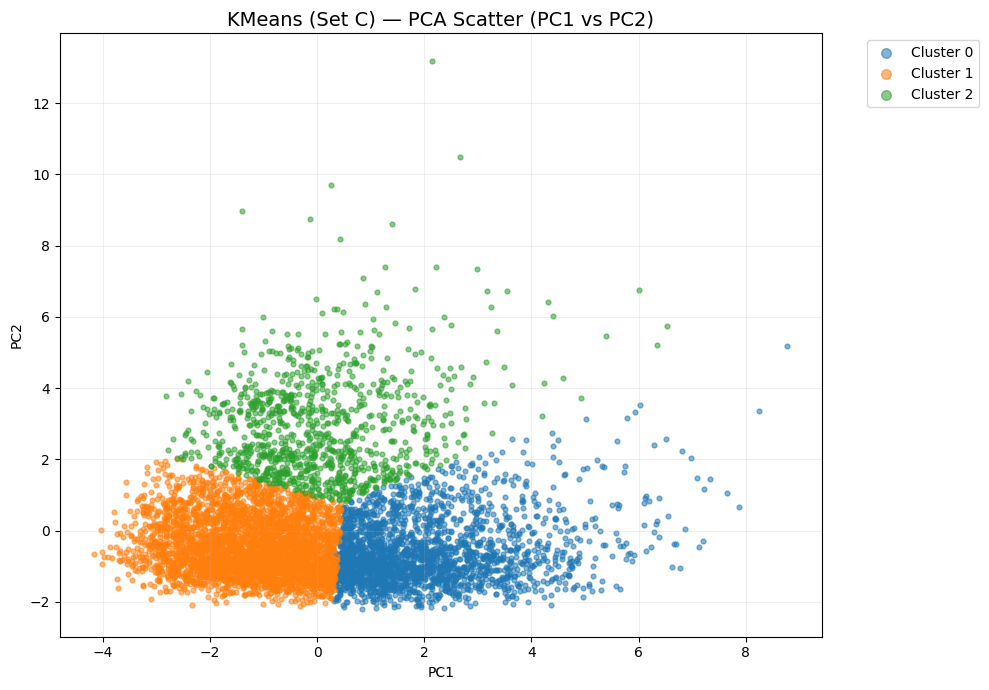

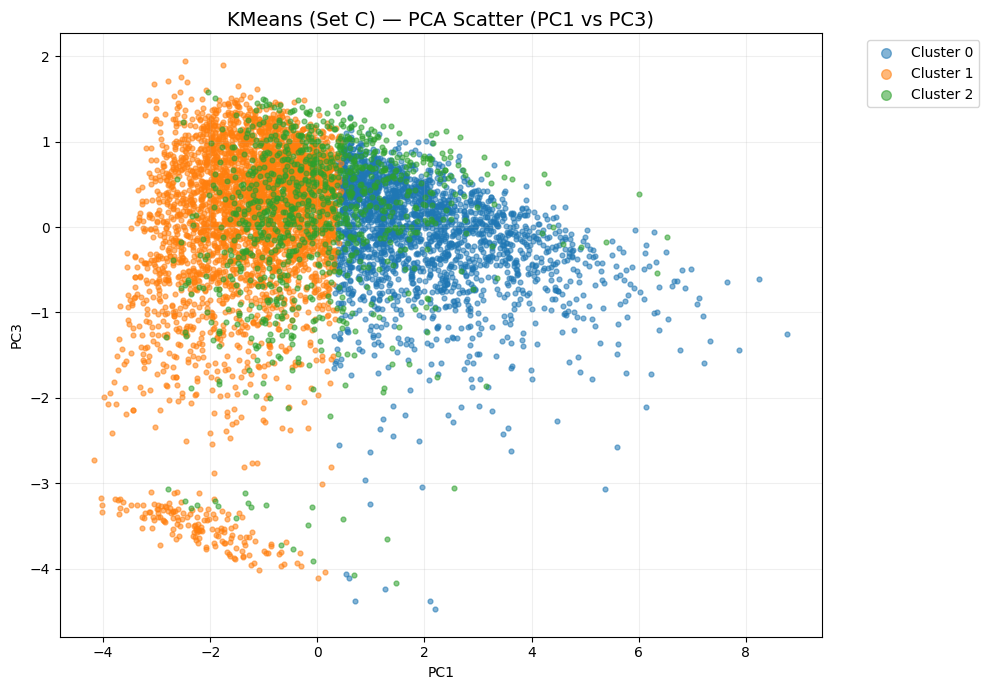

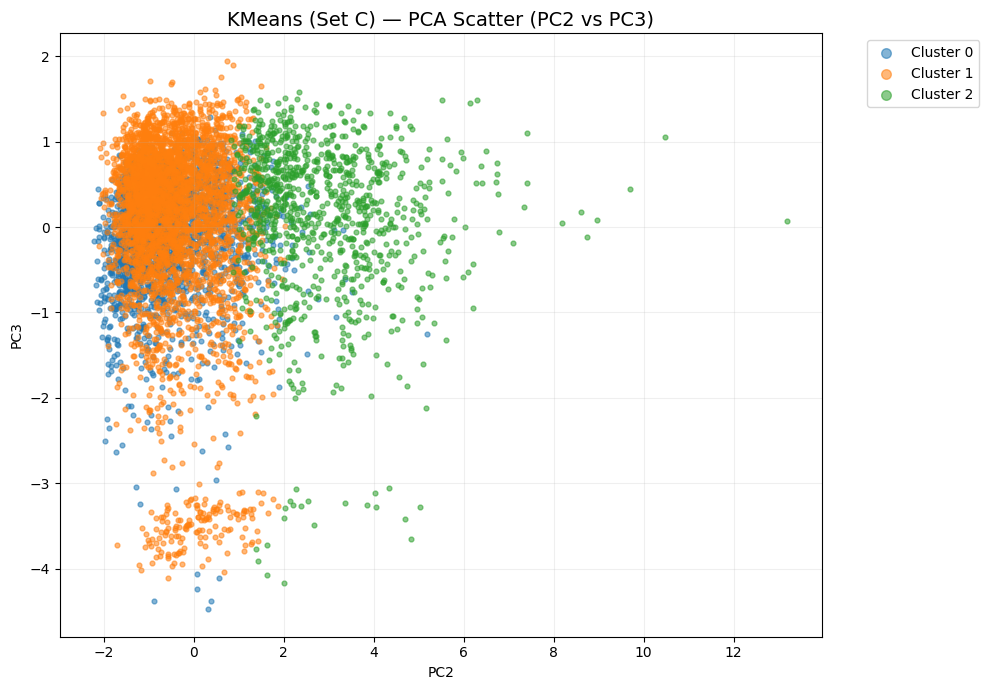

In [163]:
plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_kmeans",
    x="PC1",
    y="PC2",
    title="KMeans (Set C) — PCA Scatter (PC1 vs PC2)"
)

plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_kmeans",
    x="PC1",
    y="PC3",
    title="KMeans (Set C) — PCA Scatter (PC1 vs PC3)"
)

plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_kmeans",
    x="PC2",
    y="PC3",
    title="KMeans (Set C) — PCA Scatter (PC2 vs PC3)"
)

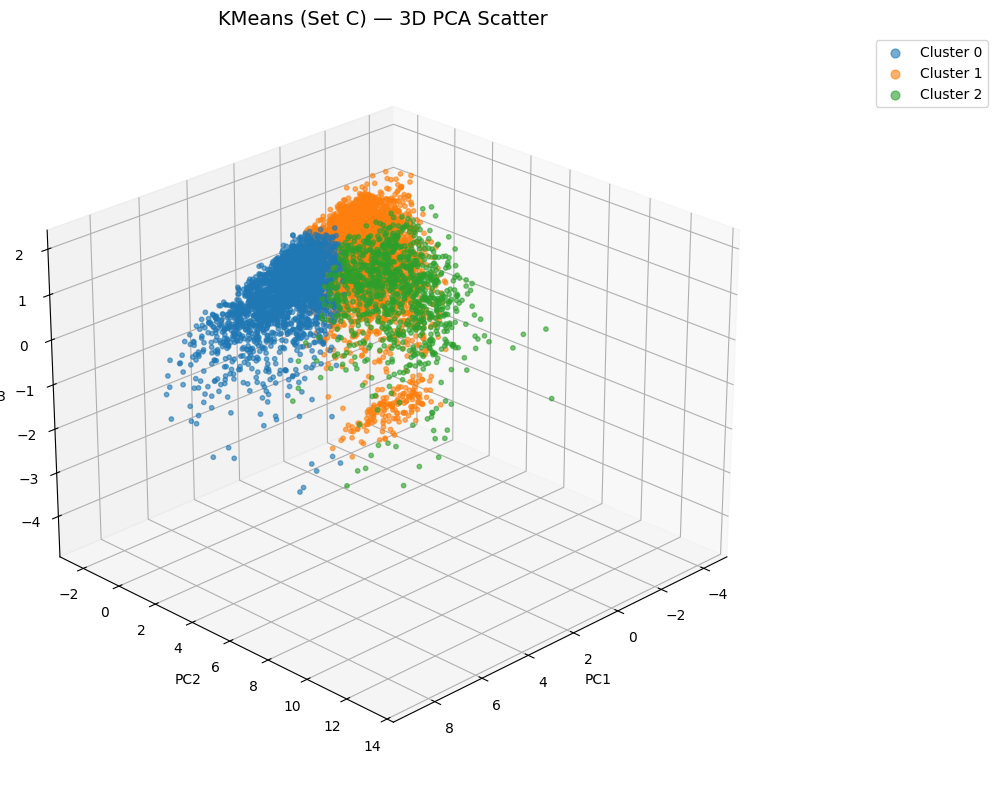

In [167]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def plot_kmeans_pca_3d(df, cluster_col="cluster_C_kmeans", elev=25, azim=45):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    unique_labels = np.sort(df[cluster_col].unique())

    for lab in unique_labels:
        subset = df[df[cluster_col] == lab]
        ax.scatter(
            subset["PC1"], subset["PC2"], subset["PC3"],
            s=10, alpha=0.6, label=f"Cluster {lab}"
        )

    ax.set_title("KMeans (Set C) — 3D PCA Scatter", fontsize=14)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.view_init(elev=elev, azim=azim)
    ax.legend(markerscale=2, bbox_to_anchor=(1.15, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

plot_kmeans_pca_3d(df_plot)

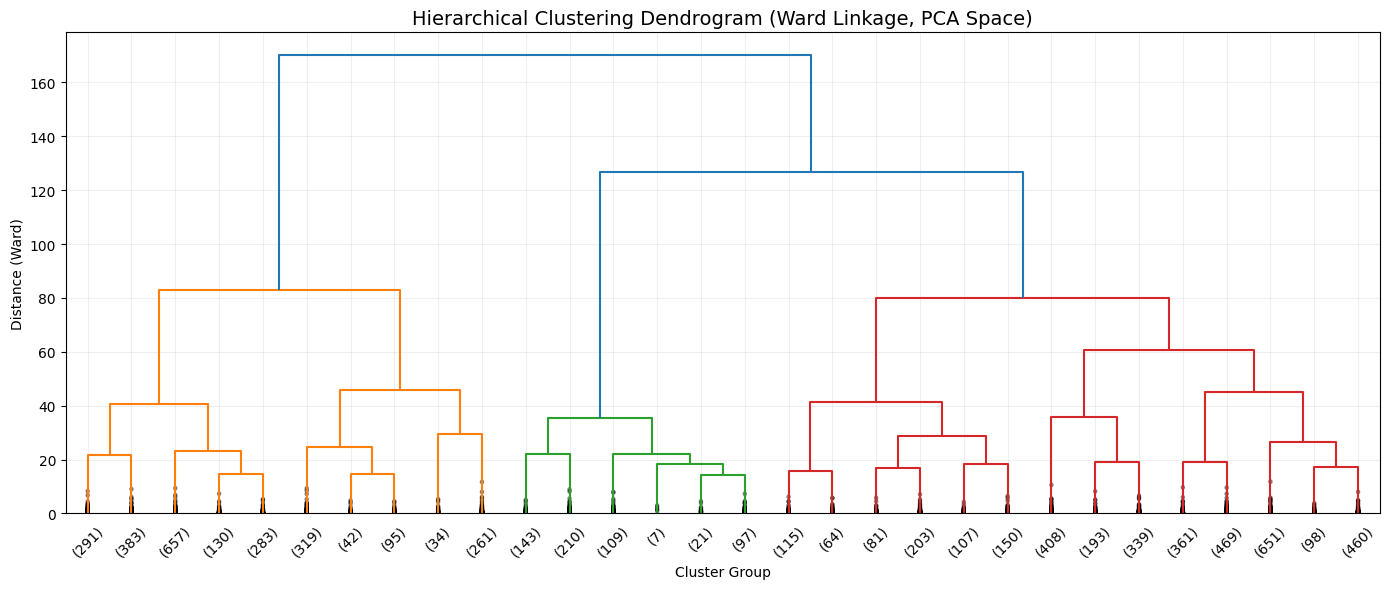

In [169]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_C_pca, method="ward")

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    truncate_mode="lastp",
    p=30,
    leaf_rotation=45,
    leaf_font_size=10,
    show_contracted=True
)

plt.title("Hierarchical Clustering Dendrogram (Ward Linkage, PCA Space)", fontsize=14)
plt.xlabel("Cluster Group")
plt.ylabel("Distance (Ward)")
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

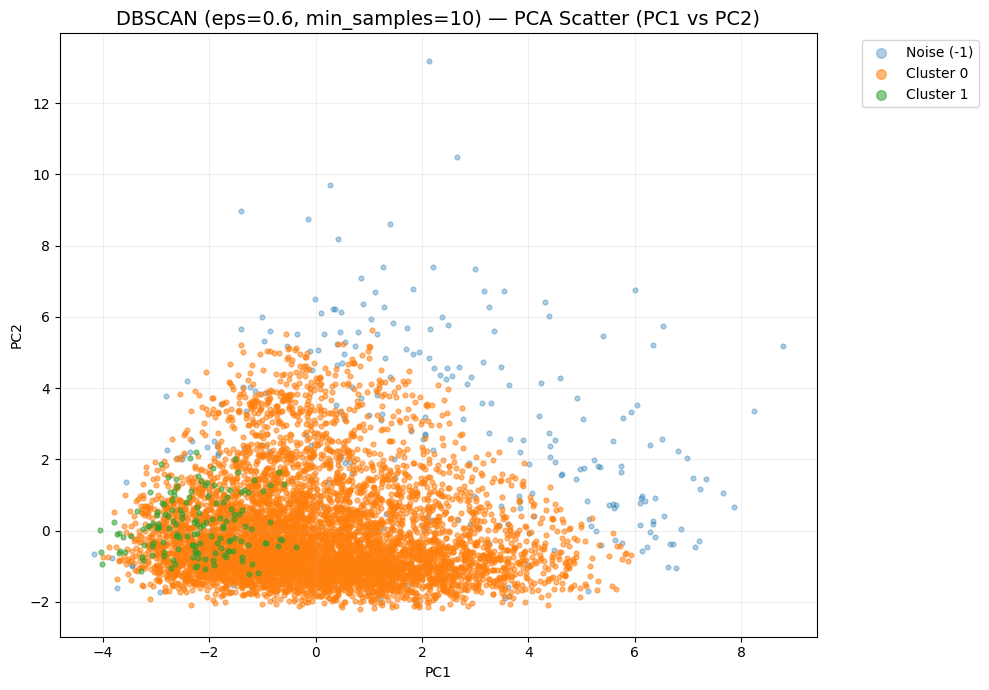

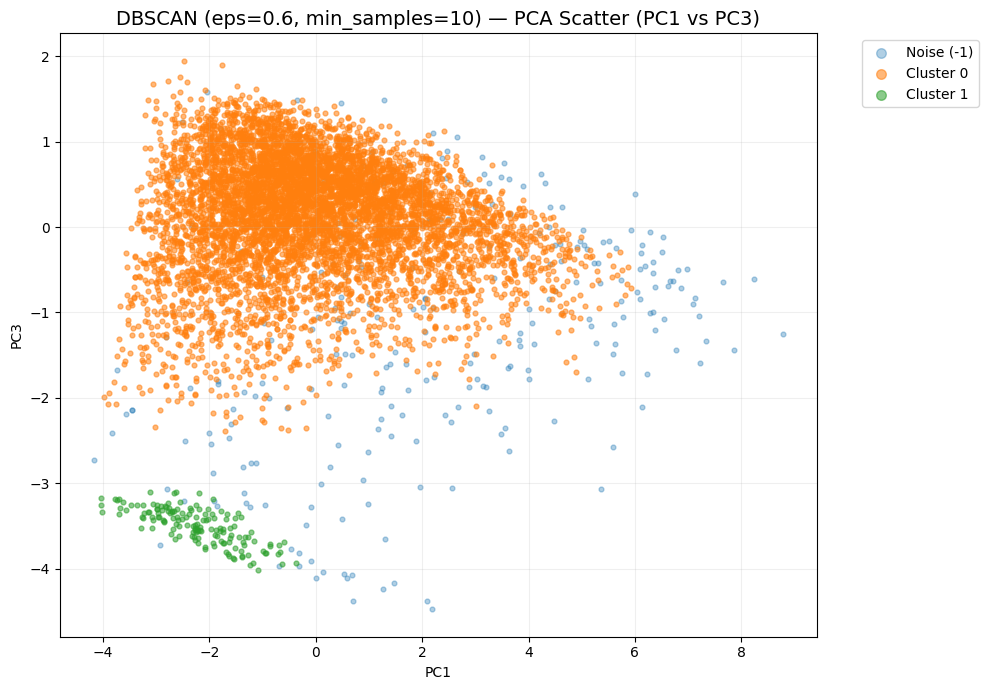

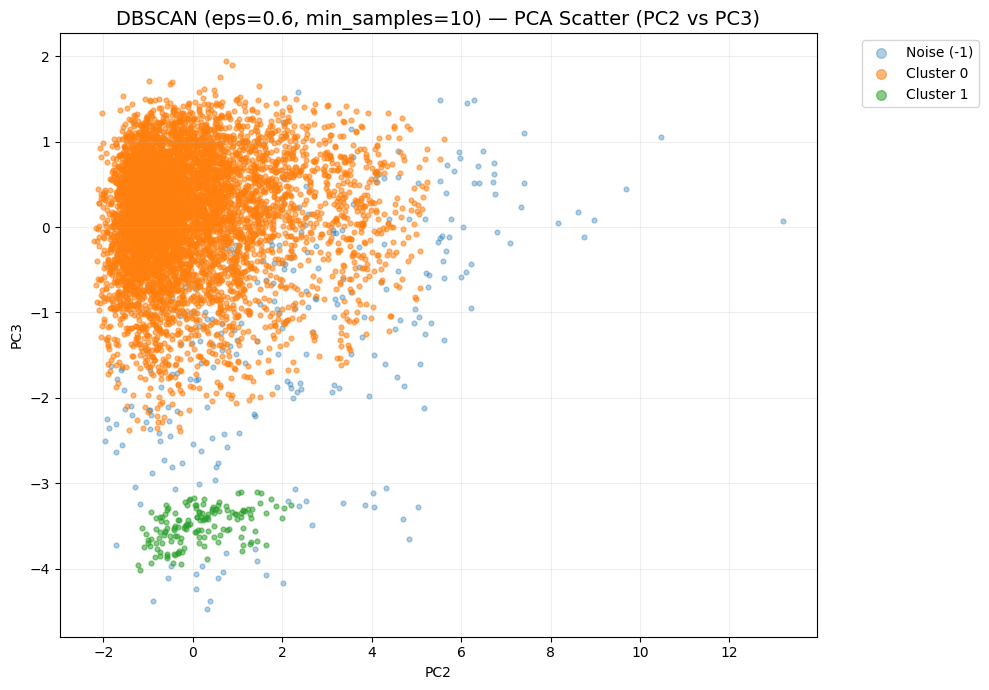

In [165]:
plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_dbscan",
    x="PC1",
    y="PC2",
    title="DBSCAN (eps=0.6, min_samples=10) — PCA Scatter (PC1 vs PC2)"
)

plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_dbscan",
    x="PC1",
    y="PC3",
    title="DBSCAN (eps=0.6, min_samples=10) — PCA Scatter (PC1 vs PC3)"
)

plot_pca_2d(
    df_plot,
    cluster_col="cluster_C_dbscan",
    x="PC2",
    y="PC3",
    title="DBSCAN (eps=0.6, min_samples=10) — PCA Scatter (PC2 vs PC3)"
)

#Final chosen configuration and interpretation

After testing multiple feature sets and clustering methods, the final configuration selected is:

- Feature Set: Set C (8 features)

- Dimensionality reduction: PCA → 3 components

- Clustering algorithm: KMeans

- Final k: 3 clusters

This setup gave the best balance of:

- stable cluster sizes (no “1-game clusters”)

- interpretable results

- decent separation quality

- usable cluster representatives

Set C performed better overall compared to Set B because it includes market popularity signals, not just “value” signals.

Set C includes:

- log_hpp_avg

- log_hpp_med

- log_rpp

- pos_ratio_counts

- log_price

- log_owners

- log_reviews

- log_peak_ccu

Meaning: Set C can separate games not only by “value per peso/dollar” but also by how popular and active the game actually is.

This prevents clustering from being dominated purely by cheap games with weird playtime statistics.

##PCA results

PCA was applied to reduce Set C from 8 dimensions into 3 principal components.

- Explained variance ratio (PC1, PC2, PC3):
[0.4367, 0.2994, 0.1036]

- Total variance captured (3 PCs):
0.8398 (~84%)

This means the 3D PCA space still preserves most of the original information, while making clustering more stable and easier to visualize.

##KMeans performance (k = 3)

KMeans was selected as the final clustering algorithm because it produced:

- stable cluster sizes

- interpretable centroids

- good cluster separation compared to alternatives

Metrics in PCA space:

- Silhouette: 0.3739

- Davies-Bouldin: 0.9290

- Calinski-Harabasz: 3985.33

##Cluster sizes

Final cluster counts for Set C:

- Cluster 0: 2209 games

- Cluster 1: 3584 games

- Cluster 2: 988 games

###**Cluster 0** (2209 games): “Popular / mainstream / high market presence”

- This group is defined more by market impact.

Typical characteristics:

- high owners

- high reviews

- high peak CCU

- usually higher price

- moderate-to-high hours

These are:

- mainstream games

- recognizable franchises

- multiplayer / live-service titles

- games with large communities


###**Cluster 1** (3584 games): “Low engagement / niche / short-play”

- This is the largest group.

Typical characteristics (based on medians):

- low avg/median hours

- low owners

- low reviews

- low peak CCU

- decent ratings but not much traction

These are usually:

- small indie games

- short story games

- niche releases

- forgotten titles

- shovelware (sometimes)



###**Cluster 2** (988 games): “High value budget games”

- This cluster contains games that give high hours-per-price, usually because they are cheap but still played a lot.

Typical characteristics:

- low price

- higher avg/median hours

- strong value-per-price

- moderate popularity

This is basically:

- “cheap but addictive” games

- replayable small games

- grindy games

- budget games with good retention




The final clustering output used for interpretation is:

**KMeans (k=3) on Feature Set C (PCA-reduced to 3 PCs)**

Hierarchical clustering and DBSCAN were used only as comparative validation methods.